In [1]:
import jax.numpy as jnp
import numpy as np
from jax import grad, jit, vmap
from jax import random
from functools import partial

from numba import vectorize, float64, guvectorize, njit

import time
import math
from tqdm import tqdm
import sklearn.mixture
import pandas as pd
import matplotlib.pyplot as plt

from jax.scipy.stats import multivariate_normal, norm
from scipy.stats import multivariate_normal as ss_multivariate_normal
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
import scipy
from scipy.spatial import distance

In [2]:
import jax
jax.devices()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[CpuDevice(id=0)]

In [3]:
key = random.PRNGKey(68)
key1 = random.PRNGKey(6898)
key2 = random.PRNGKey(681998)
subkeys = random.split(key, 5000)
subkeys1 = random.split(key1, 5000)

In [4]:
def alpha_stable(alpha, beta, gamma, delta, dataset_size, num_datasets):
    V = np.pi / 2 * (2 * np.random.rand(num_datasets, dataset_size) - 1)
    W = - np.log(np.random.rand(num_datasets, dataset_size))
    #r = np.zeros(n)
    
    if alpha != 1:
        const = beta * np.tan(np.pi * alpha / 2)
        b = math.atan(const)
        s = (1 + const * const)**(1 / (2 * alpha))
        r = s * np.sin(alpha * V + b) / ((np.cos(V)) ** (1/alpha)) * (( np.cos( (1-alpha) * V - b ) / W )**((1-alpha)/alpha))
        r = gamma * r + delta
    else:
        piover2 = np.pi / 2
        sclshftV = piover2 + beta * V
        r = 1/piover2 * (sclshftV * np.tan(V) - beta * np.log( (piover2 * W * np.cos(V) ) / sclshftV ))
        r = gamma * r + (2 / np.pi) * beta * gamma * np.log(gamma) + delta
    return r

In [5]:
actual_data = alpha_stable(1.8, 0.5, 1, 0, 200, 1)
actual_data

array([[-2.79177494e-01, -2.54157648e+00,  1.75225646e+00,
        -6.75420188e-01, -1.10868880e+00,  5.77562673e-01,
        -2.53344597e+00, -1.09311577e-01, -5.66801141e-01,
         1.22054298e+00, -5.84992799e-01,  3.88110196e-02,
         2.33133637e-01, -4.36830638e-01, -2.25841044e-01,
         1.05425821e+00, -1.11472616e+00,  5.98505488e-01,
         1.16390153e+00, -1.11148101e+00, -1.67717356e+00,
        -2.01750729e+00, -5.34076422e-01, -7.25962201e-01,
        -4.48116444e-03, -3.11488398e+00, -1.39559469e+00,
         2.52772902e-01, -2.74020737e+00,  8.66343211e-01,
        -1.10398972e+00, -4.23464567e-01, -1.36699607e+00,
        -2.29395896e-01,  4.70699987e-01, -3.43640081e-01,
        -8.28159774e-01,  1.71334493e-01,  2.28888162e+00,
        -4.34862763e-01,  6.10845632e-01, -1.77963874e+00,
         3.22283204e-01,  1.89329060e+00, -1.95036399e+00,
         4.63455786e-01, -1.21857606e-01, -1.84622368e+00,
         1.12596871e-01, -2.50350500e-01, -1.63711751e+0

In [6]:
def alpha_stable_ss(data: np.ndarray) -> np.ndarray:
    # Compute quantile statistics
    v_stability = (np.percentile(data, 95) - np.percentile(data, 5)) / (np.percentile(data, 75) - np.percentile(data, 25))
    v_skewness = (np.percentile(data, 95) + np.percentile(data, 5) - 2 * np.percentile(data, 50)) / (np.percentile(data, 95) - np.percentile(data, 5))
    v_scale = (np.percentile(data, 75) - np.percentile(data, 25)) / 1
    v_loc = np.mean(data)

    # Define interpolation matrices (see [1])
    tv_stability = np.array([2.439, 2.5, 2.6, 2.7, 2.8, 3.0, 3.2, 3.5, 4.0, 5.0, 6.0, 8.0, 10.0, 15.0, 25.0])
    tv_skewness = np.array([0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0])
    t_stability = np.array([2.0, 1.9, 1.8, 1.7, 1.6, 1.5, 1.4, 1.3, 1.2, 1.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5])
    t_skewness = np.array([0.0, 0.25, 0.5, 0.75, 1.0])

    psi1 = np.array([[2.000, 2.000, 2.000, 2.000, 2.000, 2.000, 2.000],
    [1.916, 1.924, 1.924, 1.924, 1.924, 1.924, 1.924],
    [1.808, 1.813, 1.829, 1.829, 1.829, 1.829, 1.829],
    [1.729, 1.730, 1.737, 1.745, 1.745, 1.745, 1.745],
    [1.664, 1.663, 1.663, 1.668, 1.676, 1.676, 1.676],
    [1.563, 1.560, 1.553, 1.548, 1.547, 1.547, 1.547],
    [1.484, 1.480, 1.471, 1.460, 1.448, 1.438, 1.438],
    [1.391, 1.386, 1.378, 1.364, 1.337, 1.318, 1.318],
    [1.279, 1.273, 1.266, 1.250, 1.210, 1.184, 1.150],
    [1.128, 1.121, 1.114, 1.101, 1.067, 1.027, 0.973],
    [1.029, 1.021, 1.014, 1.004, 0.974, 0.935, 0.874],
    [0.896, 0.892, 0.887, 0.883, 0.855, 0.823, 0.769],
    [0.818, 0.812, 0.806, 0.801, 0.780, 0.756, 0.691],
    [0.698, 0.695, 0.692, 0.689, 0.676, 0.656, 0.595],
    [0.593, 0.590, 0.588, 0.586, 0.579, 0.563, 0.513]])

    psi2 = np.array([[0.000, 2.160, 1.000, 1.000, 1.000, 1.000, 1.000],
    [0.000, 1.592, 3.390, 1.000, 1.000, 1.000, 1.000],
    [0.000, 0.759, 1.800, 1.000, 1.000, 1.000, 1.000],
    [0.000, 0.482, 1.048, 1.694, 1.000, 1.000, 1.000],
    [0.000, 0.360, 0.760, 1.232, 2.229, 1.000, 1.000],
    [0.000, 0.253, 0.518, 0.823, 1.575, 1.000, 1.000],
    [0.000, 0.203, 0.410, 0.632, 1.244, 1.906, 1.000],
    [0.000, 0.165, 0.332, 0.499, 0.943, 1.560, 1.000],
    [0.000, 0.136, 0.271, 0.404, 0.689, 1.230, 2.195],
    [0.000, 0.109, 0.216, 0.323, 0.539, 0.827, 1.917],
    [0.000, 0.096, 0.190, 0.284, 0.472, 0.693, 1.759],
    [0.000, 0.082, 0.163, 0.243, 0.412, 0.601, 1.596],
    [0.000, 0.074, 0.147, 0.220, 0.377, 0.546, 1.482],
    [0.000, 0.064, 0.128, 0.191, 0.330, 0.478, 1.362],
    [0.000, 0.056, 0.112, 0.167, 0.285, 0.428, 1.274]])

    psi3 = np.array([[1.908, 1.908, 1.908, 1.908, 1.908],
    [1.914, 1.915, 1.916, 1.918, 1.921],
    [1.921, 1.922, 1.927, 1.936, 1.947],
    [1.927, 1.930, 1.943, 1.961, 1.987],
    [1.933, 1.940, 1.962, 1.997, 2.043],
    [1.939, 1.952, 1.988, 2.045, 2.116],
    [1.946, 1.967, 2.022, 2.106, 2.211],
    [1.955, 1.984, 2.067, 2.188, 2.333],
    [1.965, 2.007, 2.125, 2.294, 2.491],
    [1.980, 2.040, 2.205, 2.435, 2.696],
    [2.000, 2.085, 2.311, 2.624, 2.973],
    [2.040, 2.149, 2.461, 2.886, 3.356],
    [2.098, 2.244, 2.676, 3.265, 3.912],
    [2.189, 2.392, 3.004, 3.844, 4.775],
    [2.337, 2.635, 3.542, 4.808, 6.247],
    [2.588, 3.073, 4.534, 6.636, 9.144]])


    psi4 = np.array([[0.0,    0.0,    0.0,    0.0,  0.0],  
    [0.0, -0.017, -0.032, -0.049, -0.064],
    [0.0, -0.030, -0.061, -0.092, -0.123],
    [0.0, -0.043, -0.088, -0.132, -0.179],
    [0.0, -0.056, -0.111, -0.170, -0.232],
    [0.0, -0.066, -0.134, -0.206, -0.283],
    [0.0, -0.075, -0.154, -0.241, -0.335],
    [0.0, -0.084, -0.173, -0.276, -0.390],
    [0.0, -0.090, -0.192, -0.310, -0.447],
    [0.0, -0.095, -0.208, -0.346, -0.508],
    [0.0, -0.098, -0.223, -0.383, -0.576],
    [0.0, -0.099, -0.237, -0.424, -0.652],
    [0.0, -0.096, -0.250, -0.469, -0.742],
    [0.0, -0.089, -0.262, -0.520, -0.853],
    [0.0, -0.078, -0.272, -0.581, -0.997],
    [0.0, -0.061, -0.279, -0.659, -1.198]])

    tv_stability_i1 = max(np.append(0, np.argwhere(tv_stability <= v_stability)))
    tv_stability_i2 = min(np.append(14, np.argwhere(tv_stability >= v_stability)))
    tv_skewness_i1 = max(np.append(0, np.argwhere(tv_skewness <= abs(v_skewness))))
    tv_skewness_i2 = min(np.append(6, np.argwhere(tv_skewness >= abs(v_skewness))))
    dist_stability = tv_stability[tv_stability_i2] - tv_stability[tv_stability_i1]
    if dist_stability != 0:
        dist_stability = (v_stability - tv_stability[tv_stability_i1]) / dist_stability

    dist_skewness = tv_skewness[tv_skewness_i2] - tv_skewness[tv_skewness_i1]
    if dist_skewness != 0:
        dist_skewness = (abs(v_skewness) - tv_skewness[tv_skewness_i1]) / dist_skewness

    psi1b1 = dist_stability*psi1[tv_stability_i2,tv_skewness_i1]+(1-dist_stability)*psi1[tv_stability_i1,tv_skewness_i1]
    psi1b2 = dist_stability*psi1[tv_stability_i2,tv_skewness_i2]+(1-dist_stability)*psi1[tv_stability_i1,tv_skewness_i2]
    alpha = dist_skewness*psi1b2+(1-dist_skewness)*psi1b1
    psi2b1 = dist_stability*psi2[tv_stability_i2,tv_skewness_i1]+(1-dist_stability)*psi2[tv_stability_i1,tv_skewness_i1]
    psi2b2 = dist_stability*psi2[tv_stability_i2,tv_skewness_i2]+(1-dist_stability)*psi2[tv_stability_i1,tv_skewness_i2]
    beta = np.sign(v_skewness)*(dist_skewness*psi2b2+(1-dist_skewness)*psi2b1)
    t_stability_i1 = max(np.append(0, np.argwhere(t_stability >= alpha)))
    t_stability_i2 = min(np.append(15, np.argwhere(t_stability <= alpha)))
    t_skewness_i1 = max(np.append(0, np.argwhere(t_skewness <= abs(beta))))
    t_skewness_i2 = min(np.append(4, np.argwhere(t_skewness >= abs(beta))))

    dist_stability = t_stability[t_stability_i2] - t_stability[t_stability_i1]
    if dist_stability != 0:
        dist_stability = (alpha - t_stability[t_stability_i1]) / dist_stability

    dist_skewness = t_skewness[t_skewness_i2] - t_skewness[t_skewness_i1]
    if dist_skewness != 0:
        dist_skewness = (abs(beta) - t_skewness[t_skewness_i1]) / dist_skewness

    psi3b1 = dist_stability*psi3[t_stability_i2,t_skewness_i1]+(1-dist_stability)*psi3[t_stability_i1,t_skewness_i1]
    psi3b2 = dist_stability*psi3[t_stability_i2,t_skewness_i2]+(1-dist_stability)*psi3[t_stability_i1,t_skewness_i2]
    sigma = v_scale/(dist_skewness*psi3b2+(1-dist_skewness)*psi3b1)
    psi4b1 = dist_stability*psi4[t_stability_i2,t_skewness_i1]+(1-dist_stability)*psi4[t_stability_i1,t_skewness_i1]
    psi4b2 = dist_stability*psi4[t_stability_i2,t_skewness_i2]+(1-dist_stability)*psi4[t_stability_i1,t_skewness_i2]
    zeta = np.sign(beta)*sigma*(dist_skewness*psi4b2+(1-dist_skewness)*psi4b1) + np.percentile(data, 50)

    if abs(alpha-1) < 0.05:
        mu = zeta
    else:
        mu = zeta - beta * sigma * math.tan(0.5 * math.pi *alpha)

    return np.array([alpha, beta, sigma, mu]) #stability, skewness, scale, loc


In [7]:
actual_summary_statistics = alpha_stable_ss(actual_data)
actual_summary_statistics

array([ 1.89641293,  0.59049351,  0.82330526, -0.1906515 ])

In [8]:
num_coeffs = 4
num_latent = 4
len_ss = np.shape(actual_summary_statistics)[0]
n_samples = 30
num_datasets = 200
lambda_dim = num_coeffs + int((num_coeffs * (num_coeffs + 1)) / 2)
eps_precision = 100

sigma_theta = 10
sigma_latent = 1

In [9]:
def my_inv(x):
    return jnp.linalg.inv(x + (jnp.eye(x.shape[0]) * 1e-7))

## Training Wasserstein Gaussianing

In [10]:
len_ss = np.shape(actual_summary_statistics)[0]
wass_num_datasets = 10000
wass_val_num_datasets = 10000
wass_n_samples = 30
d_Lambda = 2 + len_ss
num_layers = 16
# To optimize F
tau = 0.01
stop_f = 10000
learning_rate = 0.005
l_threshold = 10
threshold = stop_f/2
adaptive_lr_1 = 0.9
adaptive_lr_2 = 0.9
t_w_f = 50
Patience_f = 51
batch_size = 32
# To optimize LB
stop = 5000
Patience = 20

In [11]:
# Generating data to train the transform
wass_datasets = alpha_stable(1.8, 0.5, 1, 0, wass_n_samples, wass_num_datasets)
wass_n_summary_statistics = np.array([alpha_stable_ss(wass_datasets[i,:]) for i in range(wass_num_datasets)])
val_n_summary_statistics = np.array([alpha_stable_ss(wass_datasets[i,:]) for i in range(wass_val_num_datasets)])
original_n_summary_statistics = wass_n_summary_statistics

In [12]:
scaler_mean = jnp.mean(original_n_summary_statistics, axis=0)
scaler_std = jnp.std(original_n_summary_statistics, axis=0)

In [13]:
scaler_mean

Array([ 1.7869564 ,  0.26938486,  0.9508774 , -0.01853945], dtype=float32)

In [14]:
scaler_std

Array([0.2570306 , 1.0920215 , 0.21768068, 0.4292593 ], dtype=float32)

In [15]:
wass_n_summary_statistics = (wass_n_summary_statistics - scaler_mean) / scaler_std

In [16]:
def radial_flow(Lambda, x):
    # original_x = x
    d_Lambda = 2 + len_ss
    logdet_jacob_T_x = 0
    for k in range(num_layers):
        # print(k)
        Lambda_k = Lambda[k * d_Lambda : (k + 1) * d_Lambda]
        alpha = jnp.exp(Lambda_k[0])
        beta = -alpha + jnp.exp(Lambda_k[1])
        # beta = tau * beta
        mu = Lambda_k[2:]
        # r_x = jnp.linalg.norm(x - mu)
        r_x = jnp.sqrt(jnp.dot((x - mu).T, (x - mu)))
        x = x + beta / (alpha + r_x) * (x - mu)
        logdet_jacob_T_x += jnp.log(1 + alpha * beta / (alpha + r_x)**2) + (len_ss - 1) * jnp.log(1 + beta / (alpha + r_x))
        # f = - logdet_jacob_T_x + 1/2 * T_x.T @ T_x + 1/(2*0.1) * (jnp.linalg.norm(x - T_x))**2
    return x, logdet_jacob_T_x

In [17]:
# d_Lambda = 16
# num_layers = 2

In [18]:
# def autoregressive_flow(Lambda, x):
#     logdet_jacob_T_x = 0.0
#     for k in range(num_layers):
#         Lambda_k = Lambda[k * d_Lambda : (k + 1) * d_Lambda]
#         v_f = Lambda_k[0]
#         w_f = Lambda_k[1]
#         b_f = Lambda_k[2]
#         v_in = Lambda_k[3]
#         w_in = Lambda_k[4]
#         b_in = Lambda_k[5]
#         v_d = Lambda_k[6]
#         w_d = Lambda_k[7]
#         b_d = Lambda_k[8]
#         v_out = Lambda_k[9]
#         w_out = Lambda_k[10]
#         b_out = Lambda_k[11]
#         beta0 = Lambda_k[12]
#         beta1 = Lambda_k[13]
#         alpha0 = Lambda_k[14]
#         alpha1 = Lambda_k[15]

#         c_h = 0.0
#         h = 0.0
#         mu = beta0 + beta1 * h
#         s = alpha0 + alpha1 * h
#         x_new = mu + jnp.exp(s) * x[0]
#         logdet_jacob_T_x += s
#         x = jnp.concatenate((jnp.expand_dims(x_new, axis=0), x[1:]))
#         for i in range(1, len_ss):
#             g_f = jax.nn.sigmoid(v_f * x[i-1] + w_f * h + b_f)
#             g_in = jax.nn.sigmoid(v_in * x[i-1] + w_in * h + b_in)
#             x_d = jax.nn.sigmoid(v_d * x[i-1] + w_d * h + b_d)
#             g_out = jax.nn.sigmoid(v_out * x[i-1] + w_out * h + b_out)
#             c_h = g_f * c_h + g_in * x_d
#             h = g_out * jnp.tanh(c_h)
#             mu = beta0 + beta1 * h
#             s = alpha0 + alpha1 * h
#             x_new = mu + jnp.exp(s) * x[i]
#             logdet_jacob_T_x += s
#             x = jnp.concatenate((x[:i], jnp.expand_dims(x_new, axis=0), x[i+1:]))
#     return x, logdet_jacob_T_x

In [19]:
# def inverse_autoregressive_nf(Lambda, T_x):
#     x = T_x.copy()
#     for k in range(num_layers-1, -1, -1):
#         Lambda_k = Lambda[k * d_Lambda : (k + 1) * d_Lambda]
#         v_f = Lambda_k[0]
#         w_f = Lambda_k[1]
#         b_f = Lambda_k[2]
#         v_in = Lambda_k[3]
#         w_in = Lambda_k[4]
#         b_in = Lambda_k[5]
#         v_d = Lambda_k[6]
#         w_d = Lambda_k[7]
#         b_d = Lambda_k[8]
#         v_out = Lambda_k[9]
#         w_out = Lambda_k[10]
#         b_out = Lambda_k[11]
#         beta0 = Lambda_k[12]
#         beta1 = Lambda_k[13]
#         alpha0 = Lambda_k[14]
#         alpha1 = Lambda_k[15]

#         c_h = 0.0
#         h = 0.0
#         mu = beta0 + beta1 * h
#         s = alpha0 + alpha1 * h
#         x_new = (x[0] - mu) / jnp.exp(s)
#         x = jnp.concatenate((x_new.reshape(1,), x[1:]))
#         for i in range(1, len_ss):
#             g_f = jax.nn.sigmoid(v_f * x[i-1] + w_f * h + b_f)
#             g_in = jax.nn.sigmoid(v_in * x[i-1] + w_in * h + b_in)
#             x_d = jax.nn.sigmoid(v_d * x[i-1] + w_d * h + b_d)
#             g_out = jax.nn.sigmoid(v_out * x[i-1] + w_out * h + b_out)
#             c_h = g_f * c_h + g_in * x_d
#             h = g_out * jnp.tanh(c_h)
#             mu = beta0 + beta1 * h
#             s = alpha0 + alpha1 * h
#             x_new = (x[i] - mu) / jnp.exp(s)
#             x = jnp.concatenate((x[:i], x_new.reshape(1,), x[i+1:]))
#         print(x)

In [20]:
def f_with_Lambda(Lambda, x):
    N_samples, _ = x.shape
    f = 0.0
    for i in range(N_samples):
        x_i = x[i, :]
        T_x_i, log_Jacobian = radial_flow(Lambda, x_i)
        diff = x_i - T_x_i
        f = f - log_Jacobian + 1/2 * T_x_i.T @ T_x_i + 0.5 / 0.1 * jnp.dot(diff.T, diff)
    f /= N_samples
    return f

In [21]:
def kl(x):
    return 1/2 * x.T @ x

In [22]:
Lambda = random.normal(subkeys[5], (num_layers * d_Lambda,))
Lambda

Array([ 2.08993241e-01,  5.66621482e-01,  1.28206408e+00,  6.77539468e-01,
       -9.90440473e-02,  8.16900671e-01, -2.40860969e-01,  1.00477539e-01,
        1.15359974e+00,  1.12185478e+00,  8.38952243e-01,  5.85369579e-02,
       -6.98966503e-01, -4.21154618e-01,  1.91517484e+00, -1.14733088e+00,
        1.20860375e-01, -4.93730605e-01,  5.67690074e-01,  6.18178844e-01,
        8.78773749e-01,  2.69768715e-01, -1.01986349e+00, -6.05926454e-01,
        7.78828636e-02, -6.37762904e-01,  9.45594311e-01, -2.04114154e-01,
       -4.93829519e-01, -1.20717548e-01, -6.09589756e-01, -2.49894902e-01,
        1.09743488e+00, -6.85822070e-01,  4.97336596e-01, -9.09449756e-02,
       -1.35320652e+00,  1.41687059e+00,  8.85856748e-01,  1.86581349e+00,
        2.12329790e-01,  1.62113130e+00,  5.48524976e-01,  2.38398075e+00,
       -1.28872097e-01,  1.62475240e+00,  9.48236108e-01, -1.30273283e-01,
       -1.00185275e+00,  1.01962495e+00, -1.42072916e+00,  1.75846004e+00,
       -2.07935643e+00, -

In [23]:
def numerical_grad(Lambda, x):
    epsilon = 0.001
    grad = []
    perturbed_Lambda = Lambda
    for i in range(Lambda.shape[0]):
        perturbed_Lambda = Lambda.at[i].set(Lambda[i] + epsilon)
        grad_i = (f_with_Lambda(perturbed_Lambda, x) - f_with_Lambda(Lambda, x)) / epsilon
        grad.append(grad_i)
    return jnp.array(grad)

# Compute the gradient using jax.grad
grad_f_with_Lambda = grad(f_with_Lambda, argnums=0)(Lambda, wass_n_summary_statistics[:5])

# Compute the numerical gradient
numerical_grad_f = numerical_grad(Lambda, wass_n_summary_statistics[:5])

# Compare the gradients
print("Gradient computed by jax.grad:", grad_f_with_Lambda)
print("Numerical gradient:", numerical_grad_f)


Gradient computed by jax.grad: [-3.71011429e+01  4.49351654e+01 -1.12197351e+00  4.29179621e+00
 -1.54841268e+00  3.60783100e+00 -1.90865765e+01  2.43394279e+01
 -3.32169950e-01  2.02837992e+00 -2.33281398e+00  3.46913648e+00
 -9.29807663e-01  1.20090330e+00  2.13721395e-01  1.36576843e+00
 -3.16801071e-01  1.26020646e+00 -1.93863583e+01  1.99866257e+01
  5.27187586e-02  6.21057749e-01 -4.34816852e-02  6.22452915e-01
 -1.20689840e+01  7.08591843e+00  6.53437972e-02 -6.31518650e+00
  6.67813182e-01 -6.25992060e+00 -2.80367661e+00  3.76264215e+00
  3.87890637e-01  2.68323183e+00 -1.03576028e+00  2.77596951e+00
 -2.26928711e+01  1.61713333e+02 -2.10660028e+00  3.20667791e+00
 -6.94799232e+00  3.25825882e+00 -9.09186859e+01  2.54831711e+02
  3.37814379e+00  6.58048487e+00 -3.74948263e+00  8.64542198e+00
 -1.28781481e+01  8.10297623e+01  7.19237804e-01 -1.85686409e-01
  3.53419006e-01  1.25003016e+00 -1.19583340e+01  9.73932076e+00
 -3.87898041e-03 -4.65309620e-03  1.52085545e-02 -3.6782156

In [24]:
# transform_auto = vmap(transform, in_axes=[None, 0])
# ld = jnp.array([[ 9.8849577e-01,  1.5299016e-01,  2.2273587e-01],
#  [ 1.2528000e+00,  3.0170134e-01,  4.1835719e-01],
#  [ 9.9856323e-01, -3.3750209e-01,  4.2969415e-01],
#  [ 6.8906683e-01, -2.1584990e-02,  4.1443220e-01],
#  [ 1.3535814e-03,  1.5768929e+00,  4.1934836e-01]])
# for i in range(1000):
#     print(transform_auto(ld, wass_n_summary_statistics)[0][i])
#     print(transform_auto(ld, wass_n_summary_statistics)[1][i])

In [25]:
transform_auto = vmap(radial_flow, in_axes=[None, 0])
kl_auto = vmap(kl)
KL_all = []
Lambda_list = []
patience = 0
Lambda = random.normal(subkeys[0], (num_layers * d_Lambda,))
kl_helper = jnp.sum(norm.logpdf(original_n_summary_statistics), axis=1)
for k in tqdm(range(stop)):
    f_all = []
    F_Smoothed = []
    patience_f = 0
    # Lambda = random.uniform(subkeys[k], (num_layers * d_Lambda,), minval=0, maxval=10).reshape(num_layers, d_Lambda)
    for t in range(stop_f):
        # Batch data
        random_row_indices = random.permutation(subkeys1[t], wass_num_datasets)[:batch_size]
        # Select the rows from the matrix using the random row indices
        subset_n_summary_statistics = wass_n_summary_statistics[random_row_indices, :]
        grad_lambda = grad(f_with_Lambda, argnums=0)(Lambda, subset_n_summary_statistics)
        f_t = f_with_Lambda(Lambda, subset_n_summary_statistics)
        if t == 0:
            # Update lambda_q
            g_lambda_init = grad_lambda
            if jnp.linalg.norm(g_lambda_init) > l_threshold:
                g_lambda_init = l_threshold * g_lambda_init / jnp.linalg.norm(g_lambda_init)
            v_lambda_init = g_lambda_init ** 2
        else:
            # Update lambda_q
            g_lambda_t = grad_lambda
            if jnp.linalg.norm(g_lambda_t) > l_threshold:
                g_lambda_t = l_threshold * g_lambda_t / jnp.linalg.norm(g_lambda_t)
            v_lambda_t = g_lambda_t ** 2
            #---- Update lambda
            g_lambda_init = adaptive_lr_1 * g_lambda_init + (1 - adaptive_lr_1) * g_lambda_t
            v_lambda_init = adaptive_lr_2 * v_lambda_init + (1 - adaptive_lr_2) * v_lambda_t
        if t >= threshold:
            update_t = learning_rate * threshold / t
        else:
            update_t = learning_rate
        Lambda = Lambda - update_t * g_lambda_init / (v_lambda_init ** 0.5)
        # Calculate lower bound
        f_all.append(f_t)
        if t >= t_w_f:
            f_smoothed = jnp.mean(jnp.array(f_all[t - t_w_f + 1 : t]))
            print('F Smoothed', f_smoothed)
            F_Smoothed.append(f_smoothed)
            if f_smoothed <= jnp.min(jnp.array(F_Smoothed)):
                patience_f = 0
                lambda_best = Lambda
            else:
                patience_f += 1
                if patience_f > Patience_f:
                    print("Stop at", t)
                    break
    Lambda_list.append(lambda_best)
    wass_n_summary_statistics = transform_auto(lambda_best, wass_n_summary_statistics)[0]
    kl_helper = kl_helper - transform_auto(lambda_best, wass_n_summary_statistics)[1]
    kl_k = jnp.mean(kl_helper + kl_auto(wass_n_summary_statistics))
    KL_all.append(kl_k)
    print('>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<<', kl_k)
    if kl_k > jnp.min(jnp.array(KL_all)):
        patience += 1
    else:
        patience = 0
        transformed_n_summary_statistics = wass_n_summary_statistics
    if patience > Patience:
        print("Stop at", k)
        break

  0%|          | 0/5000 [00:00<?, ?it/s]

F Smoothed 684.3471
F Smoothed 664.6305
F Smoothed 645.48096
F Smoothed 626.76953
F Smoothed 608.11
F Smoothed 589.5747
F Smoothed 572.0208
F Smoothed 554.6359
F Smoothed 537.7752
F Smoothed 521.32025
F Smoothed 505.044
F Smoothed 488.69537
F Smoothed 472.65552
F Smoothed 457.2508
F Smoothed 441.8187
F Smoothed 427.14508
F Smoothed 412.4834
F Smoothed 398.4356
F Smoothed 384.30658
F Smoothed 370.6219
F Smoothed 357.31256
F Smoothed 344.5948
F Smoothed 331.79532
F Smoothed 319.32642
F Smoothed 306.782
F Smoothed 295.16476
F Smoothed 283.83508
F Smoothed 272.40506
F Smoothed 261.81763
F Smoothed 250.79524
F Smoothed 240.07162
F Smoothed 229.86076
F Smoothed 219.66159
F Smoothed 209.99606
F Smoothed 200.68608
F Smoothed 191.61655
F Smoothed 182.7414
F Smoothed 174.10274
F Smoothed 165.61212
F Smoothed 157.68727
F Smoothed 149.98685
F Smoothed 142.35237
F Smoothed 134.97575
F Smoothed 127.70498
F Smoothed 120.70089
F Smoothed 114.23819
F Smoothed 107.78329
F Smoothed 101.68245
F Smoothed 9

  0%|          | 1/5000 [5:01:13<25096:50:54, 18073.35s/it]

F Smoothed 2.0262816
F Smoothed 2.029258
F Smoothed 2.0310347
F Smoothed 2.024031
F Smoothed 2.0140076
F Smoothed 2.010483
F Smoothed 2.010066
F Smoothed 2.0096588
F Smoothed 1.9960071
F Smoothed 1.9750295
F Smoothed 1.9690716
F Smoothed 1.9729029
F Smoothed 1.9616572
F Smoothed 1.964579
F Smoothed 1.9605429
F Smoothed 1.9310994
F Smoothed 1.9265544
F Smoothed 1.9333112
F Smoothed 1.9385475
F Smoothed 1.9386172
F Smoothed 1.949191
F Smoothed 1.9356966
F Smoothed 1.9410874
F Smoothed 1.9385374
F Smoothed 1.9266566
F Smoothed 1.9265499
F Smoothed 1.9149908
F Smoothed 1.9135717
F Smoothed 1.8844748
F Smoothed 1.8729733
F Smoothed 1.8656944
F Smoothed 1.8566636
F Smoothed 1.8744055
F Smoothed 1.8759631
F Smoothed 1.8738556
F Smoothed 1.8725623
F Smoothed 1.8643632
F Smoothed 1.8771652
F Smoothed 1.8818758
F Smoothed 1.878559
F Smoothed 1.8941855
F Smoothed 1.9023474
F Smoothed 1.9046642
F Smoothed 1.9087502
F Smoothed 1.9054867
F Smoothed 1.8971274
F Smoothed 1.9009908
F Smoothed 1.90875
F

  0%|          | 2/5000 [6:19:53<14186:42:15, 10218.51s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -4.663556
F Smoothed 2.08011
F Smoothed 2.0830934
F Smoothed 2.0847661
F Smoothed 2.078482
F Smoothed 2.0695546
F Smoothed 2.0665145
F Smoothed 2.0678818
F Smoothed 2.0693705
F Smoothed 2.0571177
F Smoothed 2.0374236
F Smoothed 2.0319726
F Smoothed 2.0356214
F Smoothed 2.0260794
F Smoothed 2.0294993
F Smoothed 2.0267856
F Smoothed 1.997655
F Smoothed 1.9941815
F Smoothed 2.000392
F Smoothed 2.0057287
F Smoothed 2.0053802
F Smoothed 2.0163274
F Smoothed 2.0025198
F Smoothed 2.006725
F Smoothed 2.0042114
F Smoothed 1.9918932
F Smoothed 1.9924428
F Smoothed 1.98152
F Smoothed 1.9806559
F Smoothed 1.9518379
F Smoothed 1.940798
F Smoothed 1.9329522
F Smoothed 1.9240056
F Smoothed 1.9417943
F Smoothed 1.9432609
F Smoothed 1.9405146
F Smoothed 1.9390941
F Smoothed 1.9307064
F Smoothed 1.943068
F Smoothed 1.9478503
F Smoothed 1.9449204
F Smoothed 1.9594504
F Smoothed 1.9675059
F Smoothed 1.9702431
F Smoothed 1.9740477
F Smoothed 1.9704291
F Sm

  0%|          | 3/5000 [7:16:32<9861:17:14, 7104.39s/it]  

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -4.71165
F Smoothed 2.138077
F Smoothed 2.1412394
F Smoothed 2.143329
F Smoothed 2.1365645
F Smoothed 2.1279387
F Smoothed 2.1247945
F Smoothed 2.125378
F Smoothed 2.1274843
F Smoothed 2.1155248
F Smoothed 2.0961726
F Smoothed 2.0903203
F Smoothed 2.0938928
F Smoothed 2.0852063
F Smoothed 2.0894485
F Smoothed 2.0876966
F Smoothed 2.0580854
F Smoothed 2.0547993
F Smoothed 2.0605986
F Smoothed 2.0653703
F Smoothed 2.0646122
F Smoothed 2.0755594
F Smoothed 2.0622675
F Smoothed 2.0680387
F Smoothed 2.0655751
F Smoothed 2.0526958
F Smoothed 2.0539625
F Smoothed 2.0442
F Smoothed 2.043134
F Smoothed 2.014363
F Smoothed 2.0032892
F Smoothed 1.9953806
F Smoothed 1.986419
F Smoothed 2.0045538
F Smoothed 2.0060928
F Smoothed 2.0028303
F Smoothed 2.001344
F Smoothed 1.992632
F Smoothed 2.0042112
F Smoothed 2.0091717
F Smoothed 2.006455
F Smoothed 2.0207856
F Smoothed 2.0274498
F Smoothed 2.030173
F Smoothed 2.0337682
F Smoothed 2.0295067
F Smooth

  0%|          | 4/5000 [8:09:37<7712:23:04, 5557.36s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -4.7505007
F Smoothed 2.1961625
F Smoothed 2.1995966
F Smoothed 2.2023883
F Smoothed 2.1955137
F Smoothed 2.1872964
F Smoothed 2.18454
F Smoothed 2.1845064
F Smoothed 2.1868167
F Smoothed 2.174709
F Smoothed 2.1561935
F Smoothed 2.1499207
F Smoothed 2.1530294
F Smoothed 2.144885
F Smoothed 2.149621
F Smoothed 2.1483727
F Smoothed 2.1186504
F Smoothed 2.1155796
F Smoothed 2.1211617
F Smoothed 2.125989
F Smoothed 2.124976
F Smoothed 2.135717
F Smoothed 2.1225288
F Smoothed 2.128776
F Smoothed 2.1267142
F Smoothed 2.1129527
F Smoothed 2.1148248
F Smoothed 2.1064167
F Smoothed 2.1047559
F Smoothed 2.0762272
F Smoothed 2.0647733
F Smoothed 2.0574934
F Smoothed 2.0487094
F Smoothed 2.0671625
F Smoothed 2.0684748
F Smoothed 2.0646803
F Smoothed 2.0633574
F Smoothed 2.0543451
F Smoothed 2.0652595
F Smoothed 2.0703557
F Smoothed 2.0674942
F Smoothed 2.0824926
F Smoothed 2.0878925
F Smoothed 2.0906067
F Smoothed 2.093908
F Smoothed 2.0890086
F S

  0%|          | 5/5000 [9:25:08<7197:07:02, 5187.11s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -4.7943068
F Smoothed 2.2197118
F Smoothed 2.2231293
F Smoothed 2.22598
F Smoothed 2.2155097
F Smoothed 2.203983
F Smoothed 2.199104
F Smoothed 2.1974187
F Smoothed 2.1988184
F Smoothed 2.1851988
F Smoothed 2.1683562
F Smoothed 2.162252
F Smoothed 2.1630847
F Smoothed 2.1534579
F Smoothed 2.156189
F Smoothed 2.1530974
F Smoothed 2.1237326
F Smoothed 2.1205835
F Smoothed 2.125456
F Smoothed 2.1297877
F Smoothed 2.1288986
F Smoothed 2.138576
F Smoothed 2.1242626
F Smoothed 2.1295981
F Smoothed 2.127943
F Smoothed 2.1124969
F Smoothed 2.1141691
F Smoothed 2.106796
F Smoothed 2.1042309
F Smoothed 2.0767548
F Smoothed 2.064517
F Smoothed 2.0570555
F Smoothed 2.0478942
F Smoothed 2.0646453
F Smoothed 2.0654202
F Smoothed 2.061259
F Smoothed 2.060622
F Smoothed 2.0522294
F Smoothed 2.0618339
F Smoothed 2.0665786
F Smoothed 2.0632255
F Smoothed 2.0794625
F Smoothed 2.0836344
F Smoothed 2.086313
F Smoothed 2.0893848
F Smoothed 2.0840425
F Smoot

  0%|          | 6/5000 [11:24:57<8139:45:23, 5867.67s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -4.8362813
F Smoothed 2.204602
F Smoothed 2.208348
F Smoothed 2.2119572
F Smoothed 2.2017112
F Smoothed 2.1899545
F Smoothed 2.1846454
F Smoothed 2.1821644
F Smoothed 2.1827552
F Smoothed 2.168826
F Smoothed 2.1531801
F Smoothed 2.1471465
F Smoothed 2.147623
F Smoothed 2.1390197
F Smoothed 2.1420474
F Smoothed 2.1396048
F Smoothed 2.1107924
F Smoothed 2.107718
F Smoothed 2.1122591
F Smoothed 2.116386
F Smoothed 2.1155992
F Smoothed 2.1249342
F Smoothed 2.111292
F Smoothed 2.1168134
F Smoothed 2.1153011
F Smoothed 2.0988975
F Smoothed 2.1008437
F Smoothed 2.0945354
F Smoothed 2.091486
F Smoothed 2.0650342
F Smoothed 2.0527866
F Smoothed 2.04591
F Smoothed 2.037102
F Smoothed 2.0532835
F Smoothed 2.0543082
F Smoothed 2.0495563
F Smoothed 2.0491693
F Smoothed 2.0414646
F Smoothed 2.0501294
F Smoothed 2.0546706
F Smoothed 2.0514374
F Smoothed 2.0679913
F Smoothed 2.0711718
F Smoothed 2.0736432
F Smoothed 2.0762053
F Smoothed 2.07009
F Smoo

  0%|          | 7/5000 [13:24:23<8726:57:58, 6292.22s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -4.875878
F Smoothed 2.1930785
F Smoothed 2.1971488
F Smoothed 2.2012923
F Smoothed 2.1911428
F Smoothed 2.1788075
F Smoothed 2.1727521
F Smoothed 2.1694603
F Smoothed 2.1691408
F Smoothed 2.1546443
F Smoothed 2.1398168
F Smoothed 2.1339254
F Smoothed 2.1342437
F Smoothed 2.1264725
F Smoothed 2.1298242
F Smoothed 2.127942
F Smoothed 2.099703
F Smoothed 2.096428
F Smoothed 2.1006117
F Smoothed 2.104373
F Smoothed 2.1038635
F Smoothed 2.1132295
F Smoothed 2.1006484
F Smoothed 2.1065347
F Smoothed 2.1049478
F Smoothed 2.0876553
F Smoothed 2.089729
F Smoothed 2.0839517
F Smoothed 2.0805352
F Smoothed 2.054988
F Smoothed 2.042778
F Smoothed 2.0365453
F Smoothed 2.028163
F Smoothed 2.0438986
F Smoothed 2.0451849
F Smoothed 2.039844
F Smoothed 2.039648
F Smoothed 2.032439
F Smoothed 2.0402718
F Smoothed 2.0446951
F Smoothed 2.0416024
F Smoothed 2.058379
F Smoothed 2.0605814
F Smoothed 2.062627
F Smoothed 2.0646966
F Smoothed 2.0577197
F Smoot

  0%|          | 8/5000 [15:49:36<9793:53:05, 7062.90s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -4.9146576
F Smoothed 2.1760404
F Smoothed 2.1802926
F Smoothed 2.184945
F Smoothed 2.1749246
F Smoothed 2.1619017
F Smoothed 2.1548247
F Smoothed 2.1504989
F Smoothed 2.14899
F Smoothed 2.133469
F Smoothed 2.118909
F Smoothed 2.113234
F Smoothed 2.1134439
F Smoothed 2.1062818
F Smoothed 2.1101072
F Smoothed 2.1088052
F Smoothed 2.0812926
F Smoothed 2.0779114
F Smoothed 2.0818021
F Smoothed 2.0849338
F Smoothed 2.0843866
F Smoothed 2.0936854
F Smoothed 2.0823946
F Smoothed 2.088728
F Smoothed 2.0872836
F Smoothed 2.0694635
F Smoothed 2.0716417
F Smoothed 2.0660443
F Smoothed 2.0622582
F Smoothed 2.0375273
F Smoothed 2.025359
F Smoothed 2.0197086
F Smoothed 2.0118208
F Smoothed 2.0267968
F Smoothed 2.0283377
F Smoothed 2.0226498
F Smoothed 2.0227654
F Smoothed 2.0158594
F Smoothed 2.022825
F Smoothed 2.0271003
F Smoothed 2.0239546
F Smoothed 2.0406713
F Smoothed 2.0422668
F Smoothed 2.043958
F Smoothed 2.045589
F Smoothed 2.037681
F Smo

  0%|          | 9/5000 [18:01:07<10150:42:34, 7321.69s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -4.9534445
F Smoothed 2.1488597
F Smoothed 2.1530879
F Smoothed 2.1580644
F Smoothed 2.1481586
F Smoothed 2.1348343
F Smoothed 2.127571
F Smoothed 2.1224253
F Smoothed 2.1197176
F Smoothed 2.1032393
F Smoothed 2.0887089
F Smoothed 2.0832798
F Smoothed 2.0833373
F Smoothed 2.0765936
F Smoothed 2.080819
F Smoothed 2.0799236
F Smoothed 2.0530984
F Smoothed 2.0497057
F Smoothed 2.0534456
F Smoothed 2.0560486
F Smoothed 2.0553415
F Smoothed 2.064435
F Smoothed 2.054219
F Smoothed 2.060689
F Smoothed 2.059804
F Smoothed 2.0419621
F Smoothed 2.0445328
F Smoothed 2.0391052
F Smoothed 2.0349655
F Smoothed 2.0108778
F Smoothed 1.9985858
F Smoothed 1.9932864
F Smoothed 1.9860927
F Smoothed 2.0003042
F Smoothed 2.0021112
F Smoothed 1.9962617
F Smoothed 1.9968287
F Smoothed 1.9903649
F Smoothed 1.9966499
F Smoothed 2.0008585
F Smoothed 1.9974809
F Smoothed 2.0138016
F Smoothed 2.0150607
F Smoothed 2.0165935
F Smoothed 2.017932
F Smoothed 2.0093193


  0%|          | 10/5000 [20:21:21<10616:23:50, 7659.12s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -4.9911647
F Smoothed 2.124769
F Smoothed 2.1289763
F Smoothed 2.134225
F Smoothed 2.1245568
F Smoothed 2.1108246
F Smoothed 2.103725
F Smoothed 2.0975838
F Smoothed 2.0932682
F Smoothed 2.0753002
F Smoothed 2.0600324
F Smoothed 2.054472
F Smoothed 2.054401
F Smoothed 2.04806
F Smoothed 2.052989
F Smoothed 2.052588
F Smoothed 2.0263815
F Smoothed 2.0231454
F Smoothed 2.026789
F Smoothed 2.028888
F Smoothed 2.028083
F Smoothed 2.036938
F Smoothed 2.0275555
F Smoothed 2.0337899
F Smoothed 2.0336668
F Smoothed 2.0161085
F Smoothed 2.018868
F Smoothed 2.0137734
F Smoothed 2.009442
F Smoothed 1.9858373
F Smoothed 1.9731829
F Smoothed 1.9679571
F Smoothed 1.9615908
F Smoothed 1.9751085
F Smoothed 1.9770861
F Smoothed 1.9711721
F Smoothed 1.9721524
F Smoothed 1.9663162
F Smoothed 1.9721273
F Smoothed 1.9764229
F Smoothed 1.9726329
F Smoothed 1.9883745
F Smoothed 1.9894485
F Smoothed 1.9909708
F Smoothed 1.9921758
F Smoothed 1.9831269
F Smooth

  0%|          | 11/5000 [22:34:31<10754:18:01, 7760.17s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -5.025295
F Smoothed 2.1090496
F Smoothed 2.1132824
F Smoothed 2.1186972
F Smoothed 2.1094382
F Smoothed 2.0953348
F Smoothed 2.0882876
F Smoothed 2.0809917
F Smoothed 2.0747561
F Smoothed 2.0549471
F Smoothed 2.0381474
F Smoothed 2.031915
F Smoothed 2.0315497
F Smoothed 2.025332
F Smoothed 2.0309846
F Smoothed 2.0310168
F Smoothed 2.005175
F Smoothed 2.0021324
F Smoothed 2.0056071
F Smoothed 2.0071256
F Smoothed 2.0061617
F Smoothed 2.0146255
F Smoothed 2.0058525
F Smoothed 2.0115547
F Smoothed 2.0121288
F Smoothed 1.9948585
F Smoothed 1.9971855
F Smoothed 1.9924033
F Smoothed 1.9879405
F Smoothed 1.9645747
F Smoothed 1.9517308
F Smoothed 1.946431
F Smoothed 1.9408923
F Smoothed 1.9536998
F Smoothed 1.9555995
F Smoothed 1.9497449
F Smoothed 1.9511288
F Smoothed 1.9459561
F Smoothed 1.9514823
F Smoothed 1.9560453
F Smoothed 1.9518197
F Smoothed 1.9669383
F Smoothed 1.9678793
F Smoothed 1.9693815
F Smoothed 1.9705472
F Smoothed 1.961133

  0%|          | 12/5000 [23:49:09<9368:58:15, 6761.89s/it] 

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -5.0527086
F Smoothed 2.102632
F Smoothed 2.1069605
F Smoothed 2.1124818
F Smoothed 2.1038487
F Smoothed 2.0894642
F Smoothed 2.0817037
F Smoothed 2.0734205
F Smoothed 2.0653615
F Smoothed 2.0440195
F Smoothed 2.0254316
F Smoothed 2.0181134
F Smoothed 2.0174737
F Smoothed 2.0111585
F Smoothed 2.0174508
F Smoothed 2.0180495
F Smoothed 1.9922513
F Smoothed 1.989443
F Smoothed 1.9927462
F Smoothed 1.9938291
F Smoothed 1.9928651
F Smoothed 2.0009823
F Smoothed 1.9926714
F Smoothed 1.9976482
F Smoothed 1.9985358
F Smoothed 1.9813174
F Smoothed 1.9828818
F Smoothed 1.9783086
F Smoothed 1.9737676
F Smoothed 1.9505837
F Smoothed 1.9378089
F Smoothed 1.9322248
F Smoothed 1.9274366
F Smoothed 1.939497
F Smoothed 1.9411718
F Smoothed 1.9354382
F Smoothed 1.9373187
F Smoothed 1.9326642
F Smoothed 1.9380277
F Smoothed 1.9428841
F Smoothed 1.9381938
F Smoothed 1.9528285
F Smoothed 1.9537212
F Smoothed 1.9551706
F Smoothed 1.9563243
F Smoothed 1.9464

  0%|          | 13/5000 [24:40:50<7830:40:39, 5652.79s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -5.071412
F Smoothed 2.1058912
F Smoothed 2.1103861
F Smoothed 2.1158817
F Smoothed 2.1078677
F Smoothed 2.0932293
F Smoothed 2.0849566
F Smoothed 2.0761771
F Smoothed 2.0667396
F Smoothed 2.044838
F Smoothed 2.0252008
F Smoothed 2.0172358
F Smoothed 2.0168846
F Smoothed 2.0102456
F Smoothed 2.0169988
F Smoothed 2.0181015
F Smoothed 1.9921
F Smoothed 1.9893434
F Smoothed 1.9926181
F Smoothed 1.9934502
F Smoothed 1.9928447
F Smoothed 2.0009449
F Smoothed 1.9933072
F Smoothed 1.9977587
F Smoothed 1.9986936
F Smoothed 1.981263
F Smoothed 1.9818864
F Smoothed 1.9772992
F Smoothed 1.9726186
F Smoothed 1.9493507
F Smoothed 1.9360933
F Smoothed 1.9299079
F Smoothed 1.9257492
F Smoothed 1.9371783
F Smoothed 1.9386765
F Smoothed 1.9330528
F Smoothed 1.9355918
F Smoothed 1.9312233
F Smoothed 1.9363935
F Smoothed 1.9413332
F Smoothed 1.9360071
F Smoothed 1.9501588
F Smoothed 1.9510869
F Smoothed 1.9524059
F Smoothed 1.9536195
F Smoothed 1.9433091

  0%|          | 14/5000 [25:23:44<6540:55:45, 4722.69s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -5.080098
F Smoothed 2.1195302
F Smoothed 2.1241448
F Smoothed 2.129593
F Smoothed 2.1219535
F Smoothed 2.1070433
F Smoothed 2.0984397
F Smoothed 2.0894363
F Smoothed 2.078812
F Smoothed 2.056998
F Smoothed 2.036926
F Smoothed 2.0288746
F Smoothed 2.0294182
F Smoothed 2.0223205
F Smoothed 2.0295308
F Smoothed 2.030995
F Smoothed 2.004597
F Smoothed 2.0017903
F Smoothed 2.0052364
F Smoothed 2.0057652
F Smoothed 2.005487
F Smoothed 2.013597
F Smoothed 2.006583
F Smoothed 2.0106466
F Smoothed 2.011437
F Smoothed 1.9937696
F Smoothed 1.9936211
F Smoothed 1.9890242
F Smoothed 1.9842333
F Smoothed 1.9607204
F Smoothed 1.9456686
F Smoothed 1.9388176
F Smoothed 1.9352881
F Smoothed 1.9461955
F Smoothed 1.9474607
F Smoothed 1.9419172
F Smoothed 1.9452189
F Smoothed 1.9410621
F Smoothed 1.9460609
F Smoothed 1.9508698
F Smoothed 1.944812
F Smoothed 1.9582922
F Smoothed 1.9592347
F Smoothed 1.9603838
F Smoothed 1.9617107
F Smoothed 1.9510937
F Smo

  0%|          | 15/5000 [25:59:23<5461:21:33, 3944.01s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -5.0783157
F Smoothed 2.138437
F Smoothed 2.1433103
F Smoothed 2.1486006
F Smoothed 2.1410317
F Smoothed 2.125712
F Smoothed 2.1167216
F Smoothed 2.107579
F Smoothed 2.095875
F Smoothed 2.0745027
F Smoothed 2.0545526
F Smoothed 2.0468442
F Smoothed 2.047305
F Smoothed 2.0401232
F Smoothed 2.047854
F Smoothed 2.0494115
F Smoothed 2.0225232
F Smoothed 2.0196016
F Smoothed 2.0233383
F Smoothed 2.0234663
F Smoothed 2.0233374
F Smoothed 2.0312886
F Smoothed 2.0246723
F Smoothed 2.0283608
F Smoothed 2.0286489
F Smoothed 2.0106442
F Smoothed 2.0099032
F Smoothed 2.005397
F Smoothed 2.000617
F Smoothed 1.9767703
F Smoothed 1.9618903
F Smoothed 1.9544195
F Smoothed 1.9514207
F Smoothed 1.9617789
F Smoothed 1.9631966
F Smoothed 1.9575317
F Smoothed 1.9612737
F Smoothed 1.9570711
F Smoothed 1.961935
F Smoothed 1.9665596
F Smoothed 1.9600633
F Smoothed 1.9728369
F Smoothed 1.9737427
F Smoothed 1.9747602
F Smoothed 1.9761837
F Smoothed 1.9656609
F 

  0%|          | 16/5000 [26:35:54<4729:54:27, 3416.47s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -5.070807
F Smoothed 2.1604526
F Smoothed 2.165723
F Smoothed 2.1707163
F Smoothed 2.1630218
F Smoothed 2.1474798
F Smoothed 2.1384614
F Smoothed 2.1299267
F Smoothed 2.118349
F Smoothed 2.099015
F Smoothed 2.0810113
F Smoothed 2.0749753
F Smoothed 2.0757425
F Smoothed 2.0687256
F Smoothed 2.0769718
F Smoothed 2.0781808
F Smoothed 2.0510137
F Smoothed 2.0477667
F Smoothed 2.0515678
F Smoothed 2.0513701
F Smoothed 2.0513048
F Smoothed 2.0593326
F Smoothed 2.0532553
F Smoothed 2.0568435
F Smoothed 2.0565536
F Smoothed 2.0381362
F Smoothed 2.036952
F Smoothed 2.0326264
F Smoothed 2.027843
F Smoothed 2.0036807
F Smoothed 1.9888576
F Smoothed 1.9808763
F Smoothed 1.9779317
F Smoothed 1.9876176
F Smoothed 1.989411
F Smoothed 1.983362
F Smoothed 1.9872677
F Smoothed 1.9827474
F Smoothed 1.9874886
F Smoothed 1.9918692
F Smoothed 1.9850403
F Smoothed 1.9971606
F Smoothed 1.9979001
F Smoothed 1.9988698
F Smoothed 2.0003595
F Smoothed 1.9902011
F

  0%|          | 17/5000 [27:15:11<4287:51:23, 3097.79s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -5.058685
F Smoothed 2.1867256
F Smoothed 2.1924322
F Smoothed 2.1972558
F Smoothed 2.1894035
F Smoothed 2.173877
F Smoothed 2.1648972
F Smoothed 2.1570897
F Smoothed 2.1460135
F Smoothed 2.1287408
F Smoothed 2.112627
F Smoothed 2.1082377
F Smoothed 2.1092691
F Smoothed 2.102142
F Smoothed 2.1107838
F Smoothed 2.1115532
F Smoothed 2.084347
F Smoothed 2.080939
F Smoothed 2.0847461
F Smoothed 2.0844345
F Smoothed 2.0843744
F Smoothed 2.0924094
F Smoothed 2.086954
F Smoothed 2.0904682
F Smoothed 2.089682
F Smoothed 2.0709283
F Smoothed 2.069546
F Smoothed 2.0656044
F Smoothed 2.0607598
F Smoothed 2.0365355
F Smoothed 2.0215535
F Smoothed 2.0133579
F Smoothed 2.010171
F Smoothed 2.0192676
F Smoothed 2.0213459
F Smoothed 2.0147567
F Smoothed 2.0187607
F Smoothed 2.0138705
F Smoothed 2.0184438
F Smoothed 2.0225372
F Smoothed 2.0154645
F Smoothed 2.0270834
F Smoothed 2.027551
F Smoothed 2.028539
F Smoothed 2.030017
F Smoothed 2.0203664
F Smoo

  0%|          | 18/5000 [27:51:18<3899:47:33, 2818.00s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -5.0421343
F Smoothed 2.2146683
F Smoothed 2.2207592
F Smoothed 2.2256155
F Smoothed 2.2173932
F Smoothed 2.201917
F Smoothed 2.1928377
F Smoothed 2.185561
F Smoothed 2.1750503
F Smoothed 2.1594121
F Smoothed 2.144692
F Smoothed 2.1416433
F Smoothed 2.1429343
F Smoothed 2.1356368
F Smoothed 2.144605
F Smoothed 2.1449792
F Smoothed 2.1180282
F Smoothed 2.1145802
F Smoothed 2.118264
F Smoothed 2.1179264
F Smoothed 2.117688
F Smoothed 2.125551
F Smoothed 2.1206756
F Smoothed 2.1240358
F Smoothed 2.122904
F Smoothed 2.1040342
F Smoothed 2.102743
F Smoothed 2.0992107
F Smoothed 2.0942762
F Smoothed 2.070217
F Smoothed 2.055026
F Smoothed 2.0469327
F Smoothed 2.0432763
F Smoothed 2.0519583
F Smoothed 2.054161
F Smoothed 2.0471225
F Smoothed 2.0512323
F Smoothed 2.045949
F Smoothed 2.0501282
F Smoothed 2.0539331
F Smoothed 2.0466511
F Smoothed 2.0580323
F Smoothed 2.0581832
F Smoothed 2.0592325
F Smoothed 2.060595
F Smoothed 2.05147
F Smoothe

  0%|          | 19/5000 [28:24:31<3556:21:40, 2570.35s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -5.02136
F Smoothed 2.237326
F Smoothed 2.2438674
F Smoothed 2.2487996
F Smoothed 2.2403104
F Smoothed 2.2249622
F Smoothed 2.2156727
F Smoothed 2.2090008
F Smoothed 2.199286
F Smoothed 2.1851354
F Smoothed 2.1717563
F Smoothed 2.1698654
F Smoothed 2.1712615
F Smoothed 2.1637344
F Smoothed 2.1728654
F Smoothed 2.1728375
F Smoothed 2.1462474
F Smoothed 2.1429276
F Smoothed 2.1464357
F Smoothed 2.1461654
F Smoothed 2.145679
F Smoothed 2.1532974
F Smoothed 2.148872
F Smoothed 2.1519928
F Smoothed 2.1506178
F Smoothed 2.1318324
F Smoothed 2.1307788
F Smoothed 2.1275582
F Smoothed 2.122568
F Smoothed 2.098881
F Smoothed 2.0836186
F Smoothed 2.0758784
F Smoothed 2.0715919
F Smoothed 2.0800128
F Smoothed 2.0823019
F Smoothed 2.0753129
F Smoothed 2.0795696
F Smoothed 2.073865
F Smoothed 2.077148
F Smoothed 2.080686
F Smoothed 2.0731997
F Smoothed 2.0846715
F Smoothed 2.0844736
F Smoothed 2.0855935
F Smoothed 2.0867112
F Smoothed 2.0780694
F Sm

  0%|          | 20/5000 [28:58:16<3329:16:34, 2406.71s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -4.997475
F Smoothed 2.2532635
F Smoothed 2.2603304
F Smoothed 2.265301
F Smoothed 2.2565668
F Smoothed 2.2414796
F Smoothed 2.2323172
F Smoothed 2.2263472
F Smoothed 2.2176847
F Smoothed 2.2049477
F Smoothed 2.1929877
F Smoothed 2.1919806
F Smoothed 2.193502
F Smoothed 2.1859784
F Smoothed 2.1951747
F Smoothed 2.1947808
F Smoothed 2.1685958
F Smoothed 2.1654627
F Smoothed 2.168668
F Smoothed 2.1681054
F Smoothed 2.1674511
F Smoothed 2.1748302
F Smoothed 2.170684
F Smoothed 2.1735349
F Smoothed 2.1720328
F Smoothed 2.1534705
F Smoothed 2.1525345
F Smoothed 2.149568
F Smoothed 2.1449194
F Smoothed 2.121562
F Smoothed 2.1063912
F Smoothed 2.09903
F Smoothed 2.0936947
F Smoothed 2.10195
F Smoothed 2.1042826
F Smoothed 2.0979714
F Smoothed 2.1022043
F Smoothed 2.0960047
F Smoothed 2.0983593
F Smoothed 2.1016314
F Smoothed 2.093817
F Smoothed 2.105048
F Smoothed 2.1044605
F Smoothed 2.105625
F Smoothed 2.1064787
F Smoothed 2.0981526
F Smoot

  0%|          | 21/5000 [29:31:52<3166:05:56, 2289.21s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -4.975332
F Smoothed 2.255911
F Smoothed 2.2636833
F Smoothed 2.268404
F Smoothed 2.2594237
F Smoothed 2.244604
F Smoothed 2.2367089
F Smoothed 2.2313433
F Smoothed 2.223584
F Smoothed 2.2116714
F Smoothed 2.2009907
F Smoothed 2.2004902
F Smoothed 2.2021132
F Smoothed 2.1948712
F Smoothed 2.2042363
F Smoothed 2.2029617
F Smoothed 2.177118
F Smoothed 2.1745071
F Smoothed 2.1775222
F Smoothed 2.175505
F Smoothed 2.1749856
F Smoothed 2.1822197
F Smoothed 2.178104
F Smoothed 2.1806068
F Smoothed 2.1790338
F Smoothed 2.1606994
F Smoothed 2.1594267
F Smoothed 2.156626
F Smoothed 2.1527672
F Smoothed 2.1294515
F Smoothed 2.114559
F Smoothed 2.1073864
F Smoothed 2.1009357
F Smoothed 2.1087751
F Smoothed 2.1110406
F Smoothed 2.1059456
F Smoothed 2.1098726
F Smoothed 2.1034725
F Smoothed 2.1063592
F Smoothed 2.1092236
F Smoothed 2.1010218
F Smoothed 2.1117837
F Smoothed 2.1110418
F Smoothed 2.1123352
F Smoothed 2.1134095
F Smoothed 2.105417
F Sm

  0%|          | 22/5000 [30:05:22<3049:30:55, 2205.35s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -4.9597054
F Smoothed 2.2281613
F Smoothed 2.2364082
F Smoothed 2.241046
F Smoothed 2.231761
F Smoothed 2.216956
F Smoothed 2.2098212
F Smoothed 2.2042055
F Smoothed 2.196728
F Smoothed 2.184756
F Smoothed 2.1744223
F Smoothed 2.174239
F Smoothed 2.175993
F Smoothed 2.1691728
F Smoothed 2.178834
F Smoothed 2.1769984
F Smoothed 2.1514869
F Smoothed 2.1491554
F Smoothed 2.1517136
F Smoothed 2.150706
F Smoothed 2.1502962
F Smoothed 2.1575613
F Smoothed 2.1539295
F Smoothed 2.1561558
F Smoothed 2.1543293
F Smoothed 2.1359475
F Smoothed 2.1342998
F Smoothed 2.1314363
F Smoothed 2.1282449
F Smoothed 2.1048856
F Smoothed 2.0905964
F Smoothed 2.083868
F Smoothed 2.0778544
F Smoothed 2.0852416
F Smoothed 2.0874045
F Smoothed 2.0830793
F Smoothed 2.0866816
F Smoothed 2.080097
F Smoothed 2.0831738
F Smoothed 2.0855253
F Smoothed 2.0774698
F Smoothed 2.088034
F Smoothed 2.0871716
F Smoothed 2.0884433
F Smoothed 2.0896788
F Smoothed 2.082135
F Smoo

  0%|          | 23/5000 [30:45:16<3127:09:45, 2261.96s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -4.9484015
F Smoothed 2.175769
F Smoothed 2.1838048
F Smoothed 2.1883247
F Smoothed 2.1795032
F Smoothed 2.165898
F Smoothed 2.1603522
F Smoothed 2.1556926
F Smoothed 2.1492517
F Smoothed 2.1383028
F Smoothed 2.1291566
F Smoothed 2.1292698
F Smoothed 2.1304681
F Smoothed 2.1237223
F Smoothed 2.1331694
F Smoothed 2.1309426
F Smoothed 2.105878
F Smoothed 2.1046183
F Smoothed 2.1075506
F Smoothed 2.1073873
F Smoothed 2.106769
F Smoothed 2.1137516
F Smoothed 2.1100695
F Smoothed 2.1119633
F Smoothed 2.110504
F Smoothed 2.0927591
F Smoothed 2.091607
F Smoothed 2.0893342
F Smoothed 2.086529
F Smoothed 2.0638092
F Smoothed 2.0497737
F Smoothed 2.043334
F Smoothed 2.0375147
F Smoothed 2.0442147
F Smoothed 2.046216
F Smoothed 2.0426629
F Smoothed 2.0465302
F Smoothed 2.0403593
F Smoothed 2.0435615
F Smoothed 2.0452962
F Smoothed 2.0372226
F Smoothed 2.0473187
F Smoothed 2.0464272
F Smoothed 2.0477712
F Smoothed 2.049003
F Smoothed 2.0419652
F S

  0%|          | 24/5000 [31:24:47<3172:03:57, 2294.90s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -4.939533
F Smoothed 2.1257722
F Smoothed 2.133529
F Smoothed 2.1380856
F Smoothed 2.1297681
F Smoothed 2.1170917
F Smoothed 2.1123936
F Smoothed 2.1080883
F Smoothed 2.1020927
F Smoothed 2.0916302
F Smoothed 2.083008
F Smoothed 2.0832355
F Smoothed 2.0839574
F Smoothed 2.0771697
F Smoothed 2.0864909
F Smoothed 2.0842748
F Smoothed 2.0596528
F Smoothed 2.0591776
F Smoothed 2.0622323
F Smoothed 2.0622745
F Smoothed 2.0612156
F Smoothed 2.0679066
F Smoothed 2.0645049
F Smoothed 2.0663023
F Smoothed 2.0651376
F Smoothed 2.0479934
F Smoothed 2.0474014
F Smoothed 2.0453572
F Smoothed 2.0426219
F Smoothed 2.0202804
F Smoothed 2.0066502
F Smoothed 2.0005493
F Smoothed 1.9947994
F Smoothed 2.0008852
F Smoothed 2.0028539
F Smoothed 1.9998561
F Smoothed 2.003982
F Smoothed 1.998046
F Smoothed 2.0012114
F Smoothed 2.0023758
F Smoothed 1.9946473
F Smoothed 2.0043125
F Smoothed 2.0035079
F Smoothed 2.0049174
F Smoothed 2.0058837
F Smoothed 1.999120

  0%|          | 25/5000 [32:02:33<3159:31:15, 2286.29s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -4.93452
F Smoothed 2.1025064
F Smoothed 2.1101544
F Smoothed 2.1147394
F Smoothed 2.1062274
F Smoothed 2.093253
F Smoothed 2.088383
F Smoothed 2.0835998
F Smoothed 2.0774639
F Smoothed 2.0668075
F Smoothed 2.057994
F Smoothed 2.0586843
F Smoothed 2.0595343
F Smoothed 2.0528634
F Smoothed 2.0619261
F Smoothed 2.0593352
F Smoothed 2.0346255
F Smoothed 2.0338814
F Smoothed 2.0365121
F Smoothed 2.0362868
F Smoothed 2.0353966
F Smoothed 2.0422742
F Smoothed 2.0395179
F Smoothed 2.0412796
F Smoothed 2.0399556
F Smoothed 2.0228891
F Smoothed 2.0225909
F Smoothed 2.0199208
F Smoothed 2.0174203
F Smoothed 1.9949293
F Smoothed 1.9819962
F Smoothed 1.9763161
F Smoothed 1.9707916
F Smoothed 1.9767344
F Smoothed 1.9788607
F Smoothed 1.9757497
F Smoothed 1.9797066
F Smoothed 1.9735928
F Smoothed 1.9768885
F Smoothed 1.9779809
F Smoothed 1.970756
F Smoothed 1.9802119
F Smoothed 1.9792265
F Smoothed 1.9804232
F Smoothed 1.9811226
F Smoothed 1.9748733

  1%|          | 26/5000 [32:39:16<3124:10:47, 2261.17s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -4.9292493
F Smoothed 2.0587704
F Smoothed 2.065953
F Smoothed 2.070269
F Smoothed 2.0620356
F Smoothed 2.0496423
F Smoothed 2.0454195
F Smoothed 2.0410576
F Smoothed 2.0353372
F Smoothed 2.0255659
F Smoothed 2.017524
F Smoothed 2.0184665
F Smoothed 2.019273
F Smoothed 2.0125806
F Smoothed 2.0214036
F Smoothed 2.0188835
F Smoothed 1.9944941
F Smoothed 1.9944812
F Smoothed 1.9971886
F Smoothed 1.996989
F Smoothed 1.9957085
F Smoothed 2.002152
F Smoothed 1.9995193
F Smoothed 2.0014367
F Smoothed 2.0007374
F Smoothed 1.9844955
F Smoothed 1.98422
F Smoothed 1.9817492
F Smoothed 1.9788021
F Smoothed 1.9568447
F Smoothed 1.9440752
F Smoothed 1.938384
F Smoothed 1.932893
F Smoothed 1.9381696
F Smoothed 1.9401977
F Smoothed 1.9373705
F Smoothed 1.941583
F Smoothed 1.9357692
F Smoothed 1.9390955
F Smoothed 1.9399635
F Smoothed 1.9328125
F Smoothed 1.9414507
F Smoothed 1.9407504
F Smoothed 1.9421068
F Smoothed 1.9425553
F Smoothed 1.9367645
F Sm

  1%|          | 27/5000 [33:15:41<3092:09:18, 2238.44s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -4.924233
F Smoothed 2.046652
F Smoothed 2.054006
F Smoothed 2.0581396
F Smoothed 2.0493226
F Smoothed 2.035932
F Smoothed 2.03095
F Smoothed 2.0259993
F Smoothed 2.0196033
F Smoothed 2.0095856
F Smoothed 2.001319
F Smoothed 2.0029454
F Smoothed 2.0044162
F Smoothed 1.9980247
F Smoothed 2.006837
F Smoothed 2.0040832
F Smoothed 1.9796216
F Smoothed 1.9789606
F Smoothed 1.9807955
F Smoothed 1.9800848
F Smoothed 1.9794146
F Smoothed 1.9860684
F Smoothed 1.9841688
F Smoothed 1.9864053
F Smoothed 1.9855723
F Smoothed 1.9693215
F Smoothed 1.9681515
F Smoothed 1.9651062
F Smoothed 1.9617473
F Smoothed 1.9396878
F Smoothed 1.92746
F Smoothed 1.9219816
F Smoothed 1.916766
F Smoothed 1.9218884
F Smoothed 1.9238925
F Smoothed 1.9208039
F Smoothed 1.9247304
F Smoothed 1.9183614
F Smoothed 1.921801
F Smoothed 1.9229765
F Smoothed 1.9159089
F Smoothed 1.924071
F Smoothed 1.9234275
F Smoothed 1.9245387
F Smoothed 1.9248334
F Smoothed 1.9196454
F Smoo

  1%|          | 28/5000 [34:00:46<3284:52:59, 2378.44s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -4.9184523
F Smoothed 2.022708
F Smoothed 2.0300946
F Smoothed 2.033796
F Smoothed 2.024937
F Smoothed 2.0118015
F Smoothed 2.007266
F Smoothed 2.003
F Smoothed 1.9969479
F Smoothed 1.9879941
F Smoothed 1.9806728
F Smoothed 1.9826869
F Smoothed 1.9843094
F Smoothed 1.9780219
F Smoothed 1.9866829
F Smoothed 1.9839936
F Smoothed 1.9597956
F Smoothed 1.9596579
F Smoothed 1.9614631
F Smoothed 1.9607279
F Smoothed 1.9602381
F Smoothed 1.9665278
F Smoothed 1.9645728
F Smoothed 1.9669696
F Smoothed 1.9665998
F Smoothed 1.9511074
F Smoothed 1.950076
F Smoothed 1.9476539
F Smoothed 1.9440681
F Smoothed 1.9224004
F Smoothed 1.910188
F Smoothed 1.904644
F Smoothed 1.8996918
F Smoothed 1.9044276
F Smoothed 1.9061958
F Smoothed 1.9031823
F Smoothed 1.9072467
F Smoothed 1.9009585
F Smoothed 1.9045621
F Smoothed 1.9060181
F Smoothed 1.8985364
F Smoothed 1.9059023
F Smoothed 1.9056069
F Smoothed 1.9067223
F Smoothed 1.9068573
F Smoothed 1.9023029
F Sm

  1%|          | 29/5000 [34:56:54<3693:57:32, 2675.17s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -4.9137635
F Smoothed 2.0081174
F Smoothed 2.0160682
F Smoothed 2.0194583
F Smoothed 2.0106099
F Smoothed 1.9974511
F Smoothed 1.9926617
F Smoothed 1.9886816
F Smoothed 1.9825295
F Smoothed 1.9737464
F Smoothed 1.9666351
F Smoothed 1.9689779
F Smoothed 1.9707377
F Smoothed 1.9645193
F Smoothed 1.9731832
F Smoothed 1.9704841
F Smoothed 1.9462631
F Smoothed 1.9461341
F Smoothed 1.9475898
F Smoothed 1.9465911
F Smoothed 1.9466966
F Smoothed 1.952873
F Smoothed 1.9512466
F Smoothed 1.953852
F Smoothed 1.9535747
F Smoothed 1.9383112
F Smoothed 1.9371711
F Smoothed 1.9348834
F Smoothed 1.9315926
F Smoothed 1.9100373
F Smoothed 1.8979173
F Smoothed 1.8923826
F Smoothed 1.8877887
F Smoothed 1.8923162
F Smoothed 1.894008
F Smoothed 1.8907508
F Smoothed 1.8946534
F Smoothed 1.8881282
F Smoothed 1.8917753
F Smoothed 1.8936306
F Smoothed 1.8860044
F Smoothed 1.8929639
F Smoothed 1.8929957
F Smoothed 1.8938655
F Smoothed 1.8937757
F Smoothed 1.8898

  1%|          | 30/5000 [35:43:27<3741:49:54, 2710.38s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -4.911411
F Smoothed 1.995186
F Smoothed 2.0036077
F Smoothed 2.0066192
F Smoothed 1.9981512
F Smoothed 1.9855496
F Smoothed 1.9808991
F Smoothed 1.9776169
F Smoothed 1.9713156
F Smoothed 1.9627763
F Smoothed 1.9559746
F Smoothed 1.9584236
F Smoothed 1.9598225
F Smoothed 1.9534355
F Smoothed 1.9621443
F Smoothed 1.9596776
F Smoothed 1.9355929
F Smoothed 1.936141
F Smoothed 1.9378303
F Smoothed 1.9370079
F Smoothed 1.937501
F Smoothed 1.943386
F Smoothed 1.9418651
F Smoothed 1.9446417
F Smoothed 1.9445441
F Smoothed 1.9296247
F Smoothed 1.9287193
F Smoothed 1.9269034
F Smoothed 1.9235148
F Smoothed 1.9023988
F Smoothed 1.890212
F Smoothed 1.8846253
F Smoothed 1.8801861
F Smoothed 1.884281
F Smoothed 1.8859056
F Smoothed 1.8825917
F Smoothed 1.8867571
F Smoothed 1.8803569
F Smoothed 1.8838853
F Smoothed 1.8859315
F Smoothed 1.8780131
F Smoothed 1.884609
F Smoothed 1.8850766
F Smoothed 1.8859888
F Smoothed 1.8857778
F Smoothed 1.8823111
F

  1%|          | 31/5000 [36:21:58<3575:54:08, 2590.71s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -4.9122357
F Smoothed 1.9960165
F Smoothed 2.004857
F Smoothed 2.007716
F Smoothed 1.9994011
F Smoothed 1.9870306
F Smoothed 1.9821581
F Smoothed 1.9792248
F Smoothed 1.9726115
F Smoothed 1.9640536
F Smoothed 1.9573216
F Smoothed 1.9599811
F Smoothed 1.9613705
F Smoothed 1.9550264
F Smoothed 1.9638448
F Smoothed 1.9614229
F Smoothed 1.9373041
F Smoothed 1.9382126
F Smoothed 1.9399688
F Smoothed 1.9392202
F Smoothed 1.9403208
F Smoothed 1.9461807
F Smoothed 1.9450226
F Smoothed 1.948046
F Smoothed 1.9479544
F Smoothed 1.9332235
F Smoothed 1.9324617
F Smoothed 1.9307833
F Smoothed 1.9274272
F Smoothed 1.9064689
F Smoothed 1.8943285
F Smoothed 1.8887486
F Smoothed 1.8843763
F Smoothed 1.8881729
F Smoothed 1.8898516
F Smoothed 1.8861928
F Smoothed 1.8906443
F Smoothed 1.8841963
F Smoothed 1.8874879
F Smoothed 1.8896754
F Smoothed 1.881739
F Smoothed 1.8882625
F Smoothed 1.8889676
F Smoothed 1.8898698
F Smoothed 1.8895259
F Smoothed 1.88645

  1%|          | 32/5000 [36:59:40<3439:06:53, 2492.11s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -4.915955
F Smoothed 2.0036104
F Smoothed 2.0125697
F Smoothed 2.0152915
F Smoothed 2.0072596
F Smoothed 1.995337
F Smoothed 1.9904807
F Smoothed 1.9879818
F Smoothed 1.9812918
F Smoothed 1.9728631
F Smoothed 1.966232
F Smoothed 1.9690038
F Smoothed 1.9704293
F Smoothed 1.9642026
F Smoothed 1.9730735
F Smoothed 1.9707358
F Smoothed 1.9466792
F Smoothed 1.9481827
F Smoothed 1.9501324
F Smoothed 1.9495672
F Smoothed 1.9512335
F Smoothed 1.9570715
F Smoothed 1.9561646
F Smoothed 1.9594823
F Smoothed 1.9593995
F Smoothed 1.9448733
F Smoothed 1.9444032
F Smoothed 1.9428319
F Smoothed 1.9394482
F Smoothed 1.9186792
F Smoothed 1.9065645
F Smoothed 1.9009156
F Smoothed 1.8964913
F Smoothed 1.9000179
F Smoothed 1.9017417
F Smoothed 1.8976442
F Smoothed 1.9024792
F Smoothed 1.8958886
F Smoothed 1.8987416
F Smoothed 1.9007702
F Smoothed 1.892891
F Smoothed 1.899371
F Smoothed 1.9002731
F Smoothed 1.9013023
F Smoothed 1.900721
F Smoothed 1.8978435

  1%|          | 33/5000 [37:37:20<3342:14:01, 2422.40s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -4.921601
F Smoothed 2.0201194
F Smoothed 2.0290215
F Smoothed 2.0315733
F Smoothed 2.0237482
F Smoothed 2.0120482
F Smoothed 2.0071487
F Smoothed 2.0048487
F Smoothed 1.998133
F Smoothed 1.9897376
F Smoothed 1.9831188
F Smoothed 1.9861132
F Smoothed 1.9878726
F Smoothed 1.9818716
F Smoothed 1.9904894
F Smoothed 1.9879991
F Smoothed 1.9638942
F Smoothed 1.9658692
F Smoothed 1.9680225
F Smoothed 1.9676275
F Smoothed 1.9700298
F Smoothed 1.9759555
F Smoothed 1.9752325
F Smoothed 1.9788053
F Smoothed 1.9786868
F Smoothed 1.9642315
F Smoothed 1.9639379
F Smoothed 1.9621441
F Smoothed 1.9587953
F Smoothed 1.9382081
F Smoothed 1.9261668
F Smoothed 1.9203905
F Smoothed 1.9159923
F Smoothed 1.9193625
F Smoothed 1.9210086
F Smoothed 1.9162482
F Smoothed 1.9214119
F Smoothed 1.9147009
F Smoothed 1.9171565
F Smoothed 1.9190543
F Smoothed 1.911248
F Smoothed 1.9176713
F Smoothed 1.9185946
F Smoothed 1.9198577
F Smoothed 1.9190948
F Smoothed 1.9165

  1%|          | 34/5000 [38:14:23<3259:07:10, 2362.63s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -4.924118
F Smoothed 2.0256157
F Smoothed 2.034417
F Smoothed 2.0368397
F Smoothed 2.0292678
F Smoothed 2.0178506
F Smoothed 2.012986
F Smoothed 2.0108345
F Smoothed 2.0042698
F Smoothed 1.9958782
F Smoothed 1.9893458
F Smoothed 1.9925972
F Smoothed 1.9948167
F Smoothed 1.989106
F Smoothed 1.9972692
F Smoothed 1.9945498
F Smoothed 1.9705176
F Smoothed 1.9728932
F Smoothed 1.9752657
F Smoothed 1.9749821
F Smoothed 1.9781108
F Smoothed 1.9841158
F Smoothed 1.9835607
F Smoothed 1.987338
F Smoothed 1.9871824
F Smoothed 1.9728154
F Smoothed 1.972669
F Smoothed 1.9705721
F Smoothed 1.9672492
F Smoothed 1.9470357
F Smoothed 1.9349989
F Smoothed 1.9290024
F Smoothed 1.9246429
F Smoothed 1.9278376
F Smoothed 1.9292727
F Smoothed 1.9238461
F Smoothed 1.9292512
F Smoothed 1.9225501
F Smoothed 1.9245219
F Smoothed 1.9263642
F Smoothed 1.9187155
F Smoothed 1.9250939
F Smoothed 1.9260135
F Smoothed 1.9274613
F Smoothed 1.9265093
F Smoothed 1.9241787

  1%|          | 34/5000 [38:52:33<5678:10:23, 4116.28s/it]

>>>>>>>>>>>>>>>>>>>>>>> KL <<<<<<<<<<<<<<<<<<<<<<< -4.922625
Stop at 34


<Axes: title={'center': 'KL Estimate'}>

<Figure size 640x480 with 0 Axes>

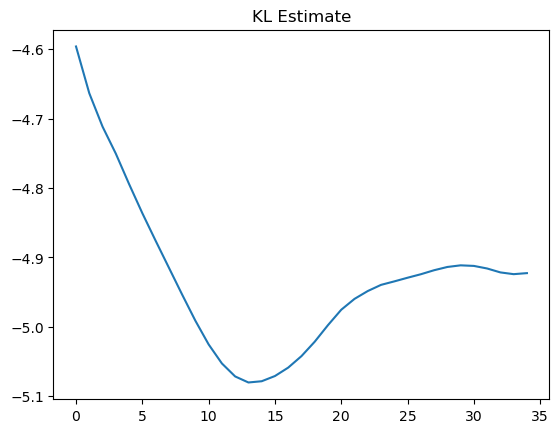

In [32]:
wass_kl_df = pd.DataFrame(np.array(KL_all))
plt.figure()
wass_kl_df.plot(title = 'KL Estimate', legend = False)

In [27]:
# Save the list of arrays to a file using np.save
np.save('Lambda_list_alpha.npy', Lambda_list)

In [ ]:
Lambda_list = np.load('Lambda_list_alpha_tau.npy', allow_pickle=True)

In [33]:
# Transform from original validation using transformations
wass_val_n_summary_statistics = (val_n_summary_statistics - scaler_mean) / scaler_std
for i in range(len(Lambda_list)):
    wass_val_n_summary_statistics = transform_auto(Lambda_list[i], wass_val_n_summary_statistics)[0]
    transformed_val_n_summary_statistics = wass_val_n_summary_statistics

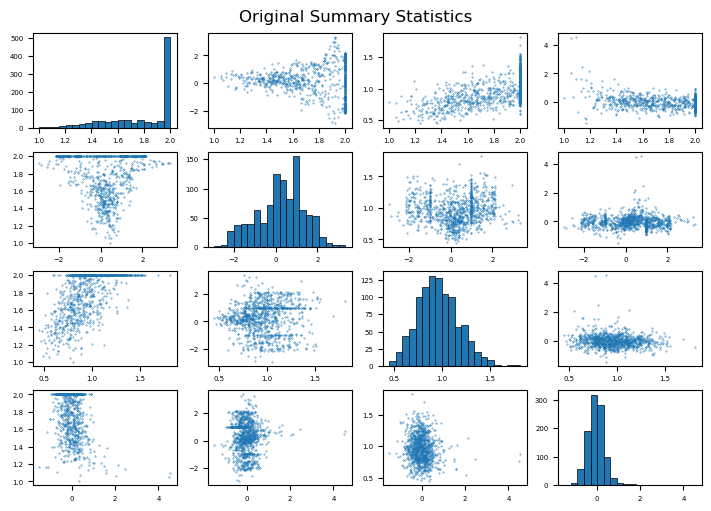

In [34]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(4, 4, figsize=(7,5), constrained_layout=True)

# For Sine Function
for x in range(4):
    for y in range(4):
        if x != y:
            axis[x, y].scatter(val_n_summary_statistics[:1000,x], val_n_summary_statistics[:1000,y], s = 0.1)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)
        else:
            axis[x, y].hist(val_n_summary_statistics[:1000,x], bins = 20, edgecolor='black', linewidth=0.5)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# Combine all the operations and display
figure.suptitle('Original Summary Statistics')
plt.show()


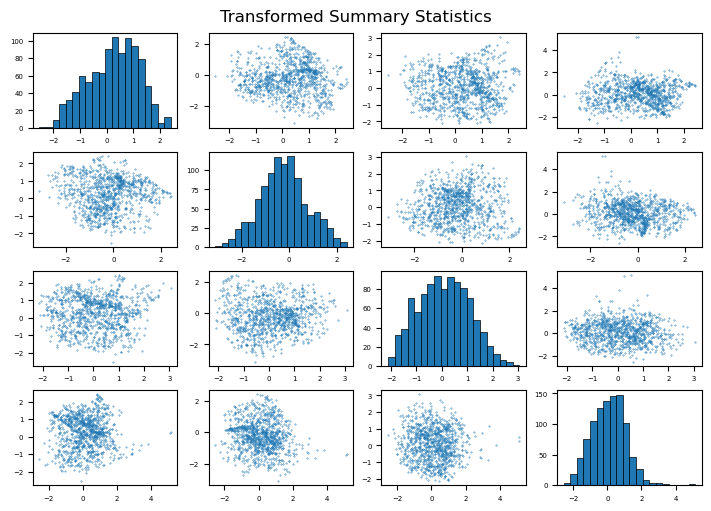

In [35]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(4, 4, figsize=(7,5), constrained_layout=True)

# For Sine Function
for x in range(4):
    for y in range(4):
        if x != y:
            axis[x, y].scatter(wass_val_n_summary_statistics[:1000,x], wass_val_n_summary_statistics[:1000,y], s = 0.1)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)
        else:
            axis[x, y].hist(wass_val_n_summary_statistics[:1000,x], bins = 20, edgecolor='black', linewidth=0.5)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# Combine all the operations and display
figure.suptitle('Transformed Summary Statistics')
plt.show()

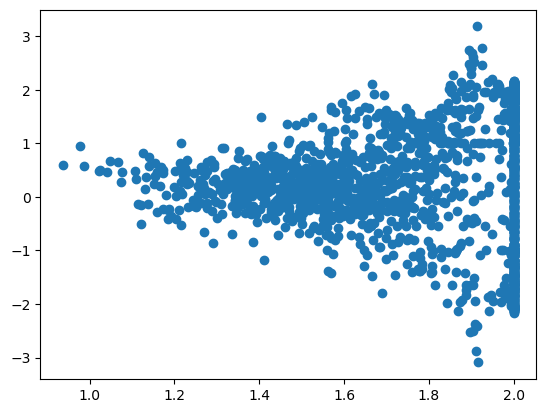

In [110]:
plt.scatter(val_n_summary_statistics[:2000,0], val_n_summary_statistics[:2000,1])

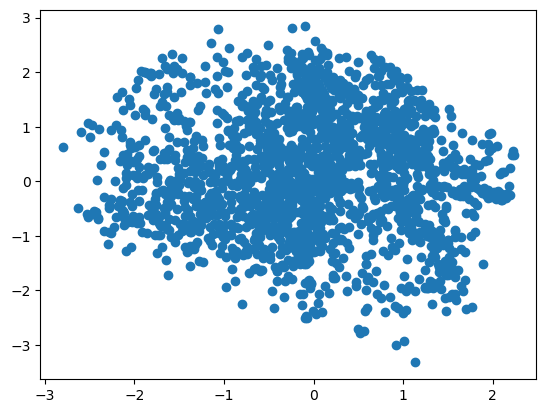

In [111]:
plt.scatter(wass_val_n_summary_statistics[:2000,0], wass_val_n_summary_statistics[:2000,1])

In [36]:
def normality_test(array1, array2):
    from scipy.stats import mstats
    multivariate_data = np.hstack((array1, array2))
    # Perform Mardia's multivariate normality test
    test_statistic, p_value = mstats.normaltest(multivariate_data)

    # Set the significance level (alpha)
    alpha = 0.01

    # Interpret the results for array
    if p_value < alpha:
      if p_value == 0.0:
        min_p_value = np.finfo(float).tiny
        # Calculate the p-value, ensuring it's not smaller than the minimum
        p_value = max(np.finfo(float).eps, min_p_value)
        print(f"The data is not multivariate normally distributed (p-value = {p_value})")
      else:
        print(f"The data is not multivariate normally distributed (p-value = {p_value})")
    else:
        print(f"The data appears to be multivariate normally distributed (p-value = {p_value})")

# Define a function to remove outliers based on IQR
def remove_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 2 * IQR # 2 times the standard deviation of the data
    upper_bound = Q3 + 2 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]

# For original summary statistics
normality_test(val_n_summary_statistics[:,0], val_n_summary_statistics[:,1])
normality_test(val_n_summary_statistics[:,2], val_n_summary_statistics[:,3])
normality_test(val_n_summary_statistics[:,1], val_n_summary_statistics[:,3])
normality_test(val_n_summary_statistics[:,0], val_n_summary_statistics[:,3])

# For transformed summary statistics
# Remove outliers
array1 = remove_outliers_iqr(transformed_val_n_summary_statistics[:,0])
array2 = remove_outliers_iqr(transformed_val_n_summary_statistics[:,1])
array3 = remove_outliers_iqr(transformed_val_n_summary_statistics[:,2])
array4 = remove_outliers_iqr(transformed_val_n_summary_statistics[:,3])

normality_test(array1, array2)
normality_test(array3, array4)
normality_test(array2, array4)
normality_test(array1, array4)

The data is not multivariate normally distributed (p-value = 2.220446049250313e-16)
The data is not multivariate normally distributed (p-value = 3.405259601930881e-48)
The data is not multivariate normally distributed (p-value = 1.2170854334799445e-64)
The data is not multivariate normally distributed (p-value = 2.220446049250313e-16)
The data is not multivariate normally distributed (p-value = 5.3518963597479944e-98)
The data is not multivariate normally distributed (p-value = 5.581965928614938e-69)
The data is not multivariate normally distributed (p-value = 4.397742255037376e-20)
The data is not multivariate normally distributed (p-value = 3.921735488407673e-96)


In [ ]:
def nf_transform(Lambda_list, n_summary_statistics):
    n_summary_statistics = (n_summary_statistics - scaler_mean) / scaler_std
    for i in range(len(Lambda_list)):
        n_summary_statistics = transform_auto(Lambda_list[i], n_summary_statistics)[0]
    return n_summary_statistics

In [ ]:
## Transform actual data
transformed_actual_summary_statistics = nf_transform(Lambda_list, jnp.reshape(actual_summary_statistics, (1, len(actual_summary_statistics))))
transformed_actual_summary_statistics

## FIND THE BEST THETA (COEFFICIENTS) USING VB

In [59]:
def summary_statistics(theta, n_samples, n_datasets):
    datasets = normal_data(theta, n_samples, n_datasets)
    n_summary_statistics = jnp.array([normal_data_ss(datasets[i,:]) for i in range(n_datasets)])

    # Wasserstein transform
    transformed_summary_statistics = nf_transform(Lambda_list, n_summary_statistics)

    sample_mean = jnp.mean(transformed_summary_statistics, axis = 0)
    cov = jnp.cov(transformed_summary_statistics.T)
    sample_variance = cov + (jnp.eye(actual_summary_statistics.shape[0]) * 5 * 1e-7)
    # print(sample_variance)

    return sample_mean, sample_variance

In [60]:
def summary_statistics(theta, n_samples, num_datasets): ## EQ 6
    datasets = normal_data(theta, n_samples, num_datasets)
    n_summary_statistics = jnp.array([normal_data_ss(datasets[i,:]) for i in range(num_datasets)])

    # Wasserstein transform
    transformed_summary_statistics = nf_transform(Lambda_list, n_summary_statistics)

    sample_mean = jnp.mean(transformed_summary_statistics, axis = 0)
    # cov = jnp.cov(transformed_summary_statistics.T)
    # sample_variance = cov + (jnp.eye(cov.shape[0]) * 5 * 1e-7)
    sample_precision = 1/eps_precision * jnp.eye(actual_summary_statistics.shape[0])
    for i in range(num_datasets): ## It will have i ranging from 0 to N-1
        diff = transformed_summary_statistics[i] - sample_mean
        sample_precision = sample_precision - ((1 + diff.T @ sample_precision @ diff)**(-1)) * (sample_precision @ diff.reshape(-1, 1) @ diff.reshape(1, -1) @ sample_precision)
    sample_precision = sample_precision * num_datasets ##### IS IT NEEDED??
    return sample_mean, sample_precision

In [ ]:
def mean_adjustment_summary_statistics(adjusted_theta, n_samples, n_datasets):
    theta = adjusted_theta[0:num_coeffs]
    Gamma = adjusted_theta[-num_latent:]
    sample_mean, sample_variance = summary_statistics(theta, n_samples, n_datasets)

    adjusted_sample_mean = sample_mean + jnp.diag(jnp.sqrt(sample_variance)) * Gamma
    return adjusted_sample_mean, sample_variance

In [61]:
def mean_adjustment_summary_statistics(adjusted_theta, n_samples, n_datasets):
    theta = adjusted_theta[0:num_coeffs]
    Gamma = adjusted_theta[-num_latent:]
    sample_mean, sample_precision = summary_statistics(theta, n_samples, n_datasets)
    # inverse_sample_precision = 1/n_datasets * eps_precision * jnp.eye(sample_variance.shape[0]) + sample_variance ############# USING EQ 4 to find inversion
    # adjusted_sample_mean = sample_mean + jnp.diag(jnp.sqrt(inverse_sample_precision)) * Gamma ## EQ 4
    # adjusted_sample_mean = sample_mean + ((jnp.diag(sample_precision))**(-1/2)) * Gamma ## EQ 4
    adjusted_sample_mean = sample_mean + (jnp.zeros((num_latent, num_latent)).at[jnp.diag_indices_from(sample_precision)].set(jnp.diag(sample_precision)**(-1/2))) @ Gamma
    return adjusted_sample_mean, sample_precision

In [62]:
@partial(jit, static_argnames=['sigma_theta','num_coeffs'])
def prior(theta, sigma_theta, num_coeffs):
    log_prior = multivariate_normal.logpdf(theta, mean = jnp.array([0] * num_coeffs), cov= sigma_theta * jnp.eye(num_coeffs))
    return log_prior

In [63]:
def mean_adjustment_unbiased_log_likelihood(gs_adjusted_theta, actual_summary_statistics, n_samples, num_datasets):
    mean_adjust_ss = mean_adjustment_summary_statistics(gs_adjusted_theta, n_samples, num_datasets)
    adjusted_sample_mean = mean_adjust_ss[0]
    sample_precision = mean_adjust_ss[1]
    # u_est_log_likelihood = multivariate_normal.logpdf(actual_summary_statistics, mean = adjusted_sample_mean, cov= inverse_sample_precision)

    diff_mean_s = actual_summary_statistics - adjusted_sample_mean
    part1 = diff_mean_s.T @ sample_precision @ diff_mean_s
    u_est_log_likelihood = 1/2 * jnp.linalg.slogdet(sample_precision)[1] - 1/2 * part1 #- num_coeffs/2 * jnp.log(2*np.pi) +
    return u_est_log_likelihood

In [64]:
@jit
def nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance):
    nuissance_mean_u_est_log_likelihood = multivariate_normal.logpdf(Gamma, mean = mean_nuissance, cov= variance_nuissance)
    return nuissance_mean_u_est_log_likelihood

In [65]:
@jit
def fun_log_q(theta, mu, l):
    log_q = multivariate_normal.logpdf(theta, mean = mu, cov= jnp.linalg.solve((l @ l.T), jnp.eye((l @ l.T).shape[0])))
    # log_q = scipy.stats.multivariate_normal.logpdf(np.array(theta), mean = np.array(mu), cov= np.array(jnp.linalg.solve((l @ l.T), jnp.eye((l @ l.T).shape[0]))), allow_singular = True)

    return log_q

In [66]:
@partial(jit, static_argnames=['num_coeffs'])
def gradient_log_q(theta, mu, l, num_coeffs): #indep theta
    gradient_log_q_mu = l @ l.T @ (theta - mu)
    # gradient_log_q_l = (np.diag(np.linalg.inv(l)) - np.matmul(((np.reshape(theta - mu, (num_coeffs,1))) * theta - mu), l)).T[np.triu_indices(num_coeffs)] #use * because matmul gives scalar
    diag_inv_l = jnp.zeros_like(l, shape=(num_coeffs,num_coeffs)).at[jnp.diag_indices_from(l)].set(jnp.diag(l))
    gradient_log_q_l = (diag_inv_l - jnp.reshape(theta - mu, (num_coeffs,1)) @ jnp.reshape(theta - mu, (1,num_coeffs)) @ l).T[jnp.triu_indices(num_coeffs)] #use * because matmul gives scalar
    return gradient_log_q_mu, gradient_log_q_l

In [67]:
@jit
def control_variates(Flat_grad_log_q, Flat_grad_lb):
    c = []
    stacked_gradient_lb = jnp.stack(Flat_grad_lb)
    stacked_gradient_log_q = jnp.stack(Flat_grad_log_q)
    for i in range(lambda_dim):
        sample_cov = jnp.cov(stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i])
        c_i = sample_cov[0, 1] / sample_cov[1, 1]
        c.append(c_i)
    c_mu = jnp.array(c[0:num_coeffs])
    c_vech_l = jnp.array(c[num_coeffs:])
    return c_mu, c_vech_l

In [68]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_coeffs = len(true_theta) # number of coeffs
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def fun_gradient_lb(self, theta_q, mu_q, l_q, c_mu, c_l):

        ss_q = summary_statistics(theta_q, n_samples, num_datasets)
        sample_mean_q = ss_q[0]
        sample_precision_q = ss_q[1]
        # inverse_sample_precision_q = 1/num_datasets * eps_precision * jnp.eye(sample_variance_q.shape[0]) + sample_variance_q

        # Nuissance mean and variance: PAGE 9
        # diag_precision = jnp.zeros((num_latent, num_latent)).at[jnp.diag_indices_from(inverse_sample_precision_q)].set(jnp.diag(jnp.sqrt(inverse_sample_precision_q)))
        diag_precision = jnp.zeros((num_latent, num_latent)).at[jnp.diag_indices_from(sample_precision_q)].set(jnp.diag(sample_precision_q)**(-1/2))
        # mean_nuissance_p1_non_inv = jnp.identity(num_latent) / sigma_latent + jnp.diag(sample_variance_q).T @ jnp.linalg.solve(sample_variance_q, jnp.diag(sample_variance_q))
        mean_nuissance_p1_non_inv = jnp.identity(num_latent) / sigma_latent + diag_precision.T @ sample_precision_q @ diag_precision
        mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))
        # mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))

        diff_mean = self.actual_summary_statistics - sample_mean_q
        mean_nuissance_p2 = diag_precision @ sample_precision_q @ diff_mean
        mean_nuissance_q = mean_nuissance_p1 @ mean_nuissance_p2
        variance_nuissance_q = mean_nuissance_p1
        # print(variance_nuissance_q)

        # Generate Gamma

        Gamma = random.multivariate_normal(key2, mean = mean_nuissance_q, cov = variance_nuissance_q)
        adjusted_theta_q = jnp.concatenate((theta_q, Gamma))

        # Find gradient of LB
        llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_q, self.actual_summary_statistics, n_samples, num_datasets)
        llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance_q, variance_nuissance_q)

        # print(llh_gamma)
        # print(prior(Gamma, sigma_latent, num_latent))

        h_lambda = prior(theta_q, sigma_theta, num_coeffs) + prior(Gamma, sigma_latent, num_latent) + llh - fun_log_q(theta_q, mu_q, l_q) - llh_gamma

        # Find gradient of LB
        grad_log_q_mu, grad_log_q_l = gradient_log_q(theta_q, mu_q, l_q, num_coeffs)
        gradient_lb_mu = grad_log_q_mu * (h_lambda - c_mu)
        gradient_lb_l = grad_log_q_l * (h_lambda - c_l)
        # Calculate control variates
        flattened_gradient_log_q = jnp.concatenate((grad_log_q_mu, grad_log_q_l), axis = None)
        flattened_gradient_lb = jnp.concatenate((gradient_lb_mu, gradient_lb_l), axis = None)

        return gradient_lb_mu, gradient_lb_l, h_lambda, flattened_gradient_log_q, flattened_gradient_lb

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        mu_0 = jnp.array([0])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        # mu_0 = np.array([0] * self.num_coeffs)
        l_0 = jnp.tril(jnp.identity(self.num_coeffs) * 100)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = jnp.linalg.solve(Sigma_0_inv, jnp.eye(Sigma_0_inv.shape[0]))
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[jnp.triu_indices(self.num_coeffs)]

        # Initilize best lambda
        lambda_best_mu = mu_0
        lambda_best_l = vech_l0
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []

        func_auto = vmap(self.fun_gradient_lb, in_axes=[0, None, None, None, None])

        for t in tqdm(range(stop)):
            if t == 0:
                # Draw samples of theta from  variational q
                # List of gradients
                theta_0_samples = random.multivariate_normal(subkeys[t], mean = mu_0, cov = Sigma_0, shape = (self.samples,))
                gradient_lb_mu_0, gradient_lb_l_0, lb_0, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_0_samples, mu_0, l_0, 0, 0)
                # Calculate control variates using all samples
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_mu_init = jnp.mean(gradient_lb_mu_0, axis = 0)
                self.g_vech_l_init = jnp.mean(gradient_lb_l_0, axis = 0)
                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None)) > self.l_threshold:
                    self.g_mu_init = self.l_threshold * self.g_mu_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                    self.g_vech_l_init = self.l_threshold * self.g_vech_l_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                self.v_mu_init = self.g_mu_init ** 2
                self.v_vech_l_init = self.g_vech_l_init ** 2
                # Calculate lower bound
                LB_all.append(jnp.mean(lb_0))
                print('LB', (jnp.mean(lb_0)))
                lambda_q_mu = mu_0
                lambda_q_l = vech_l0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q_mu

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q_l)
                l_q = jnp.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q = l_q.at[i:self.num_coeffs,i].set(vech_lq[:self.num_coeffs - i])
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  jnp.linalg.solve(Sigma_q_inv, jnp.eye(Sigma_q_inv.shape[0]))
                l_q_inv =  jnp.linalg.solve(l_q, jnp.eye(l_q.shape[0]))
                # List of gradients
                Gradient_lb = []
                lb_t = []
                theta_q_samples = random.multivariate_normal(subkeys[t], mean = mu_q, cov = Sigma_q, shape = (self.samples,))
                gradient_lb_mu, gradient_lb_l, lb_t, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_q_samples, mu_q, l_q, c_mu, c_vech_l)

                # Update control variates
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                g_mu_t = jnp.mean(gradient_lb_mu, axis = 0)
                g_vech_l_t = jnp.mean(gradient_lb_l, axis = 0)
                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None)) > self.l_threshold:
                    g_mu_t = self.l_threshold * g_mu_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                    g_vech_l_t = self.l_threshold * g_vech_l_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                v_mu_t = g_mu_t ** 2
                v_vech_l_t = g_vech_l_t ** 2
                #---- Update lambda
                self.g_mu_init = self.adaptive_lr_1 * self.g_mu_init + (1 - self.adaptive_lr_1) * g_mu_t
                self.g_vech_l_init = self.adaptive_lr_1 * self.g_vech_l_init + (1 - self.adaptive_lr_1) * g_vech_l_t

                self.v_mu_init = self.adaptive_lr_2 * self.v_mu_init + (1 - self.adaptive_lr_2) * v_mu_t
                self.v_vech_l_init = self.adaptive_lr_2 * self.v_vech_l_init + (1 - self.adaptive_lr_2) * v_vech_l_t

                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q_mu = lambda_q_mu + update_t * self.g_mu_init / (self.v_mu_init ** 0.5)
                lambda_q_l = lambda_q_l + update_t * self.g_vech_l_init / (self.v_vech_l_init ** 0.5)
                # Calculate lower bound
                LB_all.append(jnp.mean(lb_t))
                print(lambda_q_mu)
                if t < self.t_w:
                    print('LB', jnp.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = jnp.mean(jnp.array(LB_all[t - self.t_w + 1 : t]))
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= jnp.max(jnp.array(LB_Smoothed)):
                        patience = 0
                        lambda_best_mu = lambda_q_mu
                        lambda_best_l = lambda_q_l
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best_mu, lambda_best_l

In [69]:
# Set hyperparameters
stop = 4000

In [70]:
vb = GVB(200, transformed_actual_summary_statistics[0], 0.005, 2500, 100, 0.9, 0.9, 100, 25)
LB_estimate, smoothed_LB_estimate, best_lambda_mu, best_lambda_l = vb.vb_posterior(stop)

  0%|          | 1/4000 [00:49<54:31:06, 49.08s/it]

LB -6.8263254


  0%|          | 2/4000 [01:31<49:56:59, 44.98s/it]

[-0.0047431]
LB -6.9631467


  0%|          | 3/4000 [02:17<50:37:46, 45.60s/it]

[-0.0094177]
LB -6.8678207


  0%|          | 4/4000 [03:10<54:02:18, 48.68s/it]

[-0.01385299]
LB -6.790633


  0%|          | 5/4000 [03:54<52:02:37, 46.90s/it]

[-0.01759935]
LB -6.8400803


  0%|          | 6/4000 [04:43<52:53:34, 47.68s/it]

[-0.02115332]
LB -6.871365


  0%|          | 7/4000 [05:26<51:08:05, 46.10s/it]

[-0.02466499]
LB -6.834767


  0%|          | 8/4000 [06:09<49:55:02, 45.02s/it]

[-0.02799669]
LB -6.8601184


  0%|          | 9/4000 [06:50<48:34:41, 43.82s/it]

[-0.03038524]
LB -6.861943


  0%|          | 10/4000 [07:30<47:22:53, 42.75s/it]

[-0.03265131]
LB -6.8162637


  0%|          | 11/4000 [08:11<46:38:36, 42.09s/it]

[-0.0348709]
LB -6.835189


  0%|          | 12/4000 [08:52<46:10:00, 41.68s/it]

[-0.03697656]
LB -6.82781


  0%|          | 13/4000 [09:38<47:32:57, 42.93s/it]

[-0.03897379]
LB -6.832589


  0%|          | 14/4000 [10:22<48:07:52, 43.47s/it]

[-0.0408684]
LB -6.7962856


  0%|          | 15/4000 [11:14<50:41:58, 45.80s/it]

[-0.04277303]
LB -6.8059278


  0%|          | 16/4000 [11:58<50:15:17, 45.41s/it]

[-0.04457941]
LB -6.8122454


  0%|          | 17/4000 [12:38<48:25:46, 43.77s/it]

[-0.04635092]
LB -6.7899866


  0%|          | 18/4000 [13:19<47:20:41, 42.80s/it]

[-0.04803183]
LB -6.737061


  0%|          | 19/4000 [14:00<46:44:51, 42.27s/it]

[-0.04970197]
LB -6.7701373


  0%|          | 20/4000 [14:39<45:50:01, 41.46s/it]

[-0.05128736]
LB -6.841897


  1%|          | 21/4000 [15:20<45:30:09, 41.17s/it]

[-0.05282867]
LB -6.8040195


  1%|          | 22/4000 [16:00<45:13:49, 40.93s/it]

[-0.05429154]
LB -6.7955465


  1%|          | 23/4000 [16:40<44:59:54, 40.73s/it]

[-0.05557217]
LB -6.709264


  1%|          | 24/4000 [17:22<45:22:03, 41.08s/it]

[-0.05678612]
LB -6.8292294


  1%|          | 25/4000 [18:04<45:33:50, 41.27s/it]

[-0.05762305]
LB -6.8846264


  1%|          | 26/4000 [18:44<45:18:43, 41.05s/it]

[-0.05841511]
LB -6.8109784


  1%|          | 27/4000 [19:25<45:17:23, 41.04s/it]

[-0.05869098]
LB -6.8191476


  1%|          | 28/4000 [20:07<45:26:44, 41.19s/it]

[-0.0589515]
LB -6.81053


  1%|          | 29/4000 [20:48<45:32:36, 41.29s/it]

[-0.05969423]
LB -6.879326


  1%|          | 30/4000 [21:30<45:28:44, 41.24s/it]

[-0.06039891]
LB -6.8406067


  1%|          | 31/4000 [22:11<45:30:24, 41.28s/it]

[-0.0607531]
LB -6.7791615


  1%|          | 32/4000 [22:56<46:44:43, 42.41s/it]

[-0.06108468]
LB -6.767904


  1%|          | 33/4000 [23:36<46:04:34, 41.81s/it]

[-0.05968952]
LB -6.763363


  1%|          | 34/4000 [24:21<47:06:10, 42.76s/it]

[-0.05836558]
LB -6.7617373


  1%|          | 35/4000 [25:03<46:50:24, 42.53s/it]

[-0.05886774]
LB -6.7891903


  1%|          | 36/4000 [25:47<47:05:17, 42.76s/it]

[-0.05934413]
LB -6.8149133


  1%|          | 37/4000 [26:29<47:01:57, 42.72s/it]

[-0.06051486]
LB -6.8889084


  1%|          | 38/4000 [27:13<47:21:23, 43.03s/it]

[-0.06162654]
LB -6.8221483


  1%|          | 39/4000 [27:56<47:11:57, 42.90s/it]

[-0.0630498]
LB -6.781239


  1%|          | 40/4000 [28:37<46:42:53, 42.47s/it]

[-0.06440004]
LB -6.7942686


  1%|          | 41/4000 [29:24<48:12:20, 43.83s/it]

[-0.06550851]
LB -6.6592917


  1%|          | 42/4000 [30:09<48:22:54, 44.01s/it]

[-0.06655962]
LB -6.744403


  1%|          | 43/4000 [30:52<48:09:20, 43.81s/it]

[-0.0674696]
LB -6.7551446


  1%|          | 44/4000 [31:33<47:22:50, 43.12s/it]

[-0.06833292]
LB -6.8527203


  1%|          | 45/4000 [32:16<47:21:06, 43.10s/it]

[-0.06892405]
LB -6.8301263


  1%|          | 46/4000 [32:59<47:06:03, 42.88s/it]

[-0.06948529]
LB -6.790792


  1%|          | 47/4000 [33:40<46:38:29, 42.48s/it]

[-0.07015684]
LB -6.8541565


  1%|          | 48/4000 [34:23<46:31:33, 42.38s/it]

[-0.07079501]
LB -6.7647934


  1%|          | 49/4000 [35:04<46:21:20, 42.24s/it]

[-0.07182858]
LB -6.749719


  1%|▏         | 50/4000 [35:46<46:07:39, 42.04s/it]

[-0.07280893]
LB -6.784208


  1%|▏         | 51/4000 [36:27<45:49:41, 41.78s/it]

[-0.0721425]
LB -6.8245745


  1%|▏         | 52/4000 [37:10<46:05:20, 42.03s/it]

[-0.07150999]
LB -6.7123857


  1%|▏         | 53/4000 [37:52<46:17:25, 42.22s/it]

[-0.0701568]
LB -6.778861


  1%|▏         | 54/4000 [38:34<46:07:52, 42.09s/it]

[-0.06887297]
LB -6.8308086


  1%|▏         | 55/4000 [39:16<46:07:02, 42.08s/it]

[-0.07015166]
LB -6.7530746


  1%|▏         | 56/4000 [40:03<47:28:49, 43.34s/it]

[-0.0713647]
LB -6.83788


  1%|▏         | 57/4000 [40:45<47:16:07, 43.16s/it]

[-0.0726535]
LB -6.775383


  1%|▏         | 58/4000 [41:29<47:33:40, 43.44s/it]

[-0.07387608]
LB -6.7985864


  1%|▏         | 59/4000 [41:57<42:23:15, 38.72s/it]

[-0.07475474]
LB -6.847959


  2%|▏         | 60/4000 [42:24<38:29:55, 35.18s/it]

[-0.07558835]
LB -6.8330393


  2%|▏         | 61/4000 [42:51<35:45:42, 32.68s/it]

[-0.0763454]
LB -6.735038


  2%|▏         | 62/4000 [43:17<33:35:14, 30.70s/it]

[-0.07706363]
LB -6.775044


  2%|▏         | 63/4000 [43:44<32:17:57, 29.53s/it]

[-0.0777391]
LB -6.790724


  2%|▏         | 64/4000 [44:10<31:10:20, 28.51s/it]

[-0.07837974]
LB -6.80551


  2%|▏         | 65/4000 [44:36<30:25:59, 27.84s/it]

[-0.07896814]
LB -6.7881055


  2%|▏         | 66/4000 [45:03<30:08:05, 27.58s/it]

[-0.07952632]
LB -6.7817917


  2%|▏         | 67/4000 [45:34<31:18:55, 28.66s/it]

[-0.08008759]
LB -6.7365923


  2%|▏         | 68/4000 [46:02<31:00:32, 28.39s/it]

[-0.08062016]
LB -6.729077


  2%|▏         | 69/4000 [46:29<30:39:53, 28.08s/it]

[-0.08132982]
LB -6.8094807


  2%|▏         | 70/4000 [46:58<30:44:18, 28.16s/it]

[-0.08200283]
LB -6.7673717


  2%|▏         | 71/4000 [47:26<30:45:46, 28.19s/it]

[-0.08252692]
LB -6.801822


  2%|▏         | 72/4000 [47:55<31:02:52, 28.46s/it]

[-0.08302412]
LB -6.8579345


  2%|▏         | 73/4000 [48:24<31:02:49, 28.46s/it]

[-0.08376684]
LB -6.7820797


  2%|▏         | 74/4000 [48:53<31:21:46, 28.76s/it]

[-0.08447146]
LB -6.7920294


  2%|▏         | 75/4000 [49:22<31:28:52, 28.87s/it]

[-0.08507153]
LB -6.7636437


  2%|▏         | 76/4000 [49:53<31:59:51, 29.36s/it]

[-0.0856408]
LB -6.698441


  2%|▏         | 77/4000 [50:23<32:08:53, 29.50s/it]

[-0.08607416]
LB -6.8473783


  2%|▏         | 78/4000 [50:53<32:27:48, 29.80s/it]

[-0.08648532]
LB -6.7388315


  2%|▏         | 79/4000 [51:23<32:28:09, 29.81s/it]

[-0.08682885]
LB -6.7351737


  2%|▏         | 80/4000 [51:54<33:00:39, 30.32s/it]

[-0.08715461]
LB -6.7379565


  2%|▏         | 81/4000 [52:24<32:49:26, 30.15s/it]

[-0.0877226]
LB -6.800399


  2%|▏         | 82/4000 [52:55<32:55:27, 30.25s/it]

[-0.08826112]
LB -6.7762094


  2%|▏         | 83/4000 [53:24<32:44:59, 30.10s/it]

[-0.08874313]
LB -6.7706285


  2%|▏         | 84/4000 [53:55<32:54:07, 30.25s/it]

[-0.08920035]
LB -6.8045926


  2%|▏         | 85/4000 [54:25<32:41:02, 30.05s/it]

[-0.08973181]
LB -6.770762


  2%|▏         | 86/4000 [54:55<32:55:09, 30.28s/it]

[-0.09023602]
LB -6.7805667


  2%|▏         | 87/4000 [55:25<32:43:50, 30.11s/it]

[-0.09074737]
LB -6.7843018


  2%|▏         | 88/4000 [55:56<32:58:21, 30.34s/it]

[-0.09123285]
LB -6.696461


  2%|▏         | 89/4000 [56:25<32:37:47, 30.04s/it]

[-0.09187164]
LB -6.7076907


  2%|▏         | 90/4000 [56:58<33:23:29, 30.74s/it]

[-0.09247781]
LB -6.7964964


  2%|▏         | 91/4000 [57:28<33:07:56, 30.51s/it]

[-0.09302554]
LB -6.7449408


  2%|▏         | 92/4000 [58:01<33:57:32, 31.28s/it]

[-0.09354524]
LB -6.7765503


  2%|▏         | 93/4000 [58:35<34:47:09, 32.05s/it]

[-0.0940477]
LB -6.7574005


  2%|▏         | 94/4000 [59:08<35:09:49, 32.41s/it]

[-0.09452401]
LB -6.807346


  2%|▏         | 95/4000 [59:48<37:49:55, 34.88s/it]

[-0.09482791]
LB -6.7673364


  2%|▏         | 96/4000 [1:00:22<37:24:06, 34.49s/it]

[-0.09511618]
LB -6.712797


  2%|▏         | 97/4000 [1:01:03<39:31:31, 36.46s/it]

[-0.09535544]
LB -6.778499


  2%|▏         | 98/4000 [1:01:38<39:01:42, 36.01s/it]

[-0.09558316]
LB -6.819662


  2%|▏         | 99/4000 [1:02:14<39:08:23, 36.12s/it]

[-0.09595121]
LB -6.779977


  2%|▎         | 100/4000 [1:02:50<38:57:27, 35.96s/it]

[-0.09630091]
LB -6.7387366


  3%|▎         | 101/4000 [1:03:25<38:39:46, 35.70s/it]

[-0.09674043]
LB Smoothed -6.7931786


  3%|▎         | 102/4000 [1:04:03<39:19:32, 36.32s/it]

[-0.097159]
LB Smoothed -6.790287


  3%|▎         | 103/4000 [1:04:39<39:09:21, 36.17s/it]

[-0.09626621]
LB Smoothed -6.78925


  3%|▎         | 104/4000 [1:05:17<39:42:31, 36.69s/it]

[-0.0954191]
LB Smoothed -6.7891927


  3%|▎         | 105/4000 [1:05:53<39:41:15, 36.68s/it]

[-0.09367906]
LB Smoothed -6.787909


  3%|▎         | 106/4000 [1:06:29<39:18:28, 36.34s/it]

[-0.09202816]
LB Smoothed -6.787197


  3%|▎         | 107/4000 [1:07:06<39:29:16, 36.52s/it]

[-0.08998213]
LB Smoothed -6.786339


  3%|▎         | 108/4000 [1:07:41<38:58:31, 36.05s/it]

[-0.08804107]
LB Smoothed -6.785167


  3%|▎         | 109/4000 [1:08:16<38:34:41, 35.69s/it]

[-0.08608443]
LB Smoothed -6.78347


  3%|▎         | 110/4000 [1:08:51<38:37:05, 35.74s/it]

[-0.08422819]
LB Smoothed -6.7821503


  3%|▎         | 111/4000 [1:09:27<38:41:23, 35.81s/it]

[-0.08243185]
LB Smoothed -6.780933


  3%|▎         | 112/4000 [1:10:04<38:55:23, 36.04s/it]

[-0.08072772]
LB Smoothed -6.7806716


  3%|▎         | 113/4000 [1:10:38<38:10:35, 35.36s/it]

[-0.07907176]
LB Smoothed -6.7804737


  3%|▎         | 114/4000 [1:11:13<38:04:24, 35.27s/it]

[-0.07750093]
LB Smoothed -6.780698


  3%|▎         | 115/4000 [1:11:51<39:02:32, 36.18s/it]

[-0.07608556]
LB Smoothed -6.780484


  3%|▎         | 116/4000 [1:12:31<40:21:21, 37.41s/it]

[-0.07474293]
LB Smoothed -6.7793956


  3%|▎         | 117/4000 [1:13:09<40:30:09, 37.55s/it]

[-0.07419661]
LB Smoothed -6.7786417


  3%|▎         | 118/4000 [1:13:47<40:35:05, 37.64s/it]

[-0.0736784]
LB Smoothed -6.778737


  3%|▎         | 119/4000 [1:14:26<40:57:42, 38.00s/it]

[-0.07313374]
LB Smoothed -6.778121


  3%|▎         | 120/4000 [1:15:04<41:03:38, 38.10s/it]

[-0.07261711]
LB Smoothed -6.778584


  3%|▎         | 121/4000 [1:15:44<41:27:12, 38.47s/it]

[-0.07205368]
LB Smoothed -6.778402


  3%|▎         | 122/4000 [1:16:23<41:51:14, 38.85s/it]

[-0.07151902]
LB Smoothed -6.7776546


  3%|▎         | 123/4000 [1:16:59<40:46:52, 37.87s/it]

[-0.07104646]
LB Smoothed -6.777842


  3%|▎         | 124/4000 [1:17:34<39:55:43, 37.09s/it]

[-0.07059824]
LB Smoothed -6.7778134


  3%|▎         | 125/4000 [1:18:12<40:17:05, 37.43s/it]

[-0.07016243]
LB Smoothed -6.777555


  3%|▎         | 126/4000 [1:18:53<41:12:04, 38.29s/it]

[-0.06974924]
LB Smoothed -6.777525


  3%|▎         | 127/4000 [1:19:26<39:35:18, 36.80s/it]

[-0.06924361]
LB Smoothed -6.7774386


  3%|▎         | 128/4000 [1:19:59<38:25:24, 35.72s/it]

[-0.06876393]
LB Smoothed -6.7767777


  3%|▎         | 129/4000 [1:20:35<38:32:32, 35.84s/it]

[-0.06838486]
LB Smoothed -6.7765865


  3%|▎         | 130/4000 [1:21:10<38:07:05, 35.46s/it]

[-0.0680254]
LB Smoothed -6.776361


  3%|▎         | 131/4000 [1:21:47<38:28:27, 35.80s/it]

[-0.06793714]
LB Smoothed -6.776668


  3%|▎         | 132/4000 [1:22:24<38:55:24, 36.23s/it]

[-0.06785326]
LB Smoothed -6.776134


  3%|▎         | 133/4000 [1:23:01<39:08:20, 36.44s/it]

[-0.06777776]
LB Smoothed -6.7774897


  3%|▎         | 134/4000 [1:23:33<37:51:44, 35.26s/it]

[-0.06770651]
LB Smoothed -6.778325


  3%|▎         | 135/4000 [1:24:06<37:07:44, 34.58s/it]

[-0.06809366]
LB Smoothed -6.778061


  3%|▎         | 136/4000 [1:24:37<35:47:22, 33.34s/it]

[-0.06846062]
LB Smoothed -6.778104


  3%|▎         | 137/4000 [1:25:07<34:51:19, 32.48s/it]

[-0.0687447]
LB Smoothed -6.7771316


  3%|▎         | 138/4000 [1:25:40<34:49:45, 32.47s/it]

[-0.06901467]
LB Smoothed -6.777022


  3%|▎         | 139/4000 [1:26:11<34:28:56, 32.15s/it]

[-0.06912951]
LB Smoothed -6.776586


  4%|▎         | 140/4000 [1:26:41<33:51:53, 31.58s/it]

[-0.06923885]
LB Smoothed -6.777104


  4%|▎         | 141/4000 [1:27:14<34:16:55, 31.98s/it]

[-0.0688872]
LB Smoothed -6.777743


  4%|▎         | 142/4000 [1:27:47<34:30:15, 32.20s/it]

[-0.06855311]
LB Smoothed -6.778462


  4%|▎         | 143/4000 [1:28:19<34:30:47, 32.21s/it]

[-0.06695975]
LB Smoothed -6.778303


  4%|▎         | 144/4000 [1:28:51<34:18:22, 32.03s/it]

[-0.06544848]
LB Smoothed -6.777482


  4%|▎         | 145/4000 [1:29:24<34:48:35, 32.51s/it]

[-0.06416418]
LB Smoothed -6.7759337


  4%|▎         | 146/4000 [1:30:00<35:49:32, 33.46s/it]

[-0.06294578]
LB Smoothed -6.775652


  4%|▎         | 147/4000 [1:30:33<35:46:29, 33.43s/it]

[-0.0618762]
LB Smoothed -6.7750053


  4%|▎         | 148/4000 [1:31:07<35:53:58, 33.55s/it]

[-0.06086146]
LB Smoothed -6.7753363


  4%|▎         | 149/4000 [1:31:40<35:44:03, 33.41s/it]

[-0.05989379]
LB Smoothed -6.7761207


  4%|▍         | 150/4000 [1:32:15<36:07:01, 33.77s/it]

[-0.05897572]
LB Smoothed -6.7768025


  4%|▍         | 151/4000 [1:32:53<37:37:28, 35.19s/it]

[-0.05822477]
LB Smoothed -6.7754745


  4%|▍         | 152/4000 [1:33:33<39:02:15, 36.52s/it]

[-0.05751242]
LB Smoothed -6.775749


  4%|▍         | 153/4000 [1:34:13<40:09:25, 37.58s/it]

[-0.05699707]
LB Smoothed -6.7753468


  4%|▍         | 154/4000 [1:34:56<41:55:52, 39.25s/it]

[-0.05650813]
LB Smoothed -6.7742205


  4%|▍         | 155/4000 [1:35:37<42:20:40, 39.65s/it]

[-0.0560325]
LB Smoothed -6.7755213


  4%|▍         | 156/4000 [1:36:20<43:25:45, 40.67s/it]

[-0.05558086]
LB Smoothed -6.7757144


  4%|▍         | 157/4000 [1:37:04<44:39:14, 41.83s/it]

[-0.0550588]
LB Smoothed -6.7757134


  4%|▍         | 158/4000 [1:37:49<45:25:33, 42.56s/it]

[-0.05456336]
LB Smoothed -6.7758474


  4%|▍         | 159/4000 [1:38:32<45:44:55, 42.88s/it]

[-0.05345875]
LB Smoothed -6.775711


  4%|▍         | 160/4000 [1:39:19<46:54:24, 43.98s/it]

[-0.05241101]
LB Smoothed -6.775498


  4%|▍         | 161/4000 [1:40:01<46:19:36, 43.44s/it]

[-0.05242144]
LB Smoothed -6.7749963


  4%|▍         | 162/4000 [1:40:44<46:04:48, 43.22s/it]

[-0.05243146]
LB Smoothed -6.7741833


  4%|▍         | 163/4000 [1:41:25<45:36:01, 42.78s/it]

[-0.05281091]
LB Smoothed -6.7740464


  4%|▍         | 164/4000 [1:42:09<45:42:40, 42.90s/it]

[-0.05317136]
LB Smoothed -6.7730274


  4%|▍         | 165/4000 [1:42:50<45:03:48, 42.30s/it]

[-0.05338317]
LB Smoothed -6.7730207


  4%|▍         | 166/4000 [1:43:31<44:39:58, 41.94s/it]

[-0.05358375]
LB Smoothed -6.772842


  4%|▍         | 167/4000 [1:44:13<44:40:02, 41.95s/it]

[-0.05383972]
LB Smoothed -6.77343


  4%|▍         | 168/4000 [1:44:54<44:27:58, 41.77s/it]

[-0.05408275]
LB Smoothed -6.7740793


  4%|▍         | 169/4000 [1:45:35<44:13:20, 41.56s/it]

[-0.05386421]
LB Smoothed -6.774308


  4%|▍         | 170/4000 [1:46:20<45:09:27, 42.45s/it]

[-0.05365666]
LB Smoothed -6.7744155


  4%|▍         | 171/4000 [1:47:02<45:07:20, 42.42s/it]

[-0.05352242]
LB Smoothed -6.7737765


  4%|▍         | 172/4000 [1:47:45<45:15:18, 42.56s/it]

[-0.05339562]
LB Smoothed -6.772514


  4%|▍         | 173/4000 [1:48:26<44:50:35, 42.18s/it]

[-0.05270976]
LB Smoothed -6.7730246


  4%|▍         | 174/4000 [1:49:07<44:31:00, 41.89s/it]

[-0.05205983]
LB Smoothed -6.7730255


  4%|▍         | 175/4000 [1:49:50<44:45:39, 42.13s/it]

[-0.05159646]
LB Smoothed -6.773673


  4%|▍         | 176/4000 [1:50:31<44:26:46, 41.84s/it]

[-0.051157]
LB Smoothed -6.7755375


  4%|▍         | 177/4000 [1:51:14<44:47:20, 42.18s/it]

[-0.05091963]
LB Smoothed -6.7741823


  4%|▍         | 178/4000 [1:51:58<45:20:01, 42.70s/it]

[-0.05069349]
LB Smoothed -6.7743487


  4%|▍         | 179/4000 [1:52:38<44:33:29, 41.98s/it]

[-0.05059789]
LB Smoothed -6.7743387


  4%|▍         | 180/4000 [1:53:22<44:55:55, 42.34s/it]

[-0.05050674]
LB Smoothed -6.775288


  5%|▍         | 181/4000 [1:54:08<46:23:39, 43.73s/it]

[-0.05091533]
LB Smoothed -6.775906


  5%|▍         | 182/4000 [1:54:56<47:33:46, 44.85s/it]

[-0.0513039]
LB Smoothed -6.7747965


  5%|▍         | 183/4000 [1:55:38<46:45:42, 44.10s/it]

[-0.05139011]
LB Smoothed -6.775759


  5%|▍         | 184/4000 [1:56:23<46:52:03, 44.21s/it]

[-0.05147242]
LB Smoothed -6.7754407


  5%|▍         | 185/4000 [1:57:06<46:29:55, 43.88s/it]

[-0.05184802]
LB Smoothed -6.7761254


  5%|▍         | 186/4000 [1:57:48<46:00:42, 43.43s/it]

[-0.05220481]
LB Smoothed -6.7760997


  5%|▍         | 187/4000 [1:58:28<44:53:02, 42.38s/it]

[-0.05285572]
LB Smoothed -6.775107


  5%|▍         | 188/4000 [1:59:10<44:32:55, 42.07s/it]

[-0.05347362]
LB Smoothed -6.776147


  5%|▍         | 189/4000 [1:59:53<44:53:18, 42.40s/it]

[-0.05356411]
LB Smoothed -6.7775817


  5%|▍         | 190/4000 [2:00:33<44:20:31, 41.90s/it]

[-0.05365058]
LB Smoothed -6.777443


  5%|▍         | 191/4000 [2:01:15<44:04:16, 41.65s/it]

[-0.05354148]
LB Smoothed -6.776773


  5%|▍         | 192/4000 [2:01:56<43:55:16, 41.52s/it]

[-0.05343615]
LB Smoothed -6.7777705


  5%|▍         | 193/4000 [2:02:40<44:45:34, 42.33s/it]

[-0.053721]
LB Smoothed -6.777136


  5%|▍         | 194/4000 [2:03:26<46:03:35, 43.57s/it]

[-0.05399371]
LB Smoothed -6.777116


  5%|▍         | 195/4000 [2:04:16<47:56:15, 45.35s/it]

[-0.05412489]
LB Smoothed -6.7771378


  5%|▍         | 196/4000 [2:05:03<48:20:52, 45.76s/it]

[-0.05424704]
LB Smoothed -6.777542


  5%|▍         | 197/4000 [2:05:45<47:21:01, 44.82s/it]

[-0.05480158]
LB Smoothed -6.7779956


  5%|▍         | 197/4000 [2:06:31<40:42:37, 38.54s/it]

[-0.05532957]
LB Smoothed -6.7786407
Stop at 197


<Axes: title={'center': 'Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

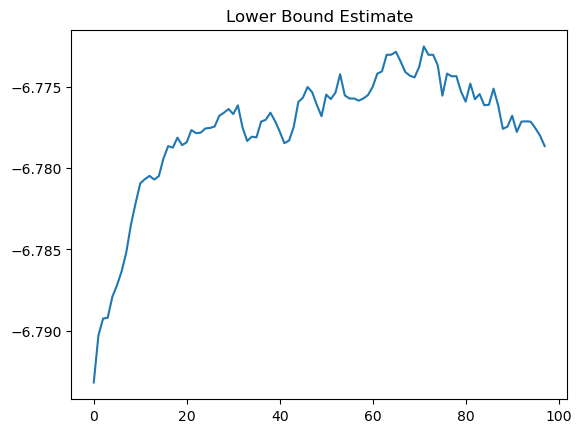

In [71]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

In [72]:
best_lambda_mu 

Array([-0.05339562], dtype=float32)

In [73]:
best_lambda_l

Array([100.11026], dtype=float32)

In [74]:
best_mu = best_lambda_mu
best_vech_l = list(best_lambda_l)
best_l = jnp.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l = best_l.at[i:num_coeffs,i].set(best_vech_l[:num_coeffs - i])
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma = jnp.linalg.solve(best_Sigma_inv, jnp.eye(best_Sigma_inv.shape[0]))

best_theta = random.multivariate_normal(key2, mean = best_mu, cov = best_Sigma, shape = (1000,))
posterior_mean_estimate = jnp.mean(best_theta)
posterior_mean_estimate

Array(-0.0534614, dtype=float32)

In [75]:
np.linalg.norm(posterior_mean_estimate - true_theta)

0.053461403

Text(0.5, 1.0, 'Posterior density of theta')

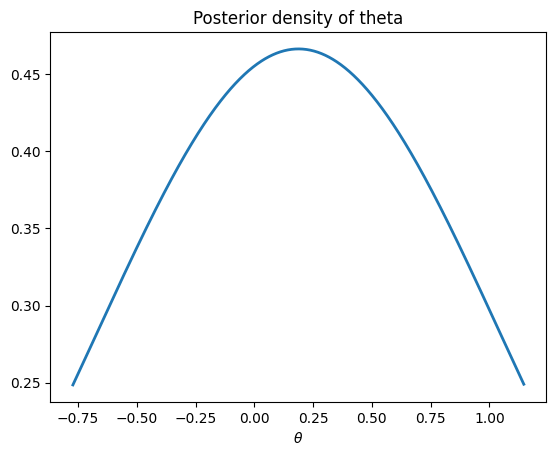

In [ ]:
from sklearn.neighbors import KernelDensity

plt.figure()
x_plot = jnp.arange((np.mean(best_theta)-10*np.std(best_theta)), (np.mean(best_theta)+10*np.std(best_theta)), 0.002)
kde = KernelDensity(bandwidth=0.85, kernel='gaussian')
kde.fit(best_theta.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\theta$')
plt.title('Posterior density of theta')

In [ ]:
## FIND BEST COEFFS USING VB

In [76]:
def unbiased_log_likelihood(theta, actual_summary_statistics, n_samples, num_datasets):
    sample_mean = summary_statistics(theta, n_samples, num_datasets)[0]
    sample_variance = summary_statistics(theta, n_samples, num_datasets)[1]
    u_est_log_likelihood = multivariate_normal.logpdf(actual_summary_statistics, mean = sample_mean, cov= sample_variance)

    # diff_mean_s = actual_summary_statistics - sample_mean
    # part1 = diff_mean_s.T @ jnp.linalg.solve(sample_variance, diff_mean_s)
    # u_est_log_likelihood = -1/2 * jnp.linalg.slogdet(sample_variance)[1] -1/2 * part1

    return u_est_log_likelihood

In [77]:
class nn_GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_coeffs = np.shape(true_theta)[0] # number of coeffs
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def fun_gradient_lb(self, theta_q, mu_q, l_q, c_mu, c_l):

        # Find gradient of LB
        llh = unbiased_log_likelihood(theta_q, self.actual_summary_statistics, n_samples, num_datasets)
        h_lambda = prior(theta_q, sigma_theta, num_coeffs) + llh - fun_log_q(theta_q, mu_q, l_q)

        # Find gradient of LB
        grad_log_q_mu, grad_log_q_l = gradient_log_q(theta_q, mu_q, l_q, num_coeffs)
        gradient_lb_mu = grad_log_q_mu * (h_lambda - c_mu)
        gradient_lb_l = grad_log_q_l * (h_lambda - c_l)
        # Calculate control variates
        flattened_gradient_log_q = jnp.concatenate((grad_log_q_mu, grad_log_q_l), axis = None)
        flattened_gradient_lb = jnp.concatenate((gradient_lb_mu, gradient_lb_l), axis = None)

        return gradient_lb_mu, gradient_lb_l, h_lambda, flattened_gradient_log_q, flattened_gradient_lb

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        mu_0 = jnp.array([0])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        # mu_0 = np.array([0] * self.num_coeffs)
        l_0 = jnp.tril(jnp.identity(self.num_coeffs) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = jnp.linalg.solve(Sigma_0_inv, jnp.eye(Sigma_0_inv.shape[0]))
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[jnp.triu_indices(self.num_coeffs)]

        # Initilize best lambda
        lambda_best_mu = mu_0
        lambda_best_l = vech_l0
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []

        func_auto = vmap(self.fun_gradient_lb, in_axes=[0, None, None, None, None])

        for t in tqdm(range(stop)):
            if t == 0:
                # Draw samples of theta from  variational q
                # List of gradients
                # theta_0_samples = jnp.array(scipy.stats.multivariate_normal.rvs(mu_0, Sigma_0, size = self.samples))
                theta_0_samples = random.multivariate_normal(subkeys[t], mean = mu_0, cov = Sigma_0, shape = (self.samples,))
                gradient_lb_mu_0, gradient_lb_l_0, lb_0, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_0_samples, mu_0, l_0, 0, 0)
                # Calculate control variates using all samples
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_mu_init = jnp.mean(gradient_lb_mu_0, axis = 0)
                self.g_vech_l_init = jnp.mean(gradient_lb_l_0, axis = 0)
                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None)) > self.l_threshold:
                    self.g_mu_init = self.l_threshold * self.g_mu_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                    self.g_vech_l_init = self.l_threshold * self.g_vech_l_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                self.v_mu_init = self.g_mu_init ** 2
                self.v_vech_l_init = self.g_vech_l_init ** 2
                # Calculate lower bound
                LB_all.append(jnp.mean(lb_0))
                print('LB', (jnp.mean(lb_0)))
                lambda_q_mu = mu_0
                lambda_q_l = vech_l0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q_mu

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q_l)
                l_q = jnp.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q = l_q.at[i:self.num_coeffs,i].set(vech_lq[:self.num_coeffs - i])
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  jnp.linalg.solve(Sigma_q_inv, jnp.eye(Sigma_q_inv.shape[0]))
                l_q_inv =  jnp.linalg.solve(l_q, jnp.eye(l_q.shape[0]))
                # List of gradients
                Gradient_lb = []
                lb_t = []
                # theta_q_samples = jnp.array(scipy.stats.multivariate_normal.rvs(mu_q, Sigma_q, size = self.samples))
                theta_q_samples = random.multivariate_normal(subkeys[t], mean = mu_q, cov = Sigma_q, shape = (self.samples,))
                gradient_lb_mu, gradient_lb_l, lb_t, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_q_samples, mu_q, l_q, c_mu, c_vech_l)

                # Update control variates
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                g_mu_t = jnp.mean(gradient_lb_mu, axis = 0)
                g_vech_l_t = jnp.mean(gradient_lb_l, axis = 0)
                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None)) > self.l_threshold:
                    g_mu_t = self.l_threshold * g_mu_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                    g_vech_l_t = self.l_threshold * g_vech_l_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                v_mu_t = g_mu_t ** 2
                v_vech_l_t = g_vech_l_t ** 2
                #---- Update lambda
                self.g_mu_init = self.adaptive_lr_1 * self.g_mu_init + (1 - self.adaptive_lr_1) * g_mu_t
                self.g_vech_l_init = self.adaptive_lr_1 * self.g_vech_l_init + (1 - self.adaptive_lr_1) * g_vech_l_t

                self.v_mu_init = self.adaptive_lr_2 * self.v_mu_init + (1 - self.adaptive_lr_2) * v_mu_t
                self.v_vech_l_init = self.adaptive_lr_2 * self.v_vech_l_init + (1 - self.adaptive_lr_2) * v_vech_l_t

                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q_mu = lambda_q_mu + update_t * self.g_mu_init / (self.v_mu_init ** 0.5)
                lambda_q_l = lambda_q_l + update_t * self.g_vech_l_init / (self.v_vech_l_init ** 0.5)
                # Calculate lower bound
                LB_all.append(jnp.mean(lb_t))

                if t < self.t_w:
                    print('LB', jnp.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = jnp.mean(jnp.array(LB_all[t - self.t_w + 1 : t]))
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= jnp.max(jnp.array(LB_Smoothed)):
                        patience = 0
                        lambda_best_mu = lambda_q_mu
                        lambda_best_l = lambda_q_l
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best_mu, lambda_best_l

In [78]:
nn_vb = nn_GVB(200, transformed_actual_summary_statistics[0], 0.005, 2500, 100, 0.9, 0.9, 100, 25)
nn_LB_estimate, nn_smoothed_LB_estimate, nn_best_lambda_mu, nn_best_lambda_l = nn_vb.vb_posterior(stop)

  0%|          | 1/4000 [00:53<59:22:23, 53.45s/it]

LB -7.348646


  0%|          | 2/4000 [01:37<53:27:58, 48.14s/it]

LB -7.4519067


  0%|          | 3/4000 [02:19<50:05:06, 45.11s/it]

LB -7.398778


  0%|          | 4/4000 [03:02<49:22:54, 44.49s/it]

LB -7.2958875


  0%|          | 5/4000 [03:45<48:37:11, 43.81s/it]

LB -7.2953734


  0%|          | 6/4000 [04:37<51:39:43, 46.57s/it]

LB -7.335048


  0%|          | 7/4000 [05:19<50:11:45, 45.26s/it]

LB -7.3061843


  0%|          | 8/4000 [06:03<49:24:10, 44.55s/it]

LB -7.3044634


  0%|          | 9/4000 [06:46<49:05:10, 44.28s/it]

LB -7.264951


  0%|          | 10/4000 [07:32<49:44:34, 44.88s/it]

LB -7.267628


  0%|          | 11/4000 [08:15<49:04:45, 44.29s/it]

LB -7.266804


  0%|          | 12/4000 [08:58<48:38:14, 43.91s/it]

LB -7.255849


  0%|          | 13/4000 [09:42<48:23:55, 43.70s/it]

LB -7.249022


  0%|          | 14/4000 [10:24<47:51:09, 43.22s/it]

LB -7.218349


  0%|          | 15/4000 [11:06<47:20:51, 42.77s/it]

LB -7.22425


  0%|          | 16/4000 [11:47<46:52:47, 42.36s/it]

LB -7.1953483


  0%|          | 17/4000 [12:25<45:35:15, 41.20s/it]

LB -7.1914525


  0%|          | 18/4000 [13:03<44:27:07, 40.19s/it]

LB -7.1496167


  0%|          | 19/4000 [13:41<43:41:05, 39.50s/it]

LB -7.1589966


  0%|          | 20/4000 [14:19<43:13:03, 39.09s/it]

LB -7.2185383


  1%|          | 21/4000 [15:01<44:03:57, 39.87s/it]

LB -7.1654186


  1%|          | 22/4000 [15:45<45:22:36, 41.07s/it]

LB -7.1583557


  1%|          | 23/4000 [16:28<46:12:50, 41.83s/it]

LB -7.071629


  1%|          | 24/4000 [17:10<45:57:48, 41.62s/it]

LB -7.145075


  1%|          | 25/4000 [17:52<46:13:43, 41.87s/it]

LB -7.203254


  1%|          | 26/4000 [18:39<47:57:54, 43.45s/it]

LB -7.1201262


  1%|          | 27/4000 [19:22<47:49:17, 43.33s/it]

LB -7.1390367


  1%|          | 28/4000 [20:05<47:43:27, 43.25s/it]

LB -7.124674


  1%|          | 29/4000 [20:45<46:31:19, 42.18s/it]

LB -7.200313


  1%|          | 30/4000 [21:36<49:25:51, 44.82s/it]

LB -7.158051


  1%|          | 31/4000 [22:18<48:32:31, 44.03s/it]

LB -7.0933933


  1%|          | 32/4000 [23:01<48:17:42, 43.82s/it]

LB -7.0382667


  1%|          | 33/4000 [23:44<47:52:09, 43.44s/it]

LB -7.0701065


  1%|          | 34/4000 [24:27<47:38:47, 43.25s/it]

LB -7.057596


  1%|          | 35/4000 [25:11<47:49:06, 43.42s/it]

LB -7.102516


  1%|          | 36/4000 [25:55<48:10:21, 43.75s/it]

LB -7.1136255


  1%|          | 37/4000 [26:39<48:18:34, 43.88s/it]

LB -7.172949


  1%|          | 38/4000 [27:22<47:53:30, 43.52s/it]

LB -7.124146


  1%|          | 39/4000 [28:05<47:42:41, 43.36s/it]

LB -7.075595


  1%|          | 40/4000 [28:48<47:39:14, 43.32s/it]

LB -7.0705028


  1%|          | 41/4000 [29:32<47:53:47, 43.55s/it]

LB -6.937117


  1%|          | 42/4000 [30:15<47:35:20, 43.28s/it]

LB -7.0149426


  1%|          | 43/4000 [30:58<47:28:09, 43.19s/it]

LB -7.0165186


  1%|          | 44/4000 [31:41<47:28:23, 43.20s/it]

LB -7.099806


  1%|          | 45/4000 [32:24<47:19:28, 43.08s/it]

LB -7.0700693


  1%|          | 46/4000 [33:06<47:00:39, 42.80s/it]

LB -7.0564857


  1%|          | 47/4000 [33:48<46:44:24, 42.57s/it]

LB -7.114214


  1%|          | 48/4000 [3:31:14<3538:37:33, 3223.44s/it]

LB -7.0240355


  1%|          | 49/4000 [3:31:45<2486:40:21, 2265.76s/it]

LB -7.017573


  1%|▏         | 50/4000 [3:32:13<1749:23:31, 1594.38s/it]

LB -7.032235


  1%|▏         | 51/4000 [3:32:42<1234:04:15, 1125.01s/it]

LB -7.0570054


  1%|▏         | 52/4000 [3:33:13<873:34:55, 796.58s/it]  

LB -6.956516


  1%|▏         | 53/4000 [3:33:41<620:38:31, 566.08s/it]

LB -7.022171


  1%|▏         | 54/4000 [3:34:10<443:44:31, 404.83s/it]

LB -7.0678563


  1%|▏         | 55/4000 [3:34:37<319:27:23, 291.52s/it]

LB -7.00645


  1%|▏         | 56/4000 [3:35:07<233:41:54, 213.32s/it]

LB -7.0677695


  1%|▏         | 57/4000 [3:35:35<172:31:06, 157.51s/it]

LB -7.0271287


  1%|▏         | 58/4000 [3:36:02<129:49:44, 118.57s/it]

LB -7.0280395


  1%|▏         | 59/4000 [3:36:30<99:56:04, 91.29s/it]  

LB -7.066815


  2%|▏         | 60/4000 [3:36:58<79:03:18, 72.23s/it]

LB -7.075392


  2%|▏         | 61/4000 [3:37:25<64:08:14, 58.62s/it]

LB -6.9730487


  2%|▏         | 62/4000 [3:37:51<53:39:08, 49.05s/it]

LB -7.011682


  2%|▏         | 63/4000 [3:38:19<46:25:39, 42.45s/it]

LB -7.029711


  2%|▏         | 64/4000 [3:38:45<41:12:04, 37.68s/it]

LB -7.0300436


  2%|▏         | 65/4000 [3:39:12<37:45:40, 34.55s/it]

LB -7.026118


  2%|▏         | 66/4000 [3:39:39<35:15:36, 32.27s/it]

LB -7.0299425


  2%|▏         | 67/4000 [3:40:06<33:34:07, 30.73s/it]

LB -6.98729


  2%|▏         | 68/4000 [3:40:33<32:20:08, 29.61s/it]

LB -6.9649363


  2%|▏         | 69/4000 [3:41:01<31:40:01, 29.00s/it]

LB -7.048026


  2%|▏         | 70/4000 [3:41:28<30:58:34, 28.38s/it]

LB -7.003027


  2%|▏         | 71/4000 [3:41:54<30:19:34, 27.79s/it]

LB -7.0292997


  2%|▏         | 72/4000 [3:42:21<29:58:48, 27.48s/it]

LB -7.0753207


  2%|▏         | 73/4000 [3:42:48<29:45:37, 27.28s/it]

LB -7.013503


  2%|▏         | 74/4000 [3:43:15<29:33:28, 27.10s/it]

LB -7.0294933


  2%|▏         | 75/4000 [3:43:41<29:23:07, 26.95s/it]

LB -6.997428


  2%|▏         | 76/4000 [3:44:08<29:25:53, 27.00s/it]

LB -6.9415026


  2%|▏         | 77/4000 [3:44:35<29:22:38, 26.96s/it]

LB -7.0654273


  2%|▏         | 78/4000 [3:45:02<29:25:29, 27.01s/it]

LB -6.970279


  2%|▏         | 79/4000 [3:45:29<29:24:57, 27.01s/it]

LB -6.976554


  2%|▏         | 80/4000 [3:45:56<29:22:49, 26.98s/it]

LB -6.976895


  2%|▏         | 81/4000 [3:46:24<29:34:27, 27.17s/it]

LB -7.036677


  2%|▏         | 82/4000 [3:46:50<29:23:56, 27.01s/it]

LB -7.0130925


  2%|▏         | 83/4000 [3:47:17<29:14:09, 26.87s/it]

LB -7.002479


  2%|▏         | 84/4000 [3:47:44<29:07:35, 26.78s/it]

LB -7.0403028


  2%|▏         | 85/4000 [3:48:10<29:09:27, 26.81s/it]

LB -7.0085716


  2%|▏         | 86/4000 [3:48:38<29:22:38, 27.02s/it]

LB -7.001074


  2%|▏         | 87/4000 [3:49:06<29:45:27, 27.38s/it]

LB -7.0137253


  2%|▏         | 88/4000 [3:49:34<29:58:46, 27.59s/it]

LB -6.9381065


  2%|▏         | 89/4000 [3:50:03<30:13:30, 27.82s/it]

LB -6.951515


  2%|▏         | 90/4000 [3:50:31<30:28:49, 28.06s/it]

LB -7.0293283


  2%|▏         | 91/4000 [3:51:00<30:34:17, 28.15s/it]

LB -6.9747596


  2%|▏         | 92/4000 [3:51:30<31:13:53, 28.77s/it]

LB -7.0069284


  2%|▏         | 93/4000 [3:51:58<30:56:04, 28.50s/it]

LB -6.983152


  2%|▏         | 94/4000 [3:52:25<30:32:02, 28.14s/it]

LB -7.0258484


  2%|▏         | 95/4000 [3:52:52<30:00:47, 27.67s/it]

LB -6.99022


  2%|▏         | 96/4000 [3:53:19<29:54:10, 27.57s/it]

LB -6.9465795


  2%|▏         | 97/4000 [3:53:46<29:39:29, 27.36s/it]

LB -7.0015664


  2%|▏         | 98/4000 [3:54:14<29:48:11, 27.50s/it]

LB -7.033747


  2%|▏         | 99/4000 [3:54:41<29:37:49, 27.34s/it]

LB -7.0062428


  2%|▎         | 100/4000 [3:55:08<29:32:11, 27.26s/it]

LB -6.964375


  3%|▎         | 101/4000 [3:55:35<29:30:49, 27.25s/it]

LB Smoothed -7.0844345


  3%|▎         | 102/4000 [3:56:02<29:28:33, 27.22s/it]

LB Smoothed -7.079001


  3%|▎         | 103/4000 [3:56:30<29:33:58, 27.31s/it]

LB Smoothed -7.0748634


  3%|▎         | 104/4000 [3:56:57<29:27:12, 27.22s/it]

LB Smoothed -7.0719266


  3%|▎         | 105/4000 [3:57:25<29:43:39, 27.48s/it]

LB Smoothed -7.0683002


  3%|▎         | 106/4000 [3:57:52<29:37:09, 27.38s/it]

LB Smoothed -7.0651093


  3%|▎         | 107/4000 [3:58:20<29:45:54, 27.52s/it]

LB Smoothed -7.0617375


  3%|▎         | 108/4000 [3:58:46<29:31:21, 27.31s/it]

LB Smoothed -7.0582633


  3%|▎         | 109/4000 [3:59:14<29:40:39, 27.46s/it]

LB Smoothed -7.0547986


  3%|▎         | 110/4000 [3:59:42<29:42:14, 27.49s/it]

LB Smoothed -7.0511723


  3%|▎         | 111/4000 [4:00:09<29:34:52, 27.38s/it]

LB Smoothed -7.0478964


  3%|▎         | 112/4000 [4:00:36<29:33:18, 27.37s/it]

LB Smoothed -7.045413


  3%|▎         | 113/4000 [4:01:03<29:30:11, 27.32s/it]

LB Smoothed -7.043103


  3%|▎         | 114/4000 [4:01:31<29:34:07, 27.39s/it]

LB Smoothed -7.0411687


  3%|▎         | 115/4000 [4:01:58<29:33:32, 27.39s/it]

LB Smoothed -7.0388565


  3%|▎         | 116/4000 [4:02:26<29:45:11, 27.58s/it]

LB Smoothed -7.0361686


  3%|▎         | 117/4000 [4:02:54<29:49:07, 27.65s/it]

LB Smoothed -7.033576


  3%|▎         | 118/4000 [4:03:22<29:50:58, 27.68s/it]

LB Smoothed -7.0316987


  3%|▎         | 119/4000 [4:03:49<29:39:39, 27.51s/it]

LB Smoothed -7.029483


  3%|▎         | 120/4000 [4:04:17<29:39:27, 27.52s/it]

LB Smoothed -7.0280933


  3%|▎         | 121/4000 [4:04:44<29:30:59, 27.39s/it]

LB Smoothed -7.0264044


  3%|▎         | 122/4000 [4:05:11<29:26:49, 27.34s/it]

LB Smoothed -7.0241957


  3%|▎         | 123/4000 [4:05:39<29:31:41, 27.42s/it]

LB Smoothed -7.02301


  3%|▎         | 124/4000 [4:06:06<29:30:27, 27.41s/it]

LB Smoothed -7.0218678


  3%|▎         | 125/4000 [4:06:34<29:34:16, 27.47s/it]

LB Smoothed -7.02044


  3%|▎         | 126/4000 [4:07:01<29:28:38, 27.39s/it]

LB Smoothed -7.0193906


  3%|▎         | 127/4000 [4:07:28<29:24:59, 27.34s/it]

LB Smoothed -7.018106


  3%|▎         | 128/4000 [4:07:55<29:15:36, 27.20s/it]

LB Smoothed -7.0164056


  3%|▎         | 129/4000 [4:08:22<29:18:31, 27.26s/it]

LB Smoothed -7.014969


  3%|▎         | 130/4000 [4:08:49<29:11:50, 27.16s/it]

LB Smoothed -7.013663


  3%|▎         | 131/4000 [4:09:17<29:23:40, 27.35s/it]

LB Smoothed -7.012889


  3%|▎         | 132/4000 [4:09:44<29:12:56, 27.19s/it]

LB Smoothed -7.011873


  3%|▎         | 133/4000 [4:10:11<29:15:05, 27.23s/it]

LB Smoothed -7.0121236


  3%|▎         | 134/4000 [4:10:39<29:17:59, 27.28s/it]

LB Smoothed -7.0119867


  3%|▎         | 135/4000 [4:11:06<29:12:14, 27.20s/it]

LB Smoothed -7.010688


  3%|▎         | 136/4000 [4:11:33<29:24:23, 27.40s/it]

LB Smoothed -7.0097914


  3%|▎         | 137/4000 [4:12:00<29:17:05, 27.29s/it]

LB Smoothed -7.008069


  3%|▎         | 138/4000 [4:12:28<29:16:09, 27.28s/it]

LB Smoothed -7.006969


  3%|▎         | 139/4000 [4:12:55<29:08:11, 27.17s/it]

LB Smoothed -7.0056148


  4%|▎         | 140/4000 [4:13:22<29:10:38, 27.21s/it]

LB Smoothed -7.005322


  4%|▎         | 141/4000 [4:13:49<29:04:56, 27.13s/it]

LB Smoothed -7.0052567


  4%|▎         | 142/4000 [4:14:16<29:10:28, 27.22s/it]

LB Smoothed -7.0051894


  4%|▎         | 143/4000 [4:14:43<29:05:24, 27.15s/it]

LB Smoothed -7.004544


  4%|▎         | 144/4000 [4:15:10<29:00:10, 27.08s/it]

LB Smoothed -7.0032797


  4%|▎         | 145/4000 [4:15:37<29:01:58, 27.11s/it]

LB Smoothed -7.0014057


  4%|▎         | 146/4000 [4:16:05<29:03:08, 27.14s/it]

LB Smoothed -7.0005217


  4%|▎         | 147/4000 [4:16:32<29:07:03, 27.21s/it]

LB Smoothed -6.999261


  4%|▎         | 148/4000 [4:16:59<29:07:34, 27.22s/it]

LB Smoothed -6.9989705


  4%|▎         | 149/4000 [4:17:27<29:12:21, 27.30s/it]

LB Smoothed -6.9989753


  4%|▍         | 150/4000 [4:17:54<29:13:25, 27.33s/it]

LB Smoothed -6.999023


  4%|▍         | 151/4000 [4:18:21<29:10:00, 27.28s/it]

LB Smoothed -6.9974318


  4%|▍         | 152/4000 [4:18:48<29:06:00, 27.22s/it]

LB Smoothed -6.997271


  4%|▍         | 153/4000 [4:19:16<29:09:17, 27.28s/it]

LB Smoothed -6.996375


  4%|▍         | 154/4000 [4:19:43<29:05:22, 27.23s/it]

LB Smoothed -6.994899


  4%|▍         | 155/4000 [4:20:10<29:01:24, 27.17s/it]

LB Smoothed -6.9954123


  4%|▍         | 156/4000 [4:20:37<29:03:11, 27.21s/it]

LB Smoothed -6.995029


  4%|▍         | 157/4000 [4:21:05<29:08:06, 27.29s/it]

LB Smoothed -6.9943686


  4%|▍         | 158/4000 [4:21:32<29:03:11, 27.22s/it]

LB Smoothed -6.993951


  4%|▍         | 159/4000 [4:21:59<28:57:58, 27.15s/it]

LB Smoothed -6.993381


  4%|▍         | 160/4000 [4:22:26<28:56:47, 27.14s/it]

LB Smoothed -6.9924793


  4%|▍         | 161/4000 [4:22:53<29:02:21, 27.23s/it]

LB Smoothed -6.9915


  4%|▍         | 162/4000 [4:23:21<29:03:33, 27.26s/it]

LB Smoothed -6.990242


  4%|▍         | 163/4000 [4:23:48<29:01:40, 27.23s/it]

LB Smoothed -6.9894896


  4%|▍         | 164/4000 [4:24:15<29:04:41, 27.29s/it]

LB Smoothed -6.988122


  4%|▍         | 165/4000 [4:24:43<29:04:48, 27.30s/it]

LB Smoothed -6.9874687


  4%|▍         | 166/4000 [4:25:10<29:14:03, 27.45s/it]

LB Smoothed -6.9865723


  4%|▍         | 167/4000 [4:25:37<29:03:58, 27.30s/it]

LB Smoothed -6.9864287


  4%|▍         | 168/4000 [4:26:04<28:54:22, 27.16s/it]

LB Smoothed -6.9864664


  4%|▍         | 169/4000 [4:26:31<28:49:58, 27.09s/it]

LB Smoothed -6.986011


  4%|▍         | 170/4000 [4:26:58<28:43:22, 27.00s/it]

LB Smoothed -6.985522


  4%|▍         | 171/4000 [4:27:25<28:48:20, 27.08s/it]

LB Smoothed -6.9844446


  4%|▍         | 172/4000 [4:27:52<28:52:36, 27.16s/it]

LB Smoothed -6.982824


  4%|▍         | 173/4000 [4:28:20<28:53:26, 27.18s/it]

LB Smoothed -6.982703


  4%|▍         | 174/4000 [4:28:47<28:47:22, 27.09s/it]

LB Smoothed -6.9820604


  4%|▍         | 175/4000 [4:29:14<28:46:49, 27.09s/it]

LB Smoothed -6.9820457


  4%|▍         | 176/4000 [4:29:40<28:32:38, 26.87s/it]

LB Smoothed -6.9831247


  4%|▍         | 177/4000 [4:30:06<28:23:14, 26.73s/it]

LB Smoothed -6.9814377


  4%|▍         | 178/4000 [4:30:33<28:27:58, 26.81s/it]

LB Smoothed -6.9811015


  4%|▍         | 179/4000 [4:31:01<28:49:36, 27.16s/it]

LB Smoothed -6.980528


  4%|▍         | 180/4000 [4:31:29<29:05:31, 27.42s/it]

LB Smoothed -6.980786


  5%|▍         | 181/4000 [4:31:57<29:04:13, 27.40s/it]

LB Smoothed -6.980698


  5%|▍         | 182/4000 [4:32:24<29:00:27, 27.35s/it]

LB Smoothed -6.9791307


  5%|▍         | 183/4000 [4:32:51<28:44:47, 27.11s/it]

LB Smoothed -6.9793854


  5%|▍         | 184/4000 [4:33:18<28:50:01, 27.20s/it]

LB Smoothed -6.978416


  5%|▍         | 185/4000 [4:33:45<28:40:28, 27.06s/it]

LB Smoothed -6.9783745


  5%|▍         | 186/4000 [4:34:12<28:48:20, 27.19s/it]

LB Smoothed -6.9778934


  5%|▍         | 187/4000 [4:34:40<28:54:18, 27.29s/it]

LB Smoothed -6.9764566


  5%|▍         | 188/4000 [4:35:07<29:03:20, 27.44s/it]

LB Smoothed -6.9768424


  5%|▍         | 189/4000 [4:35:35<29:05:27, 27.48s/it]

LB Smoothed -6.977491


  5%|▍         | 190/4000 [4:36:02<28:53:42, 27.30s/it]

LB Smoothed -6.976756


  5%|▍         | 191/4000 [4:36:29<28:57:55, 27.38s/it]

LB Smoothed -6.975656


  5%|▍         | 192/4000 [4:36:56<28:47:02, 27.21s/it]

LB Smoothed -6.9759655


  5%|▍         | 193/4000 [4:37:24<28:47:51, 27.23s/it]

LB Smoothed -6.974951


  5%|▍         | 194/4000 [4:37:51<28:44:56, 27.19s/it]

LB Smoothed -6.97447


  5%|▍         | 195/4000 [4:38:18<28:49:32, 27.27s/it]

LB Smoothed -6.9740067


  5%|▍         | 196/4000 [4:38:45<28:36:19, 27.07s/it]

LB Smoothed -6.97385


  5%|▍         | 197/4000 [4:39:12<28:44:56, 27.21s/it]

LB Smoothed -6.9737954


  5%|▍         | 198/4000 [4:39:39<28:38:27, 27.12s/it]

LB Smoothed -6.9739385


  5%|▍         | 199/4000 [4:40:06<28:27:01, 26.95s/it]

LB Smoothed -6.973146


  5%|▌         | 200/4000 [4:40:33<28:39:16, 27.15s/it]

LB Smoothed -6.9728065


  5%|▌         | 201/4000 [4:41:00<28:31:13, 27.03s/it]

LB Smoothed -6.9735513


  5%|▌         | 202/4000 [4:41:28<28:39:48, 27.17s/it]

LB Smoothed -6.97333


  5%|▌         | 203/4000 [4:41:55<28:38:34, 27.16s/it]

LB Smoothed -6.9730926


  5%|▌         | 204/4000 [4:42:22<28:40:21, 27.19s/it]

LB Smoothed -6.9739556


  5%|▌         | 205/4000 [4:42:49<28:40:44, 27.21s/it]

LB Smoothed -6.9730806


  5%|▌         | 206/4000 [4:43:19<29:21:21, 27.86s/it]

LB Smoothed -6.9723306


  5%|▌         | 207/4000 [4:43:47<29:34:43, 28.07s/it]

LB Smoothed -6.971958


  5%|▌         | 208/4000 [4:44:16<29:51:27, 28.35s/it]

LB Smoothed -6.972558


  5%|▌         | 209/4000 [4:44:46<30:12:21, 28.68s/it]

LB Smoothed -6.9731755


  5%|▌         | 210/4000 [4:45:15<30:23:57, 28.88s/it]

LB Smoothed -6.972861


  5%|▌         | 211/4000 [4:45:44<30:28:37, 28.96s/it]

LB Smoothed -6.972475


  5%|▌         | 212/4000 [4:46:15<31:05:06, 29.54s/it]

LB Smoothed -6.972525


  5%|▌         | 213/4000 [4:46:44<30:59:38, 29.46s/it]

LB Smoothed -6.971483


  5%|▌         | 214/4000 [4:47:14<31:06:02, 29.57s/it]

LB Smoothed -6.971327


  5%|▌         | 215/4000 [4:47:43<30:53:47, 29.39s/it]

LB Smoothed -6.9719925


  5%|▌         | 216/4000 [4:48:12<30:52:05, 29.37s/it]

LB Smoothed -6.9724545


  5%|▌         | 217/4000 [4:48:44<31:28:20, 29.95s/it]

LB Smoothed -6.9726143


  5%|▌         | 218/4000 [4:49:15<31:46:40, 30.25s/it]

LB Smoothed -6.9733453


  5%|▌         | 219/4000 [4:49:45<31:42:16, 30.19s/it]

LB Smoothed -6.972438


  6%|▌         | 220/4000 [4:50:13<31:00:07, 29.53s/it]

LB Smoothed -6.972562


  6%|▌         | 221/4000 [4:50:41<30:29:01, 29.04s/it]

LB Smoothed -6.9724493


  6%|▌         | 222/4000 [4:51:09<30:11:25, 28.77s/it]

LB Smoothed -6.972573


  6%|▌         | 223/4000 [4:51:37<30:01:36, 28.62s/it]

LB Smoothed -6.972134


  6%|▌         | 224/4000 [4:52:05<29:48:16, 28.42s/it]

LB Smoothed -6.971234


  6%|▌         | 225/4000 [4:52:33<29:44:08, 28.36s/it]

LB Smoothed -6.9703355


  6%|▌         | 226/4000 [4:53:01<29:31:32, 28.16s/it]

LB Smoothed -6.9701266


  6%|▌         | 227/4000 [4:53:29<29:27:05, 28.10s/it]

LB Smoothed -6.970489


  6%|▌         | 228/4000 [4:53:57<29:18:19, 27.97s/it]

LB Smoothed -6.9695034


  6%|▌         | 229/4000 [4:54:25<29:33:55, 28.22s/it]

LB Smoothed -6.968714


  6%|▌         | 230/4000 [4:54:53<29:26:49, 28.12s/it]

LB Smoothed -6.9685073


  6%|▌         | 231/4000 [4:55:21<29:23:30, 28.07s/it]

LB Smoothed -6.9689813


  6%|▌         | 232/4000 [4:55:49<29:15:22, 27.95s/it]

LB Smoothed -6.96842


  6%|▌         | 233/4000 [4:56:17<29:21:13, 28.05s/it]

LB Smoothed -6.967258


  6%|▌         | 234/4000 [4:56:45<29:20:47, 28.05s/it]

LB Smoothed -6.9664726


  6%|▌         | 235/4000 [4:57:13<29:10:26, 27.90s/it]

LB Smoothed -6.965734


  6%|▌         | 236/4000 [4:57:40<29:06:54, 27.85s/it]

LB Smoothed -6.965136


  6%|▌         | 237/4000 [4:58:08<28:59:11, 27.73s/it]

LB Smoothed -6.965235


  6%|▌         | 238/4000 [4:58:36<29:02:56, 27.80s/it]

LB Smoothed -6.965458


  6%|▌         | 239/4000 [4:59:03<28:55:20, 27.68s/it]

LB Smoothed -6.96475


  6%|▌         | 240/4000 [4:59:31<28:52:48, 27.65s/it]

LB Smoothed -6.9655766


  6%|▌         | 241/4000 [4:59:58<28:51:28, 27.64s/it]

LB Smoothed -6.9655156
LB Smoothed -6.965803


  6%|▌         | 243/4000 [5:00:54<28:46:23, 27.57s/it]

LB Smoothed -6.966098


  6%|▌         | 244/4000 [5:01:21<28:48:51, 27.62s/it]

LB Smoothed -6.966676


  6%|▌         | 245/4000 [5:01:48<28:38:15, 27.46s/it]

LB Smoothed -6.9670615


  6%|▌         | 246/4000 [5:02:15<28:29:54, 27.33s/it]

LB Smoothed -6.9665933


  6%|▌         | 247/4000 [5:02:42<28:22:10, 27.21s/it]

LB Smoothed -6.966831


  6%|▌         | 248/4000 [5:03:10<28:24:03, 27.25s/it]

LB Smoothed -6.9662776


  6%|▌         | 249/4000 [5:03:37<28:21:14, 27.21s/it]

LB Smoothed -6.9654036


  6%|▋         | 250/4000 [5:04:04<28:17:25, 27.16s/it]

LB Smoothed -6.9668093


  6%|▋         | 251/4000 [5:04:31<28:22:04, 27.24s/it]

LB Smoothed -6.966793


  6%|▋         | 252/4000 [5:04:59<28:21:15, 27.23s/it]

LB Smoothed -6.9679537


  6%|▋         | 253/4000 [5:05:26<28:30:50, 27.40s/it]

LB Smoothed -6.9680285


  6%|▋         | 254/4000 [5:05:53<28:24:51, 27.31s/it]

LB Smoothed -6.9674625


  6%|▋         | 255/4000 [5:06:21<28:30:17, 27.40s/it]

LB Smoothed -6.966124


  6%|▋         | 256/4000 [5:06:48<28:28:51, 27.39s/it]

LB Smoothed -6.9668965


  6%|▋         | 257/4000 [5:07:16<28:31:36, 27.44s/it]

LB Smoothed -6.96648


  6%|▋         | 258/4000 [5:07:43<28:26:37, 27.36s/it]

LB Smoothed -6.9657884


  6%|▋         | 259/4000 [5:08:10<28:21:50, 27.30s/it]

LB Smoothed -6.9661765


  6%|▋         | 260/4000 [5:08:37<28:12:54, 27.16s/it]

LB Smoothed -6.967125


  7%|▋         | 261/4000 [5:09:04<28:10:45, 27.13s/it]

LB Smoothed -6.967612


  7%|▋         | 262/4000 [5:09:32<28:28:37, 27.43s/it]

LB Smoothed -6.9679356


  7%|▋         | 263/4000 [5:09:59<28:19:47, 27.29s/it]

LB Smoothed -6.9682198


  7%|▋         | 264/4000 [5:10:27<28:23:00, 27.35s/it]

LB Smoothed -6.968714


  7%|▋         | 264/4000 [5:10:54<73:19:46, 70.66s/it]

LB Smoothed -6.968918
Stop at 264


<Axes: title={'center': 'Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

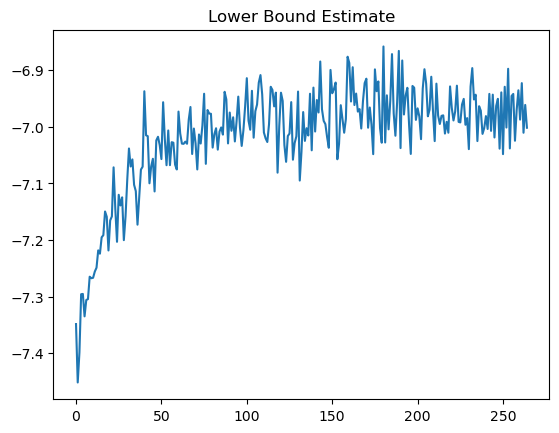

In [79]:
lb_df = pd.DataFrame(np.array(nn_LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<Axes: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

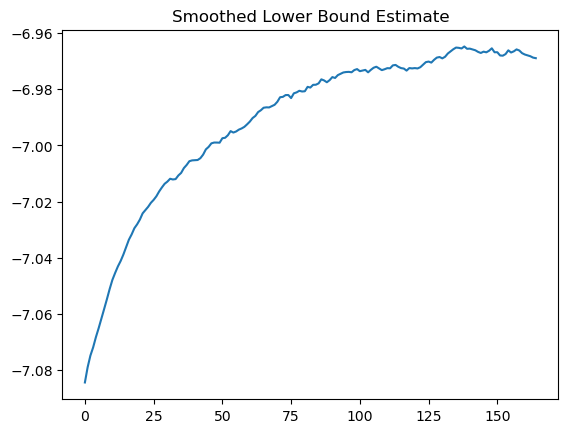

In [80]:
lb_df = pd.DataFrame(np.array(nn_smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [81]:
nn_best_lambda_mu

Array([-0.23336884], dtype=float32)

In [82]:
nn_best_lambda_l

Array([9.966554], dtype=float32)

In [83]:
best_mu = nn_best_lambda_mu
best_vech_l = list(nn_best_lambda_l)
best_l = jnp.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l = best_l.at[i:num_coeffs,i].set(best_vech_l[:num_coeffs - i])
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma = jnp.linalg.solve(best_Sigma_inv, jnp.eye(best_Sigma_inv.shape[0]))

best_theta = random.multivariate_normal(key2, mean = best_mu, cov = best_Sigma, shape = (1000,))
posterior_mean_estimate = jnp.mean(best_theta)
posterior_mean_estimate

Array(-0.23402958, dtype=float32)

In [84]:
np.linalg.norm(posterior_mean_estimate - true_theta)

0.23402958

## MCMC

In [ ]:
num_samples = 1000
num_burnin = 0.2 * num_samples

In [ ]:
def sampler(samples):

    # ------------------- initialize MCMC

    theta_size = num_coeffs  # num of weights and bias

    pos_theta = jnp.ones((samples, theta_size))  # posterior of all weights and bias over all samples

    theta = jnp.array([0])

    ss = summary_statistics(theta, n_samples, num_datasets)
    sample_mean = ss[0]
    sample_precision = ss[1]
    # sample_variance_q = ss_q[2]
    # inverse_sample_precision_q = 1/num_datasets * eps_precision * jnp.eye(sample_variance_q.shape[0]) + sample_variance_q

    # Nuissance mean and variance: PAGE 9
    # diag_precision = jnp.zeros((num_latent, num_latent)).at[jnp.diag_indices_from(inverse_sample_precision_q)].set(jnp.diag(jnp.sqrt(inverse_sample_precision_q)))
    diag_precision = jnp.zeros((num_latent, num_latent)).at[jnp.diag_indices_from(sample_precision)].set(jnp.diag(sample_precision)**(-1/2))
    # mean_nuissance_p1_non_inv = jnp.identity(num_latent) / sigma_latent + jnp.diag(sample_variance_q).T @ jnp.linalg.solve(sample_variance_q, jnp.diag(sample_variance_q))
    mean_nuissance_p1_non_inv = jnp.identity(num_latent) / sigma_latent + diag_precision.T @ sample_precision @ diag_precision
    mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))
    # mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))

    diff_mean = actual_summary_statistics - sample_mean
    mean_nuissance_p2 = diag_precision @ sample_precision @ diff_mean
    mean_nuissance = mean_nuissance_p1 @ mean_nuissance_p2
    variance_nuissance = mean_nuissance_p1

    # Generate Gamma

    Gamma = random.multivariate_normal(key2, mean = mean_nuissance, cov = variance_nuissance)
    adjusted_theta = jnp.concatenate((theta, Gamma))

    # Find gradient of LB
    llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta, actual_summary_statistics, n_samples, num_datasets)
    llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance)

    # ---------------------

    prior_current = prior(theta, sigma_theta, num_coeffs)  # takes care of the gradients

    likelihood_current = llh

    naccept = 0

    for i in tqdm(range(samples - 1)):
        if i < 2000:
            theta_proposal = random.multivariate_normal(subkeys[i], mean = theta, cov = ((0.1**2/theta_size) * jnp.identity(theta_size)))
        else:
            if i % 500 == 0:
                Sign = jnp.cov(pos_theta[0:i, :].T)
                Sign = jnp.reshape(Sign, jnp.shape(jnp.identity(theta_size)))
            u_proposal = np.random.uniform(0, 1)
            if u_proposal < 0.05:
                theta_proposal = random.multivariate_normal(subkeys[i], mean = theta, cov = ((0.1**2/theta_size) * jnp.identity(theta_size)))
            else:
                theta_proposal = random.multivariate_normal(subkeys[i], mean = theta, cov = (2.38**2/theta_size) * Sign)

        ss = summary_statistics(theta_proposal, n_samples, num_datasets)
        sample_mean = ss[0]
        sample_precision = ss[1]
        # sample_variance_q = ss_q[2]
        # inverse_sample_precision_q = 1/num_datasets * eps_precision * jnp.eye(sample_variance_q.shape[0]) + sample_variance_q

        # Nuissance mean and variance: PAGE 9
        # diag_precision = jnp.zeros((num_latent, num_latent)).at[jnp.diag_indices_from(inverse_sample_precision_q)].set(jnp.diag(jnp.sqrt(inverse_sample_precision_q)))
        diag_precision = jnp.zeros((num_latent, num_latent)).at[jnp.diag_indices_from(sample_precision)].set(jnp.diag(sample_precision)**(-1/2))
        # mean_nuissance_p1_non_inv = jnp.identity(num_latent) / sigma_latent + jnp.diag(sample_variance_q).T @ jnp.linalg.solve(sample_variance_q, jnp.diag(sample_variance_q))
        mean_nuissance_p1_non_inv = jnp.identity(num_latent) / sigma_latent + diag_precision.T @ sample_precision @ diag_precision
        mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))
        # mean_nuissance_p1 = jnp.linalg.solve(mean_nuissance_p1_non_inv, jnp.eye(mean_nuissance_p1_non_inv.shape[0]))

        diff_mean = actual_summary_statistics - sample_mean
        mean_nuissance_p2 = diag_precision @ sample_precision @ diff_mean
        mean_nuissance = mean_nuissance_p1 @ mean_nuissance_p2
        variance_nuissance = mean_nuissance_p1

        # Generate Gamma
        Gamma = random.multivariate_normal(key2, mean = mean_nuissance, cov = variance_nuissance)
        adjusted_theta_proposal = jnp.concatenate((theta_proposal, Gamma))

        # Find gradient of LB
        llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_proposal, actual_summary_statistics, n_samples, num_datasets)
        llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance)
        # ---------------------

        prior_proposal = prior(theta_proposal, sigma_theta, num_coeffs)  # takes care of the gradients
        likelihood_proposal = llh

        diff_prior = prior_proposal - prior_current

        diff_likelihood = likelihood_proposal - likelihood_current

        try:
            mh_prob = min(1, math.exp(diff_likelihood+diff_prior))

        except OverflowError as e:
            mh_prob = 1


        u = np.random.uniform(0, 1)

        if u < mh_prob:
            # Update position
            naccept += 1
            likelihood_current = likelihood_proposal
            prior_current = prior_proposal
            theta = theta_proposal
            pos_theta = pos_theta.at[i + 1,].set(theta_proposal)
            print(i, pos_theta[i + 1,])

        else:
            pos_theta = pos_theta.at[i + 1,].set(pos_theta[i,])

    print(naccept, ' num accepted')
    print(naccept / (samples * 1.0) * 100, '% was accepted')
    accept_ratio = naccept / (samples * 1.0) * 100

    return (pos_theta, accept_ratio)

In [ ]:
pos_w, accept_ratio = sampler(num_samples)

  0%|          | 1/999 [00:01<29:04,  1.75s/it]

0 [-0.06461436]


  0%|          | 2/999 [00:03<24:16,  1.46s/it]

1 [-0.2122933]


  0%|          | 3/999 [00:04<22:23,  1.35s/it]

2 [-0.33817035]


  0%|          | 4/999 [00:05<21:19,  1.29s/it]

3 [-0.51985264]


  1%|          | 5/999 [00:06<20:38,  1.25s/it]

4 [-0.6255475]


  1%|          | 7/999 [00:08<20:10,  1.22s/it]

6 [-0.7226155]


  1%|          | 8/999 [00:10<19:52,  1.20s/it]

7 [-0.62251806]


  1%|          | 9/999 [00:11<19:11,  1.16s/it]

8 [-0.655951]


  1%|          | 10/999 [00:12<18:52,  1.14s/it]

9 [-0.37722003]


  1%|          | 11/999 [00:13<18:41,  1.14s/it]

10 [-0.3390231]


  1%|          | 12/999 [00:14<18:33,  1.13s/it]

11 [-0.346911]


  1%|▏         | 13/999 [00:15<18:33,  1.13s/it]

12 [-0.29582253]


  1%|▏         | 14/999 [00:16<18:37,  1.13s/it]

13 [-0.26851118]


  2%|▏         | 15/999 [00:17<18:25,  1.12s/it]

14 [-0.26578718]


  2%|▏         | 16/999 [00:19<18:50,  1.15s/it]

15 [-0.18608603]


  2%|▏         | 17/999 [00:20<18:54,  1.15s/it]

16 [-0.12509003]


  2%|▏         | 19/999 [00:22<18:09,  1.11s/it]

18 [-0.07108067]


  2%|▏         | 20/999 [00:23<17:55,  1.10s/it]

19 [-0.059995]


  2%|▏         | 21/999 [00:24<17:47,  1.09s/it]

20 [-0.02601705]


  2%|▏         | 22/999 [00:25<18:09,  1.12s/it]

21 [0.02522172]


  2%|▏         | 23/999 [00:26<18:02,  1.11s/it]

22 [-0.02458546]


  2%|▏         | 24/999 [00:28<18:27,  1.14s/it]

23 [0.18203975]


  3%|▎         | 25/999 [00:29<18:31,  1.14s/it]

24 [0.15016617]


  3%|▎         | 26/999 [00:30<18:38,  1.15s/it]

25 [0.26719147]


  3%|▎         | 27/999 [00:31<18:54,  1.17s/it]

26 [0.20279121]


  3%|▎         | 28/999 [00:32<18:58,  1.17s/it]

27 [0.11024328]


  3%|▎         | 29/999 [00:33<18:29,  1.14s/it]

28 [0.17572147]


  3%|▎         | 30/999 [00:34<18:22,  1.14s/it]

29 [0.10959728]


  3%|▎         | 31/999 [00:36<18:25,  1.14s/it]

30 [-0.00608324]


  3%|▎         | 32/999 [00:37<18:09,  1.13s/it]

31 [0.0138464]


  3%|▎         | 33/999 [00:38<18:19,  1.14s/it]

32 [-0.00600468]


  3%|▎         | 34/999 [00:39<18:04,  1.12s/it]

33 [-0.1528018]


  4%|▎         | 35/999 [00:40<17:45,  1.10s/it]

34 [-0.13543484]


  4%|▎         | 36/999 [00:41<18:15,  1.14s/it]

35 [0.10821198]


  4%|▎         | 37/999 [00:42<18:24,  1.15s/it]

36 [0.18536136]


  4%|▍         | 38/999 [00:44<18:24,  1.15s/it]

37 [0.12266207]


  4%|▍         | 39/999 [00:45<18:16,  1.14s/it]

38 [0.02852633]


  4%|▍         | 40/999 [00:46<18:01,  1.13s/it]

39 [-0.04747062]


  4%|▍         | 41/999 [00:47<18:14,  1.14s/it]

40 [-0.31957102]


  4%|▍         | 42/999 [00:48<18:20,  1.15s/it]

41 [-0.41808218]


  4%|▍         | 43/999 [00:49<18:01,  1.13s/it]

42 [-0.32175392]


  4%|▍         | 44/999 [00:50<17:58,  1.13s/it]

43 [-0.34135506]


  5%|▍         | 45/999 [00:51<18:02,  1.13s/it]

44 [-0.36986697]


  5%|▍         | 46/999 [00:53<17:51,  1.12s/it]

45 [-0.22393174]


  5%|▍         | 47/999 [00:54<17:57,  1.13s/it]

46 [-0.26819286]


  5%|▍         | 48/999 [00:55<18:05,  1.14s/it]

47 [-0.13461967]


  5%|▍         | 49/999 [00:56<17:48,  1.12s/it]

48 [-0.09121156]


  5%|▌         | 50/999 [00:57<17:53,  1.13s/it]

49 [-0.02452593]


  5%|▌         | 51/999 [00:58<17:31,  1.11s/it]

50 [-0.06372842]


  5%|▌         | 52/999 [00:59<17:47,  1.13s/it]

51 [0.01538489]


  5%|▌         | 53/999 [01:01<18:16,  1.16s/it]

52 [0.32951072]


  5%|▌         | 54/999 [01:02<18:17,  1.16s/it]

53 [0.36159915]


  6%|▌         | 55/999 [01:03<18:09,  1.15s/it]

54 [0.3888121]


  6%|▌         | 56/999 [01:04<18:33,  1.18s/it]

55 [0.22607498]


  6%|▌         | 57/999 [01:05<18:39,  1.19s/it]

56 [-0.07917945]


  6%|▌         | 58/999 [01:07<18:39,  1.19s/it]

57 [-0.09176882]


  6%|▌         | 59/999 [01:08<18:08,  1.16s/it]

58 [-0.08132176]


  6%|▌         | 60/999 [01:09<18:06,  1.16s/it]

59 [-0.14765781]


  6%|▌         | 61/999 [01:10<18:03,  1.16s/it]

60 [-0.10349678]


  6%|▌         | 62/999 [01:11<17:57,  1.15s/it]

61 [0.12899126]


  6%|▋         | 63/999 [01:12<17:52,  1.15s/it]

62 [0.21543908]


  6%|▋         | 64/999 [01:13<17:42,  1.14s/it]

63 [0.27449253]


  7%|▋         | 65/999 [01:14<17:35,  1.13s/it]

64 [0.3744518]


  7%|▋         | 66/999 [01:16<17:55,  1.15s/it]

65 [0.17886515]


  7%|▋         | 67/999 [01:17<18:13,  1.17s/it]

66 [0.2116875]


  7%|▋         | 68/999 [01:18<18:28,  1.19s/it]

67 [0.31866944]


  7%|▋         | 69/999 [01:19<18:12,  1.17s/it]

68 [0.21989605]


  7%|▋         | 70/999 [01:20<17:57,  1.16s/it]

69 [0.33757156]


  7%|▋         | 71/999 [01:22<18:03,  1.17s/it]

70 [0.16995108]


  7%|▋         | 72/999 [01:23<17:28,  1.13s/it]

71 [0.25557566]


  7%|▋         | 73/999 [01:24<17:25,  1.13s/it]

72 [0.359174]


  7%|▋         | 74/999 [01:25<17:48,  1.15s/it]

73 [0.28187063]


  8%|▊         | 75/999 [01:26<18:05,  1.17s/it]

74 [0.25888476]


  8%|▊         | 76/999 [01:27<18:07,  1.18s/it]

75 [0.16929114]


  8%|▊         | 77/999 [01:28<17:47,  1.16s/it]

76 [0.21639907]


  8%|▊         | 78/999 [01:30<17:44,  1.16s/it]

77 [0.34513527]


  8%|▊         | 79/999 [01:31<17:45,  1.16s/it]

78 [0.36073312]


  8%|▊         | 80/999 [01:32<17:38,  1.15s/it]

79 [0.40395623]


  8%|▊         | 81/999 [01:33<17:51,  1.17s/it]

80 [0.39906412]


  8%|▊         | 82/999 [01:34<17:27,  1.14s/it]

81 [0.55798924]


  8%|▊         | 83/999 [01:35<17:07,  1.12s/it]

82 [0.47591466]


  8%|▊         | 84/999 [01:36<17:23,  1.14s/it]

83 [0.51392514]


  9%|▊         | 85/999 [01:38<17:34,  1.15s/it]

84 [0.4920954]


  9%|▊         | 86/999 [01:39<17:41,  1.16s/it]

85 [0.6138336]


  9%|▊         | 87/999 [01:40<17:20,  1.14s/it]

86 [0.61959755]


  9%|▉         | 88/999 [01:41<17:28,  1.15s/it]

87 [0.86859196]


  9%|▉         | 89/999 [01:42<17:36,  1.16s/it]

88 [0.847418]


  9%|▉         | 90/999 [01:43<17:53,  1.18s/it]

89 [0.9655789]


  9%|▉         | 91/999 [01:45<17:21,  1.15s/it]

90 [0.8793083]


  9%|▉         | 92/999 [01:46<17:26,  1.15s/it]

91 [0.8704101]


  9%|▉         | 93/999 [01:47<17:19,  1.15s/it]

92 [0.96097165]


  9%|▉         | 94/999 [01:48<17:49,  1.18s/it]

93 [1.0641665]


 10%|▉         | 95/999 [01:49<17:44,  1.18s/it]

94 [0.9314418]


 10%|▉         | 96/999 [01:50<17:23,  1.16s/it]

95 [1.0643094]


 10%|▉         | 97/999 [01:51<16:53,  1.12s/it]

96 [0.98509145]


 10%|▉         | 98/999 [01:53<16:58,  1.13s/it]

97 [0.9940073]


 10%|▉         | 99/999 [01:54<16:59,  1.13s/it]

98 [0.76061267]


 10%|█         | 100/999 [01:55<17:00,  1.14s/it]

99 [0.7906659]


 10%|█         | 102/999 [01:57<17:14,  1.15s/it]

101 [0.89535135]


 10%|█         | 103/999 [01:58<17:13,  1.15s/it]

102 [1.0180866]


 10%|█         | 104/999 [01:59<16:57,  1.14s/it]

103 [1.0290993]


 11%|█         | 105/999 [02:01<17:25,  1.17s/it]

104 [0.8419841]


 11%|█         | 106/999 [02:02<17:16,  1.16s/it]

105 [0.8845951]


 11%|█         | 107/999 [02:03<17:08,  1.15s/it]

106 [0.92820346]


 11%|█         | 108/999 [02:04<16:59,  1.14s/it]

107 [0.9448604]


 11%|█         | 109/999 [02:05<17:31,  1.18s/it]

108 [0.97906625]


 11%|█         | 110/999 [02:07<17:22,  1.17s/it]

109 [0.9191623]


 11%|█         | 111/999 [02:08<17:26,  1.18s/it]

110 [0.92289364]


 11%|█         | 112/999 [02:09<17:01,  1.15s/it]

111 [1.0914873]


 11%|█▏        | 113/999 [02:10<16:52,  1.14s/it]

112 [0.909459]


 11%|█▏        | 114/999 [02:11<17:09,  1.16s/it]

113 [1.084637]


 12%|█▏        | 115/999 [02:12<17:23,  1.18s/it]

114 [0.8317323]


 12%|█▏        | 116/999 [02:14<17:14,  1.17s/it]

115 [0.83867836]


 12%|█▏        | 117/999 [02:15<17:09,  1.17s/it]

116 [0.8734954]


 12%|█▏        | 118/999 [02:16<17:00,  1.16s/it]

117 [0.8128345]


 12%|█▏        | 119/999 [02:17<16:43,  1.14s/it]

118 [0.82952315]


 12%|█▏        | 120/999 [02:18<16:49,  1.15s/it]

119 [0.8526154]


 12%|█▏        | 121/999 [02:19<16:57,  1.16s/it]

120 [0.9097489]


 12%|█▏        | 122/999 [02:20<16:52,  1.15s/it]

121 [0.7343315]


 12%|█▏        | 123/999 [02:22<16:44,  1.15s/it]

122 [0.8681952]


 12%|█▏        | 124/999 [02:23<16:39,  1.14s/it]

123 [0.7441242]


 13%|█▎        | 125/999 [02:24<16:40,  1.14s/it]

124 [0.7781123]


 13%|█▎        | 126/999 [02:25<16:42,  1.15s/it]

125 [0.84289664]


 13%|█▎        | 127/999 [02:26<16:36,  1.14s/it]

126 [0.89037794]


 13%|█▎        | 128/999 [02:27<16:28,  1.14s/it]

127 [0.84875286]


 13%|█▎        | 129/999 [02:28<16:21,  1.13s/it]

128 [0.6609906]


 13%|█▎        | 130/999 [02:30<16:36,  1.15s/it]

129 [0.6823826]


 13%|█▎        | 131/999 [02:31<16:20,  1.13s/it]

130 [0.67365736]


 13%|█▎        | 132/999 [02:32<16:16,  1.13s/it]

131 [0.6853029]


 13%|█▎        | 133/999 [02:33<16:49,  1.17s/it]

132 [0.7351429]


 13%|█▎        | 134/999 [02:34<16:43,  1.16s/it]

133 [0.84232223]


 14%|█▎        | 135/999 [02:35<16:39,  1.16s/it]

134 [0.7264848]


 14%|█▎        | 136/999 [02:36<16:26,  1.14s/it]

135 [0.77466893]


 14%|█▎        | 137/999 [02:37<15:59,  1.11s/it]

136 [0.7872893]


 14%|█▍        | 138/999 [02:39<16:03,  1.12s/it]

137 [0.77967376]


 14%|█▍        | 139/999 [02:40<15:59,  1.12s/it]

138 [0.5187925]


 14%|█▍        | 140/999 [02:41<15:46,  1.10s/it]

139 [0.46868205]


 14%|█▍        | 141/999 [02:42<16:02,  1.12s/it]

140 [0.34035784]


 14%|█▍        | 142/999 [02:43<16:09,  1.13s/it]

141 [0.3604969]


 14%|█▍        | 143/999 [02:44<15:52,  1.11s/it]

142 [0.4220297]


 14%|█▍        | 144/999 [02:45<15:47,  1.11s/it]

143 [0.54471505]


 15%|█▍        | 145/999 [02:46<16:16,  1.14s/it]

144 [0.59366685]


 15%|█▍        | 146/999 [02:48<15:54,  1.12s/it]

145 [0.8303021]


 15%|█▍        | 147/999 [02:49<16:07,  1.14s/it]

146 [0.7645689]


 15%|█▍        | 148/999 [02:50<16:27,  1.16s/it]

147 [0.6324242]


 15%|█▍        | 149/999 [02:51<16:40,  1.18s/it]

148 [0.64950395]


 15%|█▌        | 150/999 [02:52<16:35,  1.17s/it]

149 [0.6604098]


 15%|█▌        | 151/999 [02:53<16:12,  1.15s/it]

150 [0.8007325]


 15%|█▌        | 152/999 [02:55<16:08,  1.14s/it]

151 [0.708347]


 15%|█▌        | 153/999 [02:56<15:52,  1.13s/it]

152 [0.65316576]


 15%|█▌        | 154/999 [02:57<16:03,  1.14s/it]

153 [0.6135087]


 16%|█▌        | 155/999 [02:58<16:13,  1.15s/it]

154 [0.59273374]


 16%|█▌        | 157/999 [03:00<16:07,  1.15s/it]

156 [0.68551785]


 16%|█▌        | 158/999 [03:01<16:01,  1.14s/it]

157 [0.5737318]


 16%|█▌        | 159/999 [03:02<15:46,  1.13s/it]

158 [0.570437]


 16%|█▌        | 161/999 [03:05<15:42,  1.12s/it]

160 [0.6154424]


 16%|█▌        | 162/999 [03:06<15:37,  1.12s/it]

161 [0.76842165]


 16%|█▋        | 164/999 [03:08<15:48,  1.14s/it]

163 [0.7898765]


 17%|█▋        | 165/999 [03:09<15:53,  1.14s/it]

164 [0.966046]


 17%|█▋        | 166/999 [03:10<15:53,  1.14s/it]

165 [0.79517806]


 17%|█▋        | 167/999 [03:12<15:53,  1.15s/it]

166 [0.84621906]


 17%|█▋        | 168/999 [03:13<15:42,  1.13s/it]

167 [0.7846768]


 17%|█▋        | 169/999 [03:14<15:39,  1.13s/it]

168 [0.67712986]


 17%|█▋        | 170/999 [03:15<15:51,  1.15s/it]

169 [0.6393972]


 17%|█▋        | 171/999 [03:16<16:09,  1.17s/it]

170 [0.70826006]


 17%|█▋        | 172/999 [03:17<15:56,  1.16s/it]

171 [0.7275558]


 17%|█▋        | 173/999 [03:19<16:06,  1.17s/it]

172 [0.8210899]


 17%|█▋        | 174/999 [03:20<16:04,  1.17s/it]

173 [0.88786316]


 18%|█▊        | 175/999 [03:21<16:09,  1.18s/it]

174 [0.8913882]


 18%|█▊        | 176/999 [03:22<15:34,  1.14s/it]

175 [1.0130131]


 18%|█▊        | 177/999 [03:23<15:36,  1.14s/it]

176 [1.1519576]


 18%|█▊        | 178/999 [03:24<15:26,  1.13s/it]

177 [1.1896735]


 18%|█▊        | 179/999 [03:25<15:49,  1.16s/it]

178 [1.2597358]


 18%|█▊        | 180/999 [03:27<15:43,  1.15s/it]

179 [1.2692108]


 18%|█▊        | 181/999 [03:28<15:58,  1.17s/it]

180 [1.2658025]


 18%|█▊        | 182/999 [03:29<15:41,  1.15s/it]

181 [1.120662]


 18%|█▊        | 183/999 [03:30<15:11,  1.12s/it]

182 [1.0628515]


 18%|█▊        | 184/999 [03:31<15:10,  1.12s/it]

183 [0.956909]


 19%|█▊        | 185/999 [03:32<15:25,  1.14s/it]

184 [0.9670389]


 19%|█▊        | 186/999 [03:33<15:19,  1.13s/it]

185 [0.9162557]


 19%|█▊        | 187/999 [03:34<14:56,  1.10s/it]

186 [0.746395]


 19%|█▉        | 188/999 [03:36<15:07,  1.12s/it]

187 [0.59081376]


 19%|█▉        | 189/999 [03:37<14:55,  1.11s/it]

188 [0.61701524]


 19%|█▉        | 190/999 [03:38<14:51,  1.10s/it]

189 [0.64879644]


 19%|█▉        | 191/999 [03:39<14:57,  1.11s/it]

190 [0.70641804]


 19%|█▉        | 192/999 [03:40<15:13,  1.13s/it]

191 [0.7107752]


 19%|█▉        | 193/999 [03:41<15:44,  1.17s/it]

192 [0.8392767]


 19%|█▉        | 194/999 [03:43<16:07,  1.20s/it]

193 [0.8354772]


 20%|█▉        | 195/999 [03:44<16:05,  1.20s/it]

194 [0.7780099]


 20%|█▉        | 196/999 [03:45<15:59,  1.19s/it]

195 [0.9010414]


 20%|█▉        | 197/999 [03:46<15:43,  1.18s/it]

196 [1.0792549]


 20%|█▉        | 198/999 [03:47<15:24,  1.15s/it]

197 [1.0324674]


 20%|█▉        | 199/999 [03:48<15:31,  1.16s/it]

198 [1.0244418]


 20%|██        | 200/999 [03:50<15:45,  1.18s/it]

199 [1.0152632]


 20%|██        | 202/999 [03:52<15:35,  1.17s/it]

201 [1.0774955]


 20%|██        | 204/999 [03:54<15:34,  1.18s/it]

203 [0.9561459]


 21%|██        | 205/999 [03:55<15:09,  1.14s/it]

204 [1.1162496]


 21%|██        | 206/999 [03:56<15:07,  1.14s/it]

205 [1.0872647]


 21%|██        | 207/999 [03:58<14:57,  1.13s/it]

206 [1.0977404]


 21%|██        | 208/999 [03:59<15:04,  1.14s/it]

207 [1.2680068]


 21%|██        | 209/999 [04:00<15:07,  1.15s/it]

208 [1.3556292]


 21%|██        | 210/999 [04:01<15:08,  1.15s/it]

209 [1.2388427]


 21%|██        | 211/999 [04:02<15:01,  1.14s/it]

210 [1.2197458]


 21%|██        | 212/999 [04:03<14:55,  1.14s/it]

211 [1.2873932]


 21%|██▏       | 213/999 [04:05<15:10,  1.16s/it]

212 [1.2976848]


 21%|██▏       | 214/999 [04:06<15:22,  1.18s/it]

213 [1.1868522]


 22%|██▏       | 215/999 [04:07<15:01,  1.15s/it]

214 [1.0871468]


 22%|██▏       | 217/999 [04:09<14:51,  1.14s/it]

216 [0.97240984]


 22%|██▏       | 218/999 [04:10<14:44,  1.13s/it]

217 [0.867328]


 22%|██▏       | 219/999 [04:11<14:34,  1.12s/it]

218 [0.9802647]


 22%|██▏       | 221/999 [04:14<14:53,  1.15s/it]

220 [0.9112289]


 22%|██▏       | 222/999 [04:15<14:54,  1.15s/it]

221 [1.1391373]


 22%|██▏       | 223/999 [04:16<14:55,  1.15s/it]

222 [1.0686237]


 22%|██▏       | 224/999 [04:17<14:55,  1.16s/it]

223 [0.98391706]


 23%|██▎       | 225/999 [04:18<14:44,  1.14s/it]

224 [1.0722605]


 23%|██▎       | 226/999 [04:19<14:26,  1.12s/it]

225 [1.0682323]


 23%|██▎       | 227/999 [04:20<14:17,  1.11s/it]

226 [1.2169108]


 23%|██▎       | 228/999 [04:21<14:12,  1.11s/it]

227 [1.3217258]


 23%|██▎       | 229/999 [04:23<14:08,  1.10s/it]

228 [1.2754997]


 23%|██▎       | 230/999 [04:24<14:10,  1.11s/it]

229 [1.304955]


 23%|██▎       | 231/999 [04:25<14:15,  1.11s/it]

230 [1.3020011]


 23%|██▎       | 232/999 [04:26<14:30,  1.13s/it]

231 [1.1875947]


 23%|██▎       | 233/999 [04:27<14:15,  1.12s/it]

232 [1.2200146]


 23%|██▎       | 234/999 [04:28<14:27,  1.13s/it]

233 [1.2265339]


 24%|██▎       | 235/999 [04:29<14:36,  1.15s/it]

234 [1.1652446]


 24%|██▎       | 236/999 [04:30<14:13,  1.12s/it]

235 [1.0971433]


 24%|██▎       | 237/999 [04:32<14:12,  1.12s/it]

236 [1.1394403]


 24%|██▍       | 238/999 [04:33<14:05,  1.11s/it]

237 [1.2572875]


 24%|██▍       | 239/999 [04:34<14:16,  1.13s/it]

238 [1.229682]


 24%|██▍       | 240/999 [04:35<14:09,  1.12s/it]

239 [1.4086483]


 24%|██▍       | 241/999 [04:36<14:02,  1.11s/it]

240 [1.3501977]


 24%|██▍       | 242/999 [04:37<13:52,  1.10s/it]

241 [1.2323217]


 24%|██▍       | 243/999 [04:38<13:43,  1.09s/it]

242 [1.1760073]


 24%|██▍       | 244/999 [04:39<14:06,  1.12s/it]

243 [1.2262173]


 25%|██▍       | 245/999 [04:41<14:07,  1.12s/it]

244 [1.2867928]


 25%|██▍       | 246/999 [04:42<13:56,  1.11s/it]

245 [1.2614152]


 25%|██▍       | 247/999 [04:43<13:55,  1.11s/it]

246 [1.3200406]


 25%|██▍       | 249/999 [04:45<13:54,  1.11s/it]

248 [1.2957671]


 25%|██▌       | 250/999 [04:46<13:55,  1.12s/it]

249 [1.0926749]


 25%|██▌       | 251/999 [04:47<14:04,  1.13s/it]

250 [1.0554569]


 25%|██▌       | 254/999 [04:51<13:53,  1.12s/it]

253 [0.8440543]


 26%|██▌       | 255/999 [04:52<13:55,  1.12s/it]

254 [0.86066616]


 26%|██▌       | 256/999 [04:53<13:45,  1.11s/it]

255 [0.8189679]


 26%|██▌       | 257/999 [04:54<13:40,  1.11s/it]

256 [0.84444374]


 26%|██▌       | 258/999 [04:55<13:39,  1.11s/it]

257 [0.9756772]


 26%|██▌       | 259/999 [04:56<13:47,  1.12s/it]

258 [0.8836179]


 26%|██▌       | 260/999 [04:57<13:39,  1.11s/it]

259 [0.81038195]


 26%|██▌       | 261/999 [04:58<13:53,  1.13s/it]

260 [0.65687776]


 26%|██▌       | 262/999 [04:59<13:50,  1.13s/it]

261 [0.62785554]


 26%|██▋       | 263/999 [05:01<13:34,  1.11s/it]

262 [0.7187737]


 26%|██▋       | 264/999 [05:02<13:41,  1.12s/it]

263 [0.6811443]


 27%|██▋       | 265/999 [05:03<13:50,  1.13s/it]

264 [0.71261734]


 27%|██▋       | 266/999 [05:04<13:49,  1.13s/it]

265 [0.7194048]


 27%|██▋       | 267/999 [05:05<13:47,  1.13s/it]

266 [0.6338036]


 27%|██▋       | 268/999 [05:06<13:33,  1.11s/it]

267 [0.5866862]


 27%|██▋       | 269/999 [05:07<13:23,  1.10s/it]

268 [0.79043007]


 27%|██▋       | 270/999 [05:08<13:34,  1.12s/it]

269 [0.6239892]


 27%|██▋       | 271/999 [05:10<13:26,  1.11s/it]

270 [0.6067914]


 27%|██▋       | 272/999 [05:11<13:23,  1.11s/it]

271 [0.61842424]


 27%|██▋       | 273/999 [05:12<13:06,  1.08s/it]

272 [0.69635344]


 27%|██▋       | 274/999 [05:13<13:21,  1.11s/it]

273 [0.65301734]


 28%|██▊       | 275/999 [05:14<13:39,  1.13s/it]

274 [0.5542186]


 28%|██▊       | 276/999 [05:15<13:50,  1.15s/it]

275 [0.52596897]


 28%|██▊       | 277/999 [05:16<13:23,  1.11s/it]

276 [0.42874715]


 28%|██▊       | 278/999 [05:17<13:25,  1.12s/it]

277 [0.40283343]


 28%|██▊       | 279/999 [05:18<13:21,  1.11s/it]

278 [0.4574132]


 28%|██▊       | 280/999 [05:20<13:15,  1.11s/it]

279 [0.39248237]


 28%|██▊       | 281/999 [05:21<13:26,  1.12s/it]

280 [0.3787686]


 28%|██▊       | 282/999 [05:22<13:19,  1.11s/it]

281 [0.4524938]


 28%|██▊       | 283/999 [05:23<13:31,  1.13s/it]

282 [0.5382693]


 29%|██▊       | 285/999 [05:25<13:46,  1.16s/it]

284 [0.5674402]


 29%|██▊       | 286/999 [05:26<13:35,  1.14s/it]

285 [0.5366841]


 29%|██▊       | 287/999 [05:28<13:26,  1.13s/it]

286 [0.52544326]


 29%|██▉       | 289/999 [05:30<13:05,  1.11s/it]

288 [0.6252279]


 29%|██▉       | 290/999 [05:31<13:07,  1.11s/it]

289 [0.65671015]


 29%|██▉       | 291/999 [05:32<13:11,  1.12s/it]

290 [0.6444242]


 29%|██▉       | 292/999 [05:33<13:25,  1.14s/it]

291 [0.615341]


 29%|██▉       | 293/999 [05:34<13:35,  1.15s/it]

292 [0.56795627]


 29%|██▉       | 294/999 [05:35<13:33,  1.15s/it]

293 [0.6335705]


 30%|██▉       | 295/999 [05:37<13:32,  1.15s/it]

294 [0.61350185]


 30%|██▉       | 296/999 [05:38<13:27,  1.15s/it]

295 [0.6685107]


 30%|██▉       | 297/999 [05:39<13:13,  1.13s/it]

296 [0.6990615]


 30%|██▉       | 298/999 [05:40<13:07,  1.12s/it]

297 [0.7102031]


 30%|██▉       | 299/999 [05:41<12:53,  1.11s/it]

298 [0.81477326]


 30%|███       | 300/999 [05:42<13:15,  1.14s/it]

299 [0.8848408]


 30%|███       | 301/999 [05:43<13:13,  1.14s/it]

300 [0.79894567]


 30%|███       | 302/999 [05:45<13:16,  1.14s/it]

301 [0.8504913]


 30%|███       | 303/999 [05:46<13:02,  1.12s/it]

302 [0.7937069]


 30%|███       | 304/999 [05:47<13:13,  1.14s/it]

303 [0.85056686]


 31%|███       | 305/999 [05:48<13:23,  1.16s/it]

304 [0.7974414]


 31%|███       | 306/999 [05:49<13:02,  1.13s/it]

305 [0.80438477]


 31%|███       | 307/999 [05:50<12:50,  1.11s/it]

306 [0.9358503]


 31%|███       | 308/999 [05:51<13:01,  1.13s/it]

307 [0.91848695]


 31%|███       | 309/999 [05:52<12:57,  1.13s/it]

308 [0.8922062]


 31%|███       | 310/999 [05:54<12:51,  1.12s/it]

309 [0.8953035]


 31%|███       | 311/999 [05:55<13:16,  1.16s/it]

310 [0.82630455]


 31%|███       | 312/999 [05:56<13:03,  1.14s/it]

311 [0.80710334]


 31%|███▏      | 313/999 [05:57<14:36,  1.28s/it]

312 [0.90102834]


 31%|███▏      | 314/999 [05:59<14:34,  1.28s/it]

313 [0.877031]


 32%|███▏      | 315/999 [06:00<14:21,  1.26s/it]

314 [0.90966594]


 32%|███▏      | 316/999 [06:01<14:11,  1.25s/it]

315 [0.9440053]


 32%|███▏      | 317/999 [06:02<13:46,  1.21s/it]

316 [0.9987807]


 32%|███▏      | 318/999 [06:03<13:33,  1.19s/it]

317 [0.93588716]


 32%|███▏      | 319/999 [06:05<13:09,  1.16s/it]

318 [0.8875824]


 32%|███▏      | 320/999 [06:06<13:07,  1.16s/it]

319 [0.7190477]


 32%|███▏      | 321/999 [06:07<12:57,  1.15s/it]

320 [0.72896755]


 32%|███▏      | 322/999 [06:08<13:03,  1.16s/it]

321 [0.7142294]


 32%|███▏      | 324/999 [06:10<13:26,  1.20s/it]

323 [0.8008449]


 33%|███▎      | 325/999 [06:12<13:00,  1.16s/it]

324 [0.6543805]


 33%|███▎      | 326/999 [06:13<12:43,  1.13s/it]

325 [0.5433909]


 33%|███▎      | 327/999 [06:14<12:39,  1.13s/it]

326 [0.61214256]


 33%|███▎      | 328/999 [06:15<12:32,  1.12s/it]

327 [0.517885]


 33%|███▎      | 329/999 [06:16<12:35,  1.13s/it]

328 [0.41319847]


 33%|███▎      | 330/999 [06:17<12:39,  1.14s/it]

329 [0.36936244]


 33%|███▎      | 331/999 [06:18<12:35,  1.13s/it]

330 [0.5185503]


 33%|███▎      | 332/999 [06:19<12:41,  1.14s/it]

331 [0.46413016]


 33%|███▎      | 333/999 [06:21<12:58,  1.17s/it]

332 [0.41316146]


 33%|███▎      | 334/999 [06:22<13:15,  1.20s/it]

333 [0.5622847]


 34%|███▎      | 335/999 [06:23<13:20,  1.21s/it]

334 [0.6412006]


 34%|███▎      | 336/999 [06:24<13:19,  1.21s/it]

335 [0.76147604]


 34%|███▎      | 337/999 [06:25<13:03,  1.18s/it]

336 [0.8053669]


 34%|███▍      | 338/999 [06:27<12:57,  1.18s/it]

337 [0.75747615]


 34%|███▍      | 340/999 [06:29<12:56,  1.18s/it]

339 [0.74662495]


 34%|███▍      | 342/999 [06:31<13:07,  1.20s/it]

341 [0.7591097]


 34%|███▍      | 343/999 [06:33<13:09,  1.20s/it]

342 [0.8359819]


 34%|███▍      | 344/999 [06:34<13:06,  1.20s/it]

343 [0.8889404]


 35%|███▍      | 346/999 [06:36<12:42,  1.17s/it]

345 [1.0887666]


 35%|███▍      | 347/999 [06:37<12:31,  1.15s/it]

346 [1.1394932]


 35%|███▍      | 348/999 [06:38<12:37,  1.16s/it]

347 [1.2658268]


 35%|███▍      | 349/999 [06:39<12:18,  1.14s/it]

348 [1.1677701]


 35%|███▌      | 350/999 [06:41<12:06,  1.12s/it]

349 [1.1373577]


 35%|███▌      | 351/999 [06:42<12:07,  1.12s/it]

350 [1.060631]


 35%|███▌      | 352/999 [06:43<12:15,  1.14s/it]

351 [1.0507243]


 35%|███▌      | 353/999 [06:44<12:25,  1.15s/it]

352 [0.94435143]


 35%|███▌      | 354/999 [06:45<12:29,  1.16s/it]

353 [1.0201268]


 36%|███▌      | 355/999 [06:46<12:21,  1.15s/it]

354 [1.0496916]


 36%|███▌      | 356/999 [06:47<12:05,  1.13s/it]

355 [0.95770925]


 36%|███▌      | 357/999 [06:49<12:07,  1.13s/it]

356 [0.98382974]


 36%|███▌      | 358/999 [06:50<11:50,  1.11s/it]

357 [0.9232578]


 36%|███▌      | 359/999 [06:51<11:50,  1.11s/it]

358 [0.67219424]


 36%|███▌      | 360/999 [06:52<12:04,  1.13s/it]

359 [0.44283664]


 36%|███▌      | 361/999 [06:53<12:15,  1.15s/it]

360 [0.5073631]


 36%|███▌      | 362/999 [06:54<12:15,  1.16s/it]

361 [0.48924774]


 36%|███▋      | 363/999 [06:56<12:31,  1.18s/it]

362 [0.44986546]


 36%|███▋      | 364/999 [06:57<12:31,  1.18s/it]

363 [0.524958]


 37%|███▋      | 365/999 [06:58<12:19,  1.17s/it]

364 [0.55491245]


 37%|███▋      | 366/999 [06:59<12:07,  1.15s/it]

365 [0.33818838]


 37%|███▋      | 367/999 [07:00<12:06,  1.15s/it]

366 [0.43453017]


 37%|███▋      | 368/999 [07:01<12:07,  1.15s/it]

367 [0.58032]


 37%|███▋      | 369/999 [07:02<12:18,  1.17s/it]

368 [0.70834684]


 37%|███▋      | 370/999 [07:04<12:10,  1.16s/it]

369 [0.6965211]


 37%|███▋      | 371/999 [07:05<11:57,  1.14s/it]

370 [0.61287135]


 37%|███▋      | 372/999 [07:06<12:05,  1.16s/it]

371 [0.79171485]


 37%|███▋      | 373/999 [07:07<12:14,  1.17s/it]

372 [0.8067857]


 37%|███▋      | 374/999 [07:08<12:00,  1.15s/it]

373 [0.7965493]


 38%|███▊      | 375/999 [07:09<11:56,  1.15s/it]

374 [0.85881865]


 38%|███▊      | 376/999 [07:11<12:01,  1.16s/it]

375 [0.8752709]


 38%|███▊      | 377/999 [07:12<12:12,  1.18s/it]

376 [0.9878773]


 38%|███▊      | 378/999 [07:13<12:14,  1.18s/it]

377 [0.8663749]


 38%|███▊      | 379/999 [07:14<12:15,  1.19s/it]

378 [0.95964587]


 38%|███▊      | 380/999 [07:15<12:06,  1.17s/it]

379 [0.96593636]


 38%|███▊      | 381/999 [07:16<12:12,  1.19s/it]

380 [0.9505013]


 38%|███▊      | 382/999 [07:18<12:07,  1.18s/it]

381 [0.9089667]


 38%|███▊      | 383/999 [07:19<12:00,  1.17s/it]

382 [0.84908354]


 38%|███▊      | 384/999 [07:20<12:00,  1.17s/it]

383 [0.9993682]


 39%|███▊      | 385/999 [07:21<11:56,  1.17s/it]

384 [1.0258466]


 39%|███▊      | 386/999 [07:22<12:00,  1.17s/it]

385 [0.9369249]


 39%|███▊      | 387/999 [07:23<11:51,  1.16s/it]

386 [0.8778215]


 39%|███▉      | 388/999 [07:25<11:44,  1.15s/it]

387 [0.79052484]


 39%|███▉      | 389/999 [07:26<12:05,  1.19s/it]

388 [0.99348253]


 39%|███▉      | 390/999 [07:27<11:54,  1.17s/it]

389 [0.9108301]


 39%|███▉      | 391/999 [07:28<11:46,  1.16s/it]

390 [0.9732887]


 39%|███▉      | 392/999 [07:29<11:39,  1.15s/it]

391 [0.9714192]


 39%|███▉      | 393/999 [07:30<11:38,  1.15s/it]

392 [1.0153303]


 39%|███▉      | 394/999 [07:32<11:31,  1.14s/it]

393 [1.2331797]


 40%|███▉      | 395/999 [07:33<11:20,  1.13s/it]

394 [1.2589397]


 40%|███▉      | 396/999 [07:34<11:16,  1.12s/it]

395 [1.4237176]


 40%|███▉      | 397/999 [07:35<11:09,  1.11s/it]

396 [1.4350625]


 40%|███▉      | 398/999 [07:36<11:16,  1.13s/it]

397 [1.3908538]


 40%|███▉      | 399/999 [07:37<11:08,  1.11s/it]

398 [1.244328]


 40%|████      | 400/999 [07:38<10:59,  1.10s/it]

399 [1.147625]


 40%|████      | 401/999 [07:39<10:59,  1.10s/it]

400 [0.9733574]


 40%|████      | 402/999 [07:40<10:56,  1.10s/it]

401 [0.928792]


 40%|████      | 403/999 [07:41<11:02,  1.11s/it]

402 [1.0181314]


 40%|████      | 404/999 [07:43<11:06,  1.12s/it]

403 [1.0217525]


 41%|████      | 405/999 [07:44<10:59,  1.11s/it]

404 [1.1052015]


 41%|████      | 406/999 [07:45<11:00,  1.11s/it]

405 [1.1116481]


 41%|████      | 407/999 [07:46<11:21,  1.15s/it]

406 [1.1019877]


 41%|████      | 408/999 [07:47<11:13,  1.14s/it]

407 [0.9560368]


 41%|████      | 409/999 [07:48<11:16,  1.15s/it]

408 [1.0434132]


 41%|████      | 410/999 [07:49<11:12,  1.14s/it]

409 [0.9875734]


 41%|████      | 411/999 [07:51<11:08,  1.14s/it]

410 [0.97354066]


 41%|████      | 412/999 [07:52<11:04,  1.13s/it]

411 [0.8705926]


 41%|████▏     | 413/999 [07:53<11:02,  1.13s/it]

412 [0.8730345]


 41%|████▏     | 414/999 [07:54<10:56,  1.12s/it]

413 [0.9787636]


 42%|████▏     | 415/999 [07:55<11:01,  1.13s/it]

414 [0.92900586]


 42%|████▏     | 417/999 [07:57<10:47,  1.11s/it]

416 [0.665892]


 42%|████▏     | 418/999 [07:58<10:49,  1.12s/it]

417 [0.8813048]


 42%|████▏     | 419/999 [08:00<10:50,  1.12s/it]

418 [0.7598415]


 42%|████▏     | 420/999 [08:01<10:50,  1.12s/it]

419 [0.93042064]


 42%|████▏     | 421/999 [08:02<10:45,  1.12s/it]

420 [1.0794792]


 42%|████▏     | 422/999 [08:03<10:46,  1.12s/it]

421 [1.2069204]


 42%|████▏     | 423/999 [08:04<10:48,  1.13s/it]

422 [1.1980761]


 42%|████▏     | 424/999 [08:05<10:37,  1.11s/it]

423 [1.2649467]


 43%|████▎     | 425/999 [08:06<10:48,  1.13s/it]

424 [1.1648417]


 43%|████▎     | 426/999 [08:07<10:38,  1.11s/it]

425 [1.168204]


 43%|████▎     | 427/999 [08:08<10:34,  1.11s/it]

426 [1.0712099]


 43%|████▎     | 428/999 [08:10<10:42,  1.13s/it]

427 [0.8103961]


 43%|████▎     | 429/999 [08:11<10:52,  1.14s/it]

428 [0.9393929]


 43%|████▎     | 430/999 [08:12<10:50,  1.14s/it]

429 [0.8168127]


 43%|████▎     | 431/999 [08:13<10:56,  1.16s/it]

430 [0.87984806]


 43%|████▎     | 432/999 [08:14<10:44,  1.14s/it]

431 [0.81095874]


 43%|████▎     | 433/999 [08:15<10:55,  1.16s/it]

432 [0.6728008]


 43%|████▎     | 434/999 [08:17<10:52,  1.16s/it]

433 [0.7179336]


 44%|████▎     | 435/999 [08:18<10:58,  1.17s/it]

434 [0.6798002]


 44%|████▎     | 436/999 [08:19<11:04,  1.18s/it]

435 [0.87109584]


 44%|████▎     | 437/999 [08:20<11:00,  1.17s/it]

436 [0.63605034]


 44%|████▍     | 438/999 [08:21<10:48,  1.16s/it]

437 [0.6586655]


 44%|████▍     | 439/999 [08:22<10:35,  1.14s/it]

438 [0.5990528]


 44%|████▍     | 440/999 [08:23<10:19,  1.11s/it]

439 [0.59547555]


 44%|████▍     | 441/999 [08:25<10:33,  1.14s/it]

440 [0.5585417]


 44%|████▍     | 442/999 [08:26<10:29,  1.13s/it]

441 [0.49072453]


 44%|████▍     | 443/999 [08:27<10:33,  1.14s/it]

442 [0.5443195]


 44%|████▍     | 444/999 [08:28<10:33,  1.14s/it]

443 [0.4633203]


 45%|████▍     | 445/999 [08:29<10:20,  1.12s/it]

444 [0.38729823]


 45%|████▍     | 446/999 [08:30<10:30,  1.14s/it]

445 [0.28891087]


 45%|████▍     | 447/999 [08:31<10:33,  1.15s/it]

446 [0.39563668]


 45%|████▍     | 448/999 [08:33<10:32,  1.15s/it]

447 [0.48805138]


 45%|████▍     | 449/999 [08:34<10:38,  1.16s/it]

448 [0.45892483]


 45%|████▌     | 450/999 [08:35<10:33,  1.15s/it]

449 [0.4677024]


 45%|████▌     | 451/999 [08:36<10:27,  1.14s/it]

450 [0.550259]


 45%|████▌     | 452/999 [08:37<10:23,  1.14s/it]

451 [0.48744866]


 45%|████▌     | 453/999 [08:38<10:24,  1.14s/it]

452 [0.4635897]


 45%|████▌     | 454/999 [08:39<10:17,  1.13s/it]

453 [0.58148146]


 46%|████▌     | 455/999 [08:41<10:07,  1.12s/it]

454 [0.6943403]


 46%|████▌     | 456/999 [08:42<10:09,  1.12s/it]

455 [0.59745616]


 46%|████▌     | 457/999 [08:43<10:00,  1.11s/it]

456 [0.6611309]


 46%|████▌     | 458/999 [08:44<09:59,  1.11s/it]

457 [0.6581528]


 46%|████▌     | 459/999 [08:45<10:11,  1.13s/it]

458 [0.77840686]


 46%|████▌     | 460/999 [08:46<10:17,  1.15s/it]

459 [0.64210695]


 46%|████▌     | 461/999 [08:47<10:13,  1.14s/it]

460 [0.5388195]


 46%|████▌     | 462/999 [08:48<10:08,  1.13s/it]

461 [0.7684731]


 46%|████▋     | 463/999 [08:50<10:17,  1.15s/it]

462 [0.84107673]


 46%|████▋     | 464/999 [08:51<10:18,  1.16s/it]

463 [0.8005544]


 47%|████▋     | 465/999 [08:52<10:13,  1.15s/it]

464 [0.7594743]


 47%|████▋     | 466/999 [08:53<10:15,  1.16s/it]

465 [0.9227543]


 47%|████▋     | 467/999 [08:54<10:05,  1.14s/it]

466 [0.7122961]


 47%|████▋     | 468/999 [08:55<09:54,  1.12s/it]

467 [0.70066994]


 47%|████▋     | 469/999 [08:56<09:41,  1.10s/it]

468 [0.55891025]


 47%|████▋     | 470/999 [08:57<09:36,  1.09s/it]

469 [0.80785894]


 47%|████▋     | 471/999 [08:58<09:34,  1.09s/it]

470 [0.66495955]


 47%|████▋     | 472/999 [09:00<09:37,  1.10s/it]

471 [0.67955375]


 47%|████▋     | 473/999 [09:01<09:45,  1.11s/it]

472 [0.60607046]


 47%|████▋     | 474/999 [09:02<09:50,  1.13s/it]

473 [0.4407506]


 48%|████▊     | 475/999 [09:03<09:45,  1.12s/it]

474 [0.6287682]


 48%|████▊     | 476/999 [09:04<10:09,  1.17s/it]

475 [0.6260921]


 48%|████▊     | 477/999 [09:05<09:57,  1.14s/it]

476 [0.486092]


 48%|████▊     | 478/999 [09:07<09:52,  1.14s/it]

477 [0.54213065]


 48%|████▊     | 479/999 [09:08<09:55,  1.15s/it]

478 [0.42896897]


 48%|████▊     | 480/999 [09:09<09:38,  1.11s/it]

479 [0.56328684]


 48%|████▊     | 481/999 [09:10<09:42,  1.12s/it]

480 [0.5722237]


 48%|████▊     | 482/999 [09:11<09:42,  1.13s/it]

481 [0.4498067]


 48%|████▊     | 483/999 [09:12<09:46,  1.14s/it]

482 [0.51862514]


 48%|████▊     | 484/999 [09:13<09:47,  1.14s/it]

483 [0.58068055]


 49%|████▊     | 485/999 [09:14<09:34,  1.12s/it]

484 [0.64858794]


 49%|████▊     | 486/999 [09:15<09:25,  1.10s/it]

485 [0.6491772]


 49%|████▊     | 487/999 [09:17<09:32,  1.12s/it]

486 [0.60415375]


 49%|████▉     | 488/999 [09:18<09:38,  1.13s/it]

487 [0.66723186]


 49%|████▉     | 489/999 [09:19<09:41,  1.14s/it]

488 [0.6995618]


 49%|████▉     | 490/999 [09:20<09:44,  1.15s/it]

489 [0.67628783]


 49%|████▉     | 491/999 [09:21<09:36,  1.14s/it]

490 [0.6914044]


 49%|████▉     | 492/999 [09:22<09:43,  1.15s/it]

491 [0.80421966]


 49%|████▉     | 493/999 [09:24<09:42,  1.15s/it]

492 [0.9058115]


 49%|████▉     | 494/999 [09:25<09:47,  1.16s/it]

493 [0.9573598]


 50%|████▉     | 495/999 [09:26<09:43,  1.16s/it]

494 [0.8790203]


 50%|████▉     | 496/999 [09:27<09:36,  1.15s/it]

495 [0.87248915]


 50%|████▉     | 497/999 [09:28<09:26,  1.13s/it]

496 [0.76382244]


 50%|████▉     | 498/999 [09:29<09:27,  1.13s/it]

497 [0.69662803]


 50%|████▉     | 499/999 [09:30<09:31,  1.14s/it]

498 [0.64109486]


 50%|█████     | 500/999 [09:32<09:30,  1.14s/it]

499 [0.59113955]


 50%|█████     | 501/999 [09:33<09:28,  1.14s/it]

500 [0.55274117]


 50%|█████     | 502/999 [09:34<09:44,  1.18s/it]

501 [0.61247516]


 50%|█████     | 503/999 [09:35<09:43,  1.18s/it]

502 [0.67366076]


 50%|█████     | 504/999 [09:36<09:29,  1.15s/it]

503 [0.6694304]


 51%|█████     | 505/999 [09:37<09:25,  1.14s/it]

504 [0.7071068]


 51%|█████     | 506/999 [09:38<09:18,  1.13s/it]

505 [0.68121356]


 51%|█████     | 507/999 [09:40<09:32,  1.16s/it]

506 [0.72309315]


 51%|█████     | 508/999 [09:41<09:25,  1.15s/it]

507 [0.7175969]


 51%|█████     | 509/999 [09:42<09:22,  1.15s/it]

508 [0.7723417]


 51%|█████     | 510/999 [09:43<09:15,  1.14s/it]

509 [0.7256339]


 51%|█████     | 511/999 [09:44<09:14,  1.14s/it]

510 [0.60779274]


 51%|█████▏    | 512/999 [09:45<09:19,  1.15s/it]

511 [0.798966]


 51%|█████▏    | 513/999 [09:46<09:14,  1.14s/it]

512 [0.7859955]


 51%|█████▏    | 514/999 [09:48<09:07,  1.13s/it]

513 [0.7819529]


 52%|█████▏    | 515/999 [09:49<09:09,  1.14s/it]

514 [0.71531564]


 52%|█████▏    | 516/999 [09:50<09:11,  1.14s/it]

515 [0.6726241]


 52%|█████▏    | 517/999 [09:51<09:03,  1.13s/it]

516 [0.73207265]


 52%|█████▏    | 518/999 [09:52<09:13,  1.15s/it]

517 [0.74917144]


 52%|█████▏    | 519/999 [09:53<09:17,  1.16s/it]

518 [0.6615868]


 52%|█████▏    | 520/999 [09:54<09:01,  1.13s/it]

519 [0.56253976]


 52%|█████▏    | 521/999 [09:56<08:54,  1.12s/it]

520 [0.42157426]


 52%|█████▏    | 522/999 [09:57<08:59,  1.13s/it]

521 [0.4417844]


 52%|█████▏    | 523/999 [09:58<09:00,  1.14s/it]

522 [0.5197857]


 52%|█████▏    | 524/999 [09:59<08:58,  1.13s/it]

523 [0.38142362]


 53%|█████▎    | 525/999 [10:00<09:02,  1.14s/it]

524 [0.39572617]


 53%|█████▎    | 526/999 [10:01<09:07,  1.16s/it]

525 [0.37350443]


 53%|█████▎    | 527/999 [10:02<08:54,  1.13s/it]

526 [0.34642255]


 53%|█████▎    | 528/999 [10:04<09:01,  1.15s/it]

527 [0.19936937]


 53%|█████▎    | 529/999 [10:05<09:00,  1.15s/it]

528 [0.32662106]


 53%|█████▎    | 530/999 [10:06<08:55,  1.14s/it]

529 [0.10463716]


 53%|█████▎    | 531/999 [10:07<08:49,  1.13s/it]

530 [0.11600179]


 53%|█████▎    | 532/999 [10:08<09:03,  1.16s/it]

531 [0.09927436]


 53%|█████▎    | 533/999 [10:09<09:02,  1.16s/it]

532 [0.24164915]


 53%|█████▎    | 534/999 [10:11<09:01,  1.17s/it]

533 [0.28285983]


 54%|█████▎    | 535/999 [10:12<08:44,  1.13s/it]

534 [0.22342423]


 54%|█████▎    | 536/999 [10:13<08:47,  1.14s/it]

535 [0.2646041]


 54%|█████▍    | 537/999 [10:14<08:42,  1.13s/it]

536 [0.16774713]


 54%|█████▍    | 538/999 [10:15<08:36,  1.12s/it]

537 [0.15334493]


 54%|█████▍    | 539/999 [10:16<08:22,  1.09s/it]

538 [0.10681035]


 54%|█████▍    | 540/999 [10:17<08:19,  1.09s/it]

539 [0.24409175]


 54%|█████▍    | 541/999 [10:18<08:24,  1.10s/it]

540 [0.2633186]


 54%|█████▍    | 542/999 [10:19<08:27,  1.11s/it]

541 [0.31634125]


 54%|█████▍    | 543/999 [10:20<08:19,  1.10s/it]

542 [0.29180372]


 54%|█████▍    | 544/999 [10:22<08:25,  1.11s/it]

543 [0.18596399]


 55%|█████▍    | 545/999 [10:23<08:23,  1.11s/it]

544 [0.24745299]


 55%|█████▍    | 546/999 [10:24<08:30,  1.13s/it]

545 [0.25715697]


 55%|█████▍    | 547/999 [10:25<08:38,  1.15s/it]

546 [0.22006494]


 55%|█████▍    | 548/999 [10:26<08:26,  1.12s/it]

547 [0.18290073]


 55%|█████▍    | 549/999 [10:27<08:29,  1.13s/it]

548 [0.2790071]


 55%|█████▌    | 550/999 [10:28<08:35,  1.15s/it]

549 [0.23747157]


 55%|█████▌    | 551/999 [10:30<08:36,  1.15s/it]

550 [0.07705389]


 55%|█████▌    | 552/999 [10:31<08:33,  1.15s/it]

551 [0.00181629]


 55%|█████▌    | 553/999 [10:32<08:36,  1.16s/it]

552 [0.02953069]


 55%|█████▌    | 554/999 [10:33<08:34,  1.16s/it]

553 [0.24282885]


 56%|█████▌    | 555/999 [10:34<08:35,  1.16s/it]

554 [0.23762847]


 56%|█████▌    | 556/999 [10:35<08:39,  1.17s/it]

555 [0.14306846]


 56%|█████▌    | 557/999 [10:37<08:35,  1.17s/it]

556 [0.17574564]


 56%|█████▌    | 558/999 [10:38<08:33,  1.16s/it]

557 [0.1823745]


 56%|█████▌    | 559/999 [10:39<08:33,  1.17s/it]

558 [0.16919157]


 56%|█████▌    | 560/999 [10:40<08:39,  1.18s/it]

559 [0.34477693]


 56%|█████▌    | 561/999 [10:41<08:42,  1.19s/it]

560 [0.21877056]


 56%|█████▋    | 562/999 [10:43<08:43,  1.20s/it]

561 [0.10130746]


 56%|█████▋    | 563/999 [10:44<08:34,  1.18s/it]

562 [-0.01234709]


 56%|█████▋    | 564/999 [10:45<08:25,  1.16s/it]

563 [-0.12808663]


 57%|█████▋    | 565/999 [10:46<08:30,  1.18s/it]

564 [-0.07727042]


 57%|█████▋    | 566/999 [10:47<08:23,  1.16s/it]

565 [-0.02570745]


 57%|█████▋    | 567/999 [10:48<08:12,  1.14s/it]

566 [0.09136059]


 57%|█████▋    | 568/999 [10:49<08:05,  1.13s/it]

567 [0.00787611]


 57%|█████▋    | 570/999 [10:52<08:06,  1.13s/it]

569 [0.06210041]


 57%|█████▋    | 571/999 [10:53<08:05,  1.13s/it]

570 [0.01026495]


 57%|█████▋    | 572/999 [10:54<08:08,  1.14s/it]

571 [0.05292462]


 57%|█████▋    | 573/999 [10:55<08:09,  1.15s/it]

572 [-0.12096567]


 57%|█████▋    | 574/999 [10:56<08:08,  1.15s/it]

573 [-0.15280597]


 58%|█████▊    | 575/999 [10:57<08:12,  1.16s/it]

574 [-0.2142196]


 58%|█████▊    | 576/999 [10:58<08:02,  1.14s/it]

575 [-0.21442191]


 58%|█████▊    | 577/999 [11:00<08:06,  1.15s/it]

576 [-0.12079908]


 58%|█████▊    | 578/999 [11:01<08:07,  1.16s/it]

577 [-0.27169964]


 58%|█████▊    | 579/999 [11:02<08:01,  1.15s/it]

578 [-0.26130322]


 58%|█████▊    | 580/999 [11:03<07:54,  1.13s/it]

579 [-0.4589229]


 58%|█████▊    | 581/999 [11:04<07:52,  1.13s/it]

580 [-0.30507305]


 58%|█████▊    | 583/999 [11:07<07:59,  1.15s/it]

582 [-0.45060986]


 59%|█████▊    | 586/999 [11:10<07:50,  1.14s/it]

585 [-0.44713622]


 59%|█████▉    | 587/999 [11:11<07:44,  1.13s/it]

586 [-0.5582202]


 59%|█████▉    | 588/999 [11:12<07:43,  1.13s/it]

587 [-0.5494795]


 59%|█████▉    | 589/999 [11:13<07:34,  1.11s/it]

588 [-0.4007799]


 59%|█████▉    | 590/999 [11:14<07:35,  1.11s/it]

589 [-0.3968225]


 59%|█████▉    | 591/999 [11:15<07:36,  1.12s/it]

590 [-0.4167271]


 59%|█████▉    | 592/999 [11:17<07:43,  1.14s/it]

591 [-0.46632305]


 59%|█████▉    | 593/999 [11:18<07:50,  1.16s/it]

592 [-0.57133186]


 59%|█████▉    | 594/999 [11:19<07:48,  1.16s/it]

593 [-0.5572437]


 60%|█████▉    | 595/999 [11:20<07:47,  1.16s/it]

594 [-0.5087151]


 60%|█████▉    | 596/999 [11:21<07:43,  1.15s/it]

595 [-0.61273104]


 60%|█████▉    | 597/999 [11:22<07:48,  1.16s/it]

596 [-0.6011135]


 60%|█████▉    | 598/999 [11:24<07:41,  1.15s/it]

597 [-0.65516055]


 60%|█████▉    | 599/999 [11:25<07:44,  1.16s/it]

598 [-0.74655974]


 60%|██████    | 600/999 [11:26<07:31,  1.13s/it]

599 [-0.85525817]


 60%|██████    | 601/999 [11:27<07:26,  1.12s/it]

600 [-1.0268568]


 60%|██████    | 602/999 [11:28<07:38,  1.16s/it]

601 [-0.98455304]


 60%|██████    | 603/999 [11:29<07:26,  1.13s/it]

602 [-1.1062859]


 60%|██████    | 604/999 [11:30<07:27,  1.13s/it]

603 [-1.1641858]


 61%|██████    | 605/999 [11:32<07:26,  1.13s/it]

604 [-1.1051066]


 61%|██████    | 606/999 [11:33<07:28,  1.14s/it]

605 [-1.0665951]


 61%|██████    | 607/999 [11:34<07:27,  1.14s/it]

606 [-0.9379596]


 61%|██████    | 608/999 [11:35<07:24,  1.14s/it]

607 [-1.0005057]


 61%|██████    | 609/999 [11:36<07:26,  1.14s/it]

608 [-0.83850807]


 61%|██████    | 610/999 [11:37<07:28,  1.15s/it]

609 [-0.76041365]


 61%|██████    | 611/999 [11:38<07:18,  1.13s/it]

610 [-0.6789769]


 61%|██████▏   | 612/999 [11:39<07:18,  1.13s/it]

611 [-0.57326514]


 61%|██████▏   | 613/999 [11:41<07:23,  1.15s/it]

612 [-0.33959857]


 61%|██████▏   | 614/999 [11:42<07:18,  1.14s/it]

613 [-0.32652247]


 62%|██████▏   | 615/999 [11:43<07:18,  1.14s/it]

614 [-0.36228153]


 62%|██████▏   | 616/999 [11:44<07:12,  1.13s/it]

615 [-0.3183055]


 62%|██████▏   | 617/999 [11:45<07:04,  1.11s/it]

616 [-0.22372246]


 62%|██████▏   | 618/999 [11:46<07:14,  1.14s/it]

617 [-0.01664524]


 62%|██████▏   | 619/999 [11:47<07:10,  1.13s/it]

618 [0.19256929]


 62%|██████▏   | 620/999 [11:49<07:03,  1.12s/it]

619 [0.19598491]


 62%|██████▏   | 621/999 [11:50<07:09,  1.14s/it]

620 [0.24321175]


 62%|██████▏   | 622/999 [11:51<07:12,  1.15s/it]

621 [0.20134503]


 62%|██████▏   | 623/999 [11:52<07:11,  1.15s/it]

622 [0.12446741]


 62%|██████▏   | 624/999 [11:53<07:13,  1.16s/it]

623 [0.18930271]


 63%|██████▎   | 625/999 [11:54<07:08,  1.15s/it]

624 [0.2280156]


 63%|██████▎   | 626/999 [11:55<07:00,  1.13s/it]

625 [0.07658215]


 63%|██████▎   | 627/999 [11:56<06:54,  1.12s/it]

626 [-0.15512863]


 63%|██████▎   | 628/999 [11:58<06:55,  1.12s/it]

627 [-0.14780465]


 63%|██████▎   | 629/999 [11:59<06:53,  1.12s/it]

628 [-0.12955074]


 63%|██████▎   | 630/999 [12:00<06:45,  1.10s/it]

629 [-0.16707687]


 63%|██████▎   | 631/999 [12:01<06:51,  1.12s/it]

630 [-0.0148793]


 63%|██████▎   | 632/999 [12:02<06:57,  1.14s/it]

631 [0.00555166]


 63%|██████▎   | 633/999 [12:03<06:56,  1.14s/it]

632 [-0.13981457]


 63%|██████▎   | 634/999 [12:04<07:02,  1.16s/it]

633 [-0.0781091]


 64%|██████▎   | 635/999 [12:06<07:03,  1.16s/it]

634 [-0.20765883]


 64%|██████▎   | 636/999 [12:07<06:59,  1.16s/it]

635 [-0.20527114]


 64%|██████▍   | 637/999 [12:08<06:55,  1.15s/it]

636 [-0.15082078]


 64%|██████▍   | 638/999 [12:09<07:04,  1.17s/it]

637 [-0.21849465]


 64%|██████▍   | 639/999 [12:10<06:58,  1.16s/it]

638 [-0.2243708]


 64%|██████▍   | 640/999 [12:11<06:57,  1.16s/it]

639 [-0.29464105]


 64%|██████▍   | 641/999 [12:13<06:51,  1.15s/it]

640 [-0.29400748]


 64%|██████▍   | 642/999 [12:14<06:50,  1.15s/it]

641 [-0.3462694]


 64%|██████▍   | 643/999 [12:15<06:48,  1.15s/it]

642 [-0.587268]


 64%|██████▍   | 644/999 [12:16<06:52,  1.16s/it]

643 [-0.6161918]


 65%|██████▍   | 645/999 [12:17<06:49,  1.16s/it]

644 [-0.5870353]


 65%|██████▍   | 646/999 [12:18<06:45,  1.15s/it]

645 [-0.6246175]


 65%|██████▍   | 647/999 [12:20<06:50,  1.17s/it]

646 [-0.62080055]


 65%|██████▍   | 648/999 [12:21<06:46,  1.16s/it]

647 [-0.5753542]


 65%|██████▍   | 649/999 [12:22<06:36,  1.13s/it]

648 [-0.4659735]


 65%|██████▌   | 650/999 [12:23<06:38,  1.14s/it]

649 [-0.31347552]


 65%|██████▌   | 651/999 [12:24<06:41,  1.15s/it]

650 [-0.29423812]


 65%|██████▌   | 652/999 [12:25<06:37,  1.15s/it]

651 [-0.30845365]


 65%|██████▌   | 653/999 [12:26<06:40,  1.16s/it]

652 [-0.3591795]


 65%|██████▌   | 654/999 [12:28<06:38,  1.16s/it]

653 [-0.36848837]


 66%|██████▌   | 655/999 [12:29<06:33,  1.14s/it]

654 [-0.45639932]


 66%|██████▌   | 656/999 [12:30<06:34,  1.15s/it]

655 [-0.3925225]


 66%|██████▌   | 657/999 [12:31<06:34,  1.15s/it]

656 [-0.42544383]


 66%|██████▌   | 658/999 [12:32<06:31,  1.15s/it]

657 [-0.47756132]


 66%|██████▌   | 659/999 [12:33<06:33,  1.16s/it]

658 [-0.46377334]


 66%|██████▌   | 660/999 [12:34<06:33,  1.16s/it]

659 [-0.625574]


 66%|██████▌   | 661/999 [12:36<06:38,  1.18s/it]

660 [-0.6135484]


 66%|██████▋   | 662/999 [12:37<06:33,  1.17s/it]

661 [-0.7314685]


 66%|██████▋   | 663/999 [12:38<06:28,  1.16s/it]

662 [-0.7570959]


 66%|██████▋   | 664/999 [12:39<06:34,  1.18s/it]

663 [-0.7807632]


 67%|██████▋   | 665/999 [12:40<06:31,  1.17s/it]

664 [-0.8672427]


 67%|██████▋   | 666/999 [12:42<06:26,  1.16s/it]

665 [-1.050415]


 67%|██████▋   | 667/999 [12:43<06:23,  1.15s/it]

666 [-0.92682976]


 67%|██████▋   | 668/999 [12:44<06:17,  1.14s/it]

667 [-0.7865239]


 67%|██████▋   | 669/999 [12:45<06:13,  1.13s/it]

668 [-0.7246784]


 67%|██████▋   | 670/999 [12:46<06:10,  1.13s/it]

669 [-0.5497588]


 67%|██████▋   | 671/999 [12:47<06:08,  1.12s/it]

670 [-0.43910977]


 67%|██████▋   | 672/999 [12:48<06:10,  1.13s/it]

671 [-0.34378058]


 67%|██████▋   | 673/999 [12:49<06:05,  1.12s/it]

672 [-0.3296713]


 67%|██████▋   | 674/999 [12:50<06:04,  1.12s/it]

673 [-0.4155684]


 68%|██████▊   | 675/999 [12:52<06:04,  1.13s/it]

674 [-0.37388858]


 68%|██████▊   | 676/999 [12:53<06:05,  1.13s/it]

675 [-0.4004671]


 68%|██████▊   | 678/999 [12:55<06:03,  1.13s/it]

677 [-0.4438564]


 68%|██████▊   | 679/999 [12:56<05:57,  1.12s/it]

678 [-0.31615818]


 68%|██████▊   | 680/999 [12:57<05:46,  1.09s/it]

679 [-0.3738889]


 68%|██████▊   | 681/999 [12:58<05:46,  1.09s/it]

680 [-0.27876455]


 68%|██████▊   | 683/999 [13:01<05:56,  1.13s/it]

682 [-0.34559947]


 68%|██████▊   | 684/999 [13:02<05:52,  1.12s/it]

683 [-0.3535086]


 69%|██████▊   | 685/999 [13:03<05:50,  1.12s/it]

684 [-0.35689995]


 69%|██████▊   | 686/999 [13:04<05:46,  1.11s/it]

685 [-0.41987854]


 69%|██████▉   | 687/999 [13:05<05:52,  1.13s/it]

686 [-0.30130932]


 69%|██████▉   | 688/999 [13:06<05:45,  1.11s/it]

687 [-0.38460582]


 69%|██████▉   | 689/999 [13:07<05:46,  1.12s/it]

688 [-0.3587661]


 69%|██████▉   | 690/999 [13:08<05:47,  1.12s/it]

689 [-0.28224832]


 69%|██████▉   | 691/999 [13:10<05:50,  1.14s/it]

690 [-0.3447839]


 69%|██████▉   | 692/999 [13:11<05:49,  1.14s/it]

691 [-0.359036]


 69%|██████▉   | 693/999 [13:12<05:49,  1.14s/it]

692 [-0.35119802]


 69%|██████▉   | 694/999 [13:13<05:55,  1.17s/it]

693 [-0.31064668]


 70%|██████▉   | 695/999 [13:14<05:52,  1.16s/it]

694 [-0.29926333]


 70%|██████▉   | 696/999 [13:15<05:53,  1.17s/it]

695 [-0.42095488]


 70%|██████▉   | 697/999 [13:16<05:48,  1.16s/it]

696 [-0.35645193]


 70%|██████▉   | 698/999 [13:18<05:39,  1.13s/it]

697 [-0.4785818]


 70%|██████▉   | 699/999 [13:19<05:38,  1.13s/it]

698 [-0.5273245]


 70%|███████   | 700/999 [13:20<05:33,  1.12s/it]

699 [-0.56413823]


 70%|███████   | 701/999 [13:21<05:40,  1.14s/it]

700 [-0.7123972]


 70%|███████   | 703/999 [13:23<05:31,  1.12s/it]

702 [-0.75527656]


 70%|███████   | 704/999 [13:24<05:29,  1.12s/it]

703 [-0.7588774]


 71%|███████   | 705/999 [13:25<05:27,  1.11s/it]

704 [-0.80004275]


 71%|███████   | 706/999 [13:27<05:28,  1.12s/it]

705 [-0.7274331]


 71%|███████   | 707/999 [13:28<05:24,  1.11s/it]

706 [-0.5392642]


 71%|███████   | 708/999 [13:29<05:24,  1.11s/it]

707 [-0.5554343]


 71%|███████   | 709/999 [13:30<05:20,  1.11s/it]

708 [-0.67954206]


 71%|███████   | 710/999 [13:31<05:30,  1.14s/it]

709 [-0.78892523]


 71%|███████   | 711/999 [13:32<05:31,  1.15s/it]

710 [-0.79123837]


 71%|███████▏  | 712/999 [13:33<05:35,  1.17s/it]

711 [-1.0112687]


 71%|███████▏  | 713/999 [13:35<05:26,  1.14s/it]

712 [-1.0138782]


 71%|███████▏  | 714/999 [13:36<05:27,  1.15s/it]

713 [-0.957794]


 72%|███████▏  | 715/999 [13:37<05:23,  1.14s/it]

714 [-0.983946]


 72%|███████▏  | 716/999 [13:38<05:26,  1.15s/it]

715 [-0.8740175]


 72%|███████▏  | 717/999 [13:39<05:17,  1.13s/it]

716 [-0.90954924]


 72%|███████▏  | 718/999 [13:40<05:16,  1.13s/it]

717 [-0.96426415]


 72%|███████▏  | 720/999 [13:42<05:13,  1.12s/it]

719 [-1.0716202]


 72%|███████▏  | 721/999 [13:44<05:15,  1.13s/it]

720 [-0.9914454]


 72%|███████▏  | 722/999 [13:45<05:15,  1.14s/it]

721 [-0.93454325]


 72%|███████▏  | 724/999 [13:47<05:10,  1.13s/it]

723 [-1.00504]


 73%|███████▎  | 725/999 [13:48<05:09,  1.13s/it]

724 [-1.0910172]


 73%|███████▎  | 726/999 [13:49<05:10,  1.14s/it]

725 [-1.0643998]


 73%|███████▎  | 727/999 [13:50<05:17,  1.17s/it]

726 [-0.93119514]


 73%|███████▎  | 729/999 [13:53<05:19,  1.18s/it]

728 [-0.9821667]


 73%|███████▎  | 730/999 [13:54<05:17,  1.18s/it]

729 [-0.9478052]


 73%|███████▎  | 732/999 [13:56<05:12,  1.17s/it]

731 [-0.96654063]


 73%|███████▎  | 733/999 [13:58<05:17,  1.19s/it]

732 [-1.0012476]


 74%|███████▎  | 735/999 [14:00<05:01,  1.14s/it]

734 [-0.8944959]


 74%|███████▎  | 736/999 [14:01<05:00,  1.14s/it]

735 [-0.93671227]


 74%|███████▍  | 738/999 [14:03<04:51,  1.12s/it]

737 [-0.99320054]


 74%|███████▍  | 739/999 [14:04<04:53,  1.13s/it]

738 [-1.0176365]


 74%|███████▍  | 740/999 [14:06<04:57,  1.15s/it]

739 [-0.84141004]


 74%|███████▍  | 741/999 [14:07<05:03,  1.18s/it]

740 [-0.73692]


 74%|███████▍  | 742/999 [14:08<05:02,  1.18s/it]

741 [-0.76342237]


 74%|███████▍  | 743/999 [14:09<05:06,  1.20s/it]

742 [-0.7092312]


 75%|███████▍  | 746/999 [14:13<04:51,  1.15s/it]

745 [-0.7580331]


 75%|███████▍  | 747/999 [14:14<04:47,  1.14s/it]

746 [-0.7245865]


 75%|███████▍  | 748/999 [14:15<04:42,  1.13s/it]

747 [-0.64454246]


 75%|███████▍  | 749/999 [14:16<04:38,  1.12s/it]

748 [-0.47488254]


 75%|███████▌  | 750/999 [14:17<04:42,  1.14s/it]

749 [-0.4552977]


 75%|███████▌  | 751/999 [14:18<04:43,  1.14s/it]

750 [-0.5131804]


 75%|███████▌  | 752/999 [14:19<04:42,  1.14s/it]

751 [-0.5583321]


 75%|███████▌  | 753/999 [14:21<04:42,  1.15s/it]

752 [-0.6018325]


 76%|███████▌  | 755/999 [14:23<04:45,  1.17s/it]

754 [-0.5713456]


 76%|███████▌  | 756/999 [14:24<04:39,  1.15s/it]

755 [-0.605241]


 76%|███████▌  | 757/999 [14:25<04:40,  1.16s/it]

756 [-0.5407467]


 76%|███████▌  | 758/999 [14:26<04:44,  1.18s/it]

757 [-0.55626947]


 76%|███████▌  | 759/999 [14:27<04:35,  1.15s/it]

758 [-0.7049849]


 76%|███████▌  | 760/999 [14:29<04:31,  1.14s/it]

759 [-0.76002014]


 76%|███████▌  | 761/999 [14:30<04:32,  1.15s/it]

760 [-0.7008886]


 76%|███████▋  | 762/999 [14:31<04:25,  1.12s/it]

761 [-0.8005235]


 76%|███████▋  | 763/999 [14:32<04:28,  1.14s/it]

762 [-0.8268455]


 76%|███████▋  | 764/999 [14:33<04:22,  1.12s/it]

763 [-0.8103203]


 77%|███████▋  | 765/999 [14:34<04:22,  1.12s/it]

764 [-0.84440017]


 77%|███████▋  | 766/999 [14:35<04:28,  1.15s/it]

765 [-0.7245111]


 77%|███████▋  | 767/999 [14:36<04:22,  1.13s/it]

766 [-0.5563278]


 77%|███████▋  | 768/999 [14:38<04:20,  1.13s/it]

767 [-0.41380763]


 77%|███████▋  | 769/999 [14:39<04:22,  1.14s/it]

768 [-0.48731616]


 77%|███████▋  | 770/999 [14:40<04:24,  1.16s/it]

769 [-0.49817905]


 77%|███████▋  | 771/999 [14:41<04:22,  1.15s/it]

770 [-0.5152708]


 77%|███████▋  | 772/999 [14:42<04:17,  1.14s/it]

771 [-0.6030601]


 77%|███████▋  | 773/999 [14:43<04:12,  1.12s/it]

772 [-0.5370835]


 77%|███████▋  | 774/999 [14:44<04:12,  1.12s/it]

773 [-0.5055855]


 78%|███████▊  | 775/999 [14:46<04:12,  1.13s/it]

774 [-0.59303445]


 78%|███████▊  | 776/999 [14:47<04:12,  1.13s/it]

775 [-0.6226751]


 78%|███████▊  | 778/999 [14:49<04:10,  1.13s/it]

777 [-0.6406199]


 78%|███████▊  | 779/999 [14:50<04:06,  1.12s/it]

778 [-0.46633786]


 78%|███████▊  | 780/999 [14:51<04:09,  1.14s/it]

779 [-0.46420914]


 78%|███████▊  | 781/999 [14:52<04:10,  1.15s/it]

780 [-0.46937302]


 78%|███████▊  | 782/999 [14:54<04:12,  1.16s/it]

781 [-0.5301763]


 78%|███████▊  | 783/999 [14:55<04:10,  1.16s/it]

782 [-0.5155951]


 78%|███████▊  | 784/999 [14:56<04:10,  1.17s/it]

783 [-0.39142585]


 79%|███████▊  | 785/999 [14:57<04:06,  1.15s/it]

784 [-0.23314223]


 79%|███████▉  | 787/999 [14:59<04:04,  1.15s/it]

786 [-0.28166154]


 79%|███████▉  | 788/999 [15:01<04:02,  1.15s/it]

787 [-0.3937899]


 79%|███████▉  | 789/999 [15:02<04:01,  1.15s/it]

788 [-0.4094787]


 79%|███████▉  | 790/999 [15:03<04:01,  1.15s/it]

789 [-0.37383592]


 79%|███████▉  | 791/999 [15:04<04:01,  1.16s/it]

790 [-0.4442502]


 79%|███████▉  | 793/999 [15:06<03:57,  1.15s/it]

792 [-0.35433012]


 79%|███████▉  | 794/999 [15:07<03:55,  1.15s/it]

793 [-0.4100784]


 80%|███████▉  | 795/999 [15:09<04:03,  1.20s/it]

794 [-0.37041274]


 80%|███████▉  | 796/999 [15:10<04:01,  1.19s/it]

795 [-0.32196444]


 80%|███████▉  | 797/999 [15:11<04:03,  1.21s/it]

796 [-0.21349043]


 80%|███████▉  | 798/999 [15:12<04:03,  1.21s/it]

797 [-0.13204986]


 80%|███████▉  | 799/999 [15:14<03:56,  1.18s/it]

798 [-0.04416154]


 80%|████████  | 800/999 [15:15<03:58,  1.20s/it]

799 [0.00819912]


 80%|████████  | 801/999 [15:16<03:57,  1.20s/it]

800 [0.04115953]


 80%|████████  | 802/999 [15:17<03:57,  1.21s/it]

801 [-0.0230001]


 80%|████████  | 803/999 [15:18<03:54,  1.19s/it]

802 [0.00460073]


 80%|████████  | 804/999 [15:19<03:49,  1.18s/it]

803 [0.08005077]


 81%|████████  | 805/999 [15:21<03:48,  1.18s/it]

804 [0.06293127]


 81%|████████  | 806/999 [15:22<03:41,  1.15s/it]

805 [0.1388906]


 81%|████████  | 807/999 [15:23<03:37,  1.14s/it]

806 [0.1748911]


 81%|████████  | 808/999 [15:24<03:36,  1.13s/it]

807 [0.28231758]


 81%|████████  | 809/999 [15:25<03:37,  1.14s/it]

808 [0.25955367]


 81%|████████  | 810/999 [15:26<03:38,  1.16s/it]

809 [0.37202734]


 81%|████████  | 811/999 [15:27<03:36,  1.15s/it]

810 [0.43876877]


 81%|████████▏ | 812/999 [15:29<03:33,  1.14s/it]

811 [0.42172527]


 81%|████████▏ | 813/999 [15:30<03:34,  1.15s/it]

812 [0.47871175]


 81%|████████▏ | 814/999 [15:31<03:32,  1.15s/it]

813 [0.68831444]


 82%|████████▏ | 815/999 [15:32<03:30,  1.14s/it]

814 [0.7591187]


 82%|████████▏ | 816/999 [15:33<03:31,  1.16s/it]

815 [0.72203827]


 82%|████████▏ | 817/999 [15:34<03:31,  1.16s/it]

816 [0.8297244]


 82%|████████▏ | 818/999 [15:36<03:29,  1.16s/it]

817 [0.5718446]


 82%|████████▏ | 819/999 [15:37<03:28,  1.16s/it]

818 [0.5515498]


 82%|████████▏ | 820/999 [15:38<03:27,  1.16s/it]

819 [0.39925507]


 82%|████████▏ | 821/999 [15:39<03:24,  1.15s/it]

820 [0.736125]


 82%|████████▏ | 822/999 [15:40<03:18,  1.12s/it]

821 [0.67620635]


 82%|████████▏ | 823/999 [15:41<03:19,  1.13s/it]

822 [0.57632464]


 82%|████████▏ | 824/999 [15:42<03:15,  1.12s/it]

823 [0.5044312]


 83%|████████▎ | 825/999 [15:43<03:18,  1.14s/it]

824 [0.5362947]


 83%|████████▎ | 826/999 [15:45<03:18,  1.15s/it]

825 [0.7523811]


 83%|████████▎ | 827/999 [15:46<03:17,  1.15s/it]

826 [0.6130604]


 83%|████████▎ | 828/999 [15:47<03:21,  1.18s/it]

827 [0.6924977]


 83%|████████▎ | 830/999 [15:49<03:22,  1.20s/it]

829 [0.7414502]


 83%|████████▎ | 832/999 [15:52<03:16,  1.17s/it]

831 [0.68701816]


 83%|████████▎ | 833/999 [15:53<03:15,  1.18s/it]

832 [0.72378755]


 83%|████████▎ | 834/999 [15:54<03:15,  1.18s/it]

833 [0.784069]


 84%|████████▎ | 835/999 [15:55<03:11,  1.17s/it]

834 [0.80738527]


 84%|████████▎ | 836/999 [15:56<03:09,  1.16s/it]

835 [0.7394571]


 84%|████████▍ | 837/999 [15:58<03:08,  1.17s/it]

836 [0.71386516]


 84%|████████▍ | 838/999 [15:59<03:03,  1.14s/it]

837 [0.5426446]


 84%|████████▍ | 839/999 [16:00<03:06,  1.16s/it]

838 [0.49600905]


 84%|████████▍ | 840/999 [16:01<03:05,  1.17s/it]

839 [0.47671297]


 84%|████████▍ | 841/999 [16:02<03:06,  1.18s/it]

840 [0.6403733]


 84%|████████▍ | 842/999 [16:03<03:03,  1.17s/it]

841 [0.59200734]


 84%|████████▍ | 843/999 [16:05<03:03,  1.17s/it]

842 [0.60956043]


 84%|████████▍ | 844/999 [16:06<03:00,  1.16s/it]

843 [0.5474816]


 85%|████████▍ | 845/999 [16:07<03:02,  1.19s/it]

844 [0.49778417]


 85%|████████▍ | 846/999 [16:08<02:57,  1.16s/it]

845 [0.3598237]


 85%|████████▍ | 847/999 [16:09<02:52,  1.13s/it]

846 [0.36263138]


 85%|████████▍ | 848/999 [16:10<02:54,  1.15s/it]

847 [0.34060246]


 85%|████████▍ | 849/999 [16:12<02:55,  1.17s/it]

848 [0.30776584]


 85%|████████▌ | 850/999 [16:13<02:51,  1.15s/it]

849 [0.3451547]


 85%|████████▌ | 851/999 [16:14<02:48,  1.14s/it]

850 [0.4120566]


 85%|████████▌ | 852/999 [16:15<02:48,  1.15s/it]

851 [0.47500822]


 85%|████████▌ | 853/999 [16:16<02:46,  1.14s/it]

852 [0.4586983]


 85%|████████▌ | 854/999 [16:17<02:42,  1.12s/it]

853 [0.39487818]


 86%|████████▌ | 855/999 [16:18<02:39,  1.11s/it]

854 [0.48220387]


 86%|████████▌ | 856/999 [16:19<02:39,  1.12s/it]

855 [0.59482557]


 86%|████████▌ | 857/999 [16:21<02:40,  1.13s/it]

856 [0.5663725]


 86%|████████▌ | 858/999 [16:22<02:42,  1.15s/it]

857 [0.42392653]


 86%|████████▌ | 859/999 [16:23<02:42,  1.16s/it]

858 [0.34379482]


 86%|████████▌ | 860/999 [16:24<02:41,  1.17s/it]

859 [0.47606248]


 86%|████████▌ | 861/999 [16:25<02:40,  1.16s/it]

860 [0.38597715]


 86%|████████▋ | 862/999 [16:26<02:40,  1.17s/it]

861 [0.40222496]


 86%|████████▋ | 863/999 [16:28<02:39,  1.17s/it]

862 [0.3240634]


 86%|████████▋ | 864/999 [16:29<02:35,  1.15s/it]

863 [0.40004772]


 87%|████████▋ | 865/999 [16:30<02:37,  1.17s/it]

864 [0.23369347]


 87%|████████▋ | 867/999 [16:32<02:34,  1.17s/it]

866 [0.32870322]


 87%|████████▋ | 868/999 [16:33<02:31,  1.15s/it]

867 [0.15862548]


 87%|████████▋ | 869/999 [16:35<02:33,  1.18s/it]

868 [0.17766403]


 87%|████████▋ | 870/999 [16:36<02:30,  1.17s/it]

869 [0.09275318]


 87%|████████▋ | 871/999 [16:37<02:31,  1.19s/it]

870 [0.08115873]


 87%|████████▋ | 872/999 [16:38<02:31,  1.20s/it]

871 [-0.01199214]


 87%|████████▋ | 873/999 [16:39<02:26,  1.16s/it]

872 [0.11893971]


 87%|████████▋ | 874/999 [16:41<02:27,  1.18s/it]

873 [0.07275787]


 88%|████████▊ | 875/999 [16:42<02:23,  1.16s/it]

874 [0.03096584]


 88%|████████▊ | 876/999 [16:43<02:21,  1.15s/it]

875 [-0.0327056]


 88%|████████▊ | 877/999 [16:44<02:22,  1.17s/it]

876 [-0.09446007]


 88%|████████▊ | 878/999 [16:45<02:20,  1.16s/it]

877 [-0.16680357]


 88%|████████▊ | 879/999 [16:46<02:22,  1.19s/it]

878 [-0.10795739]


 88%|████████▊ | 880/999 [16:48<02:21,  1.19s/it]

879 [-0.12647194]


 88%|████████▊ | 881/999 [16:49<02:19,  1.19s/it]

880 [-0.1182825]


 88%|████████▊ | 883/999 [16:51<02:17,  1.18s/it]

882 [-0.22524169]


 88%|████████▊ | 884/999 [16:52<02:18,  1.20s/it]

883 [-0.24706495]


 89%|████████▊ | 885/999 [16:54<02:17,  1.21s/it]

884 [-0.2161227]


 89%|████████▊ | 886/999 [16:55<02:15,  1.20s/it]

885 [-0.17976661]


 89%|████████▉ | 887/999 [16:56<02:11,  1.18s/it]

886 [0.02328749]


 89%|████████▉ | 888/999 [16:57<02:11,  1.18s/it]

887 [0.05409624]


 89%|████████▉ | 889/999 [16:58<02:09,  1.18s/it]

888 [0.14732897]


 89%|████████▉ | 890/999 [16:59<02:06,  1.16s/it]

889 [0.20182161]


 89%|████████▉ | 891/999 [17:01<02:05,  1.16s/it]

890 [0.29874703]


 89%|████████▉ | 892/999 [17:02<02:03,  1.15s/it]

891 [0.3823869]


 89%|████████▉ | 893/999 [17:03<02:03,  1.16s/it]

892 [0.2486818]


 89%|████████▉ | 894/999 [17:04<02:00,  1.15s/it]

893 [0.24263106]


 90%|████████▉ | 895/999 [17:05<01:59,  1.15s/it]

894 [0.16429177]


 90%|████████▉ | 896/999 [17:06<01:56,  1.13s/it]

895 [0.09851232]


 90%|████████▉ | 897/999 [17:07<01:55,  1.13s/it]

896 [0.05050014]


 90%|████████▉ | 899/999 [17:10<01:57,  1.17s/it]

898 [0.09638958]


 90%|█████████ | 900/999 [17:11<01:56,  1.18s/it]

899 [0.05448424]


 90%|█████████ | 901/999 [17:12<01:55,  1.18s/it]

900 [0.17251731]


 90%|█████████ | 902/999 [17:13<01:53,  1.17s/it]

901 [0.08491436]


 90%|█████████ | 903/999 [17:14<01:51,  1.16s/it]

902 [0.31300643]


 90%|█████████ | 904/999 [17:16<01:50,  1.16s/it]

903 [0.15013617]


 91%|█████████ | 905/999 [17:17<01:47,  1.15s/it]

904 [0.20896128]


 91%|█████████ | 906/999 [17:18<01:45,  1.14s/it]

905 [0.20244311]


 91%|█████████ | 907/999 [17:19<01:46,  1.16s/it]

906 [0.07711516]


 91%|█████████ | 908/999 [17:20<01:45,  1.16s/it]

907 [-0.15693872]


 91%|█████████ | 909/999 [17:21<01:41,  1.13s/it]

908 [-0.02153988]


 91%|█████████ | 910/999 [17:22<01:39,  1.12s/it]

909 [-0.03113819]


 91%|█████████ | 911/999 [17:24<01:39,  1.13s/it]

910 [-0.09710112]


 91%|█████████▏| 912/999 [17:25<01:37,  1.12s/it]

911 [-0.13429427]


 91%|█████████▏| 914/999 [17:27<01:36,  1.14s/it]

913 [-0.23288476]


 92%|█████████▏| 915/999 [17:28<01:34,  1.12s/it]

914 [-0.3872794]


 92%|█████████▏| 916/999 [17:29<01:32,  1.12s/it]

915 [-0.37461507]


 92%|█████████▏| 917/999 [17:30<01:33,  1.13s/it]

916 [-0.2875883]


 92%|█████████▏| 919/999 [17:33<01:32,  1.16s/it]

918 [-0.33746654]


 92%|█████████▏| 920/999 [17:34<01:31,  1.16s/it]

919 [-0.34372488]


 92%|█████████▏| 921/999 [17:35<01:31,  1.17s/it]

920 [-0.52382916]


 92%|█████████▏| 922/999 [17:36<01:29,  1.16s/it]

921 [-0.52514577]


 92%|█████████▏| 923/999 [17:37<01:29,  1.17s/it]

922 [-0.44499874]


 92%|█████████▏| 924/999 [17:39<01:28,  1.18s/it]

923 [-0.4343159]


 93%|█████████▎| 925/999 [17:40<01:26,  1.18s/it]

924 [-0.4780547]


 93%|█████████▎| 926/999 [17:41<01:27,  1.20s/it]

925 [-0.51922727]


 93%|█████████▎| 927/999 [17:42<01:25,  1.19s/it]

926 [-0.6423361]


 93%|█████████▎| 928/999 [17:43<01:25,  1.21s/it]

927 [-0.63684165]


 93%|█████████▎| 929/999 [17:45<01:23,  1.19s/it]

928 [-0.88300836]


 93%|█████████▎| 930/999 [17:46<01:20,  1.17s/it]

929 [-0.9104172]


 93%|█████████▎| 931/999 [17:47<01:19,  1.16s/it]

930 [-0.863956]


 93%|█████████▎| 932/999 [17:48<01:17,  1.15s/it]

931 [-0.7344809]


 93%|█████████▎| 933/999 [17:49<01:16,  1.16s/it]

932 [-0.76046574]


 94%|█████████▎| 935/999 [17:51<01:14,  1.16s/it]

934 [-0.9300253]


 94%|█████████▎| 936/999 [17:53<01:12,  1.15s/it]

935 [-0.88835865]


 94%|█████████▍| 937/999 [17:54<01:11,  1.15s/it]

936 [-1.0285091]


 94%|█████████▍| 938/999 [17:55<01:10,  1.16s/it]

937 [-1.1348647]


 94%|█████████▍| 939/999 [17:56<01:08,  1.14s/it]

938 [-1.0615426]


 94%|█████████▍| 940/999 [17:57<01:06,  1.13s/it]

939 [-1.1203941]


 94%|█████████▍| 941/999 [17:58<01:06,  1.15s/it]

940 [-1.1491946]


 94%|█████████▍| 942/999 [17:59<01:05,  1.15s/it]

941 [-1.1952552]


 94%|█████████▍| 944/999 [18:02<01:02,  1.14s/it]

943 [-1.3711958]


 95%|█████████▍| 945/999 [18:03<01:02,  1.15s/it]

944 [-1.5110302]


 95%|█████████▍| 947/999 [18:05<01:00,  1.17s/it]

946 [-1.4049438]


 95%|█████████▍| 948/999 [18:06<01:00,  1.19s/it]

947 [-1.3855999]


 95%|█████████▍| 949/999 [18:08<00:59,  1.19s/it]

948 [-1.45294]


 95%|█████████▌| 950/999 [18:09<00:58,  1.20s/it]

949 [-1.2781432]


 95%|█████████▌| 951/999 [18:10<00:57,  1.19s/it]

950 [-1.2453127]


 95%|█████████▌| 952/999 [18:11<00:55,  1.17s/it]

951 [-1.2957186]


 95%|█████████▌| 953/999 [18:12<00:52,  1.15s/it]

952 [-1.2969046]


 95%|█████████▌| 954/999 [18:13<00:50,  1.13s/it]

953 [-1.2897321]


 96%|█████████▌| 955/999 [18:15<00:51,  1.17s/it]

954 [-1.2882789]


 96%|█████████▌| 956/999 [18:16<00:50,  1.17s/it]

955 [-1.2880218]


 96%|█████████▌| 957/999 [18:17<00:49,  1.18s/it]

956 [-1.2499622]


 96%|█████████▌| 958/999 [18:18<00:47,  1.15s/it]

957 [-1.2081]


 96%|█████████▌| 959/999 [18:19<00:45,  1.14s/it]

958 [-1.0759836]


 96%|█████████▌| 961/999 [18:21<00:42,  1.11s/it]

960 [-1.1402587]


 96%|█████████▋| 962/999 [18:23<00:41,  1.13s/it]

961 [-1.2739342]


 96%|█████████▋| 963/999 [18:24<00:40,  1.13s/it]

962 [-1.2997329]


 96%|█████████▋| 964/999 [18:25<00:39,  1.14s/it]

963 [-1.1744729]


 97%|█████████▋| 965/999 [18:26<00:38,  1.12s/it]

964 [-1.1247492]


 97%|█████████▋| 966/999 [18:27<00:37,  1.15s/it]

965 [-1.1064019]


 97%|█████████▋| 967/999 [18:28<00:37,  1.16s/it]

966 [-1.0789602]


 97%|█████████▋| 968/999 [18:30<00:36,  1.17s/it]

967 [-1.1984646]


 97%|█████████▋| 969/999 [18:31<00:34,  1.15s/it]

968 [-1.1910913]


 97%|█████████▋| 970/999 [18:32<00:33,  1.14s/it]

969 [-1.0400642]


 97%|█████████▋| 972/999 [18:34<00:30,  1.14s/it]

971 [-0.8934705]


 97%|█████████▋| 973/999 [18:35<00:30,  1.16s/it]

972 [-1.122301]


 97%|█████████▋| 974/999 [18:36<00:28,  1.14s/it]

973 [-0.9685863]


 98%|█████████▊| 975/999 [18:37<00:27,  1.13s/it]

974 [-0.97438097]


 98%|█████████▊| 976/999 [18:39<00:26,  1.15s/it]

975 [-0.9510482]


 98%|█████████▊| 977/999 [18:40<00:25,  1.16s/it]

976 [-1.0057217]


 98%|█████████▊| 978/999 [18:41<00:24,  1.19s/it]

977 [-1.039742]


 98%|█████████▊| 979/999 [18:42<00:23,  1.15s/it]

978 [-1.0074117]


 98%|█████████▊| 980/999 [18:43<00:22,  1.17s/it]

979 [-0.9678087]


 98%|█████████▊| 981/999 [18:44<00:20,  1.14s/it]

980 [-1.0830379]


 98%|█████████▊| 982/999 [18:46<00:19,  1.16s/it]

981 [-0.9658308]


 98%|█████████▊| 983/999 [18:47<00:19,  1.19s/it]

982 [-0.85218704]


 98%|█████████▊| 984/999 [18:48<00:17,  1.16s/it]

983 [-0.9232945]


 99%|█████████▊| 985/999 [18:49<00:15,  1.14s/it]

984 [-0.9041225]


 99%|█████████▊| 986/999 [18:50<00:15,  1.17s/it]

985 [-0.77255785]


 99%|█████████▉| 987/999 [18:52<00:14,  1.18s/it]

986 [-0.7639775]


 99%|█████████▉| 988/999 [18:53<00:12,  1.15s/it]

987 [-0.6768434]


 99%|█████████▉| 989/999 [18:54<00:11,  1.17s/it]

988 [-0.67314166]


 99%|█████████▉| 990/999 [18:55<00:10,  1.18s/it]

989 [-0.65580815]


 99%|█████████▉| 991/999 [18:56<00:09,  1.19s/it]

990 [-0.68561864]


 99%|█████████▉| 992/999 [18:57<00:08,  1.18s/it]

991 [-0.6224666]


 99%|█████████▉| 993/999 [18:59<00:07,  1.18s/it]

992 [-0.7014962]


 99%|█████████▉| 994/999 [19:00<00:05,  1.19s/it]

993 [-0.66796285]


100%|█████████▉| 995/999 [19:01<00:04,  1.19s/it]

994 [-0.8075713]


100%|█████████▉| 996/999 [19:02<00:03,  1.20s/it]

995 [-0.83475405]


100%|█████████▉| 997/999 [19:03<00:02,  1.20s/it]

996 [-0.9027571]


100%|█████████▉| 998/999 [19:05<00:01,  1.20s/it]

997 [-0.9090639]


100%|██████████| 999/999 [19:06<00:00,  1.15s/it]

947  num accepted
94.69999999999999 % was accepted


In [ ]:
pos_w = np.array(pd.read_csv('mcmc_nuissance_wasserstein_norm.csv', header = None))[:,-num_coeffs]
pos_w

array([-1.05253295, -1.05253295, -1.05253295, ...,  0.12808728,
       -0.5527658 ,  0.23158166])

In [ ]:
mcmc_nuissance_wasserstein_mean = np.mean(pos_w[700:1000], axis = 0)
mcmc_nuissance_wasserstein_mean

Array([-0.3810855], dtype=float32)

In [ ]:
mcmc_nuissance_wasserstein_std = np.std(pos_w[700:1000], axis = 0)
mcmc_nuissance_wasserstein_std

Array([0.6078654], dtype=float32)

In [ ]:
best_theta_mcmc = mcmc_nuissance_wasserstein_std * random.normal(key2, shape = (1000,)) + mcmc_nuissance_wasserstein_mean

<ipython-input-45-412a5c0fb249>:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future.
  x_plot = np.arange(min(mcmc_nuissance_wasserstein_mean-4*mcmc_nuissance_wasserstein_std,np.mean(best_theta)-4*np.std(best_theta)), max(mcmc_nuissance_wasserstein_mean+4*mcmc_nuissance_wasserstein_std, np.mean(best_theta)+4*np.std(best_theta)), 0.001)


Text(0.5, 1.0, 'Posterior density of theta')

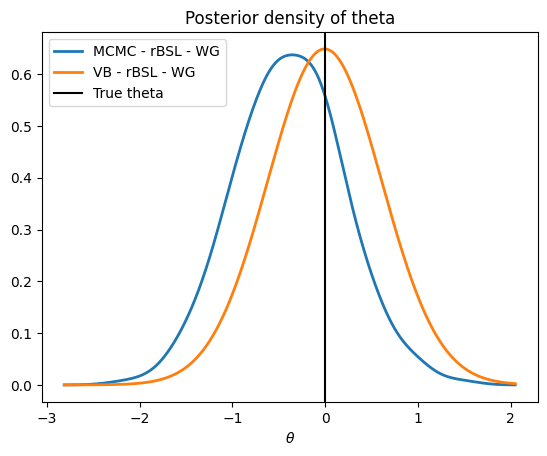

In [ ]:
plt.figure()
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(mcmc_nuissance_wasserstein_mean-4*mcmc_nuissance_wasserstein_std,np.mean(best_theta)-4*np.std(best_theta)), max(mcmc_nuissance_wasserstein_mean+4*mcmc_nuissance_wasserstein_std, np.mean(best_theta)+4*np.std(best_theta)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.185, kernel='gaussian')
kde_mcmc.fit(best_theta_mcmc.reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.615, kernel='gaussian')
kde_vb.fit(best_theta.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC - rBSL - WG')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - rBSL - WG')

plt.axvline(x = 0, ymin = 0, color = 'black', label = 'True theta')

plt.legend()
plt.xlabel(r'$\theta$')
plt.title('Posterior density of theta')